# Notebook Info

This notebook is based on SCIMAI-Gym notebook by Stranieri et al. The author adapted it with the latest available package such as Gymnasium, Ray, and Ax.

Adaption of Reinforcement Learning Class also has been made to add perishability behaviour of the product.

The chosen heuristic to be tested with PPO is Base-Stock Policy and Capped Base-Stock Policy. These heuristics are known to be well performed under lost sales condition.

# Environment Setup

## Install Libraries

In [ ]:
"""
OpenAI Gym
"""
%pip install -U gym

In [ ]:
"""
https://ray.io/
"""
%pip install "ray==2.31.0" "ray[rllib]" "ray[tune]"

In [ ]:
"""
https://ax.dev/
"""
%pip install -U ax-platform

In [ ]:
%pip install -U GPUtil
%pip install -U dataframe_image
%pip install -U dm-tree
%pip install -U kaleido
%pip install -U lxml
%pip install -U lz4
%pip install matplotlib==3.4.3
%pip install numpy==1.26.4
%pip install -U pandas
%pip install -U seaborn
%pip install -U tabulate
%pip install -U tensorboardX

In [ ]:
import sys

version_info = sys.version_info
print(f"Python version is {version_info}")

if sys.version_info >= (3, 7):
    %pip uninstall -y dataclasses
else:
    %pip install -U dataclasses

In [ ]:
# force the runtime to restart
import os

os._exit(0)

## Import Libraries

In [1]:
# Python logging
import logging

logging.basicConfig()
logger = logging.getLogger('LOGGING_RL_Simulation')
logger.setLevel(logging.WARN)

In [2]:
# importing Gym
import gymnasium as gym
from gymnasium.spaces import Box

In [3]:
# importing Ray
import ray.rllib.algorithms.ppo as ppo

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.stopper import (CombinedStopper,
                              MaximumIterationStopper,
                              ExperimentPlateauStopper)

from ray.rllib.utils import try_import_torch
torch = try_import_torch

In [ ]:
# importing Ax
from ax.service.managed_loop import optimize

from ax.plot.contour import interact_contour, plot_contour_plotly
from ax.plot.trace import optimization_trace_single_method_plotly

from ax.utils.notebook.plotting import render, init_notebook_plotting
init_notebook_plotting()

[INFO 01-23 06:07:56] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 01-23 06:07:56] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


In [ ]:
# importing libraries
import collections
import dataframe_image as dfi
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import shutil

from datetime import datetime
from itertools import chain
from tabulate import tabulate
from timeit import default_timer
from IPython.display import display

sns.set_theme(context='paper', style='whitegrid', font_scale=2.4)

In [6]:
# setting seed for reproducibility
seed = 2021
base_seed = 2021
np.random.seed(seed)

In [ ]:
# setting output views for debug
if logger.level == 10:
    verbose = 3
    plt.ion()
else:
    verbose = 0
    plt.ioff()

In [8]:
# getting the number of CPUs
import multiprocessing

try:
    num_cpus = multiprocessing.cpu_count()
except Exception as e:
    print(f"{e.__class__} occurred!")
    num_cpus = 0

print(f"num cpus is {num_cpus}")

num cpus is 22


In [9]:
# getting the number of GPUs
import GPUtil as GPU

try:
    num_gpus = len(GPU.getGPUs())
except Exception as e:
    print(f"{e.__class__} occurred!")
    num_gpus = 0

print(f"num gpus is {num_gpus}")

num gpus is 0


# Reinforcement Learning Classes

## State Class

In [ ]:
class State:
    """
    the state vector include all current stock levels for each warehouse and product type, plus the last demand values.

    Adaptation for perishability (age buckets):
    - Add age-bucket stocks for factory and warehouses (shelf_life = 3)
    - factory_stocks / distr_warehouses_stocks is aggregated totals, while the RL-relevant
      inventory is stored in *_age arrays.
    """

    def __init__(self, product_types_num, distr_warehouses_num, T,
                 demand_history, t=0, shelf_life=3):
        self.product_types_num = product_types_num

        # perishability setting
        self.shelf_life = shelf_life

        # age-bucket stocks (age 0..shelf_life-1)
        # Factory: shape (shelf_life, I)
        self.factory_stocks_age = np.zeros(
            (self.shelf_life, self.product_types_num),
            dtype=np.int32)

        self.distr_warehouses_num = distr_warehouses_num

        # Warehouses: shape (J, shelf_life, I)
        self.distr_warehouses_stocks_age = np.zeros(
            (self.distr_warehouses_num, self.shelf_life, self.product_types_num),
            dtype=np.int32)

        # aggregated totals over ages
        self.factory_stocks = np.zeros(
            (self.product_types_num,),
            dtype=np.int32)
        self.distr_warehouses_stocks = np.zeros(
            (self.distr_warehouses_num, self.product_types_num),
            dtype=np.int32)

        self.T = T
        self.demand_history = demand_history
        self.t = t

        # Production pipeline (arriving in next step), shape (1, I) since lead time = 1
        self.production_pipeline = np.zeros((1, self.product_types_num), dtype=np.int32)

        # Ensure aggregated totals match age-bucket representation.
        self._sync_totals_from_age()

        logger.debug(f"\n--- State --- __init__"
                     f"\nproduct_types_num is "
                     f"{self.product_types_num}"
                     f"\nshelf_life is "
                     f"{self.shelf_life}"
                     f"\nfactory_stocks_age is "
                     f"{self.factory_stocks_age}"
                     f"\ndistr_warehouses_num is "
                     f"{self.distr_warehouses_num}"
                     f"\ndistr_warehouses_stocks_age is "
                     f"{self.distr_warehouses_stocks_age}"
                     f"\nfactory_stocks is "
                     f"{self.factory_stocks}"
                     f"\ndistr_warehouses_stocks is "
                     f"{self.distr_warehouses_stocks}"
                     f"\nT is "
                     f"{self.T}"
                     f"\ndemand_history is "
                     f"{self.demand_history}"
                     f"\nt is "
                     f"{self.t}")

    def _sync_totals_from_age(self):
        self.factory_stocks = self.factory_stocks_age.sum(axis=0).astype(np.int32)
        self.distr_warehouses_stocks = self.distr_warehouses_stocks_age.sum(axis=1).astype(np.int32)

    def to_array(self):
        """
        Observation vector:
        - factory age-bucket stocks (flattened)
        - warehouse age-bucket stocks (flattened)
        - demand history (flattened)
        - time index t
        """
        self._sync_totals_from_age()

        obs = np.concatenate((
            self.factory_stocks_age.flatten(),
            self.distr_warehouses_stocks_age.flatten(),
            self.production_pipeline.flatten(),  # NEW
            np.hstack(list(chain(*chain(*self.demand_history)))),
            [self.t]
        ))

        logger.debug(f"\n--- State --- to_array"
                     f"\nnp.concatenate is "
                     f"""{obs}""")

        return obs

    def stock_levels(self):
        """
        return aggregated stock totals (no ages).
        """
        self._sync_totals_from_age()

        stock_vec = np.concatenate((
            self.factory_stocks,
            self.distr_warehouses_stocks.flatten()
        ))

        logger.debug(f"\n--- State --- stock_levels"
                     f"\nnp.concatenate is "
                     f"""{stock_vec}""")

        return stock_vec

    def stock_levels_by_age(self):
        """
        returns age-bucket stocks (flattened).
        """
        by_age_vec = np.concatenate((
            self.factory_stocks_age.flatten(),
            self.distr_warehouses_stocks_age.flatten()
        ))

        logger.debug(f"\n--- State --- stock_levels_by_age"
                     f"\nnp.concatenate is "
                     f"""{by_age_vec}""")

        return by_age_vec


## Action Class

In [11]:
class Action:
    """
    The action vector consists of production and shipping controls.

    Adaptation for perishability + production lead time:
    - Perishability (age buckets) is handled in the environment transition:
      production arrivals go into age=0 after 1-step lead time; shipments draw FIFO.
    """

    def __init__(self, product_types_num, distr_warehouses_num):
        self.production_level = np.zeros(
            (product_types_num,),
            dtype=np.int32)
        self.shipped_stocks = np.zeros(
            (distr_warehouses_num, product_types_num),
            dtype=np.int32)

        logger.debug(f"\n--- Action --- __init__"
                     f"\nproduction_level is "
                     f"{self.production_level}"
                     f"\nshipped_stocks is "
                     f"{self.shipped_stocks}")


## Supply Chain Environment Class

In [ ]:
class SupplyChainEnvironment:
    """
    We designed a divergent two-echelon supply chain that includes a single
    factory, multiple distribution warehouses, and single product types over
    a fixed number of time steps. At each time step, the agent is asked to find
    the number of products to be produced and preserved at the factory, as well
    as the number of products to be shipped to different distribution
    warehouses. To make the supply chain more realistic, we set capacity
    constraints on warehouses and on how many units to produce
    at the factory along with storage and transportation costs.

    Experiment settings:
    - product_types_num = 1
    - distr_warehouses_num = 1 (can be >1)
    - T = 30
    - Demand: d_{i,j,t} = max(0, mu_j + A_j*cos^3(4*pi*(2*i*j + t)/T) + eps),
      eps ~ Normal(0, demand_noise_std)
      with mu, A  same for all warehouse.
    - Perishability via age buckets (shelf life = 3) at factory and warehouses
    - Production lead time = 1 timestep, shipment lead time = 0
    - Lost sales (unmet demand dropped; inventories never negative)
    - Add waste penalty
    - Reward:
        revenues - production - transportation - storage - penalty(lost sales) - waste
    """

    def __init__(self, config=None):
        self.config = config or {}
        # number of product types (default: 1)
        self.product_types_num = 1
        # number of distribution warehouses (default: 1, can be >1)
        self.distr_warehouses_num = 1
        # final time step (1 episode takes 30 time steps)
        self.T = 30

        # --- Perishability + lead time settings ---
        self.shelf_life = 3
        self.production_lead_time = 1  # 1 timestep
        # shipment lead time 0

        # sale prices, per unit
        self.sale_prices = np.array([20], np.int32)
        # production costs, per unit
        self.production_costs = np.array([2], np.int32)

        # storage capacities for each product type at each warehouse, units
        # shape (J+1, I): row 0 = factory, rows 1..J = warehouses
        self.storage_capacities = np.array(
            [[60],  # factory capacity for product 0
             [60]
             ],  # warehouse 0 capacity for product 0
            np.int32)

        # storage costs of each product type at each warehouse, per unit
        # shape (J+1, I)
        self.storage_costs = np.array(
            [[2.0],   # factory holding cost
             [1.5]],  # warehouse holding cost
            np.float32)

        # transportation costs of each product type for each distribution warehouse, per unit
        # shape (J, I)
        self.transportation_costs = np.array(
            [[1]
             ],  # from factory to warehouse
            np.float32)

        # penalty costs (lost sales), per unit
        self.penalty_costs = 0.5 * self.sale_prices

        # waste penalty cost
        self.waste_penalty_cost = 0.5 * self.sale_prices

        # Demand parameters per-warehouse
        # If distr_warehouses_num > 1, fill with the same defaults
        self.demand_mu = np.array([7.0] * self.distr_warehouses_num, dtype=np.float32)
        self.demand_A = np.array([8.0] * self.distr_warehouses_num, dtype=np.float32)
        self.demand_noise_std = 1.0

        # print(f"\n--- SupplyChainEnvironment --- __init__"
        #       f"\nproduct_types_num is "
        #       f"{self.product_types_num}"
        #       f"\ndistr_warehouses_num is "
        #       f"{self.distr_warehouses_num}"
        #       f"\nT is "
        #       f"{self.T}"
        #       f"\nsale_prices is "
        #       f"{self.sale_prices}"
        #       f"\nproduction_costs is "
        #       f"{self.production_costs}"
        #       f"\nstorage_capacities is "
        #       f"{self.storage_capacities}"
        #       f"\nstorage_costs is "
        #       f"{self.storage_costs}"
        #       f"\ntransportation_costs is "
        #       f"{self.transportation_costs}"
        #       f"\npenalty_costs is "
        #       f"{self.penalty_costs}"
        #       f"\nwaste_penalty_cost is "
        #       f"{self.waste_penalty_cost}"
        #       f"\nshelf_life is "
        #       f"{self.shelf_life}"
        #       f"\nproduction_lead_time is "
        #       f"{self.production_lead_time}"
        #       f"\ndemand_mu is "
        #       f"{self.demand_mu}"
        #       f"\ndemand_A is "
        #       f"{self.demand_A}"
        #       f"\ndemand_noise_std is "
        #       f"{self.demand_noise_std}")

        self.reset()

    def reset(self, demand_history_len=5):
        # five demand values observed
        self.demand_history = collections.deque(maxlen=demand_history_len)

        # pipeline[k] is the production that will arrive in k+1 steps.
        # with lead time=1 -> shape (1, I)
        self.production_pipeline = np.zeros(
            (self.production_lead_time, self.product_types_num),
            dtype=np.int32)

        logger.debug(f"\n--- SupplyChainEnvironment --- reset"
                     f"\ndemand_history is "
                     f"{self.demand_history}"
                     f"\nproduction_pipeline is "
                     f"{self.production_pipeline}")

        for d in range(demand_history_len):
            self.demand_history.append(np.zeros(
                (self.distr_warehouses_num, self.product_types_num),
                dtype=np.int32))
        self.t = 0

        logger.debug(f"\ndemand_history is "
                     f"{self.demand_history}"
                     f"\nt is "
                     f"{self.t}"
                     f"\ndemand_mu is "
                     f"{self.demand_mu}"
                     f"\ndemand_A is "
                     f"{self.demand_A}"
                     f"\ndemand_noise_std is "
                     f"{self.demand_noise_std}")

    def demand(self, j, i, t):
        # Demand model:
        # d_{i,j,t} = max(0, mu_j + A_j*cos^3(4*pi*(2*i*j + t)/T) + eps)
        # eps ~ Normal(0, demand_noise_std)
        j = int(np.asarray(j).item())
        i = int(np.asarray(i).item())
        t = int(np.asarray(t).item())

        mu_j = float(self.demand_mu[j - 1])
        A_j = float(self.demand_A[j - 1])

        seasonal = (np.cos(4 * np.pi * (2 * i * j + t) / self.T) ** 3)
        eps = np.random.normal(loc=0.0, scale=float(self.demand_noise_std))

        demand = int(max(0.0, np.round(mu_j + A_j * seasonal + eps)))

        logger.debug(f"\n--- SupplyChainEnvironment --- demand"
                     f"\nj is "
                     f"{j}"
                     f"\ni is "
                     f"{i}"
                     f"\nt is "
                     f"{t}"
                     f"\nmu_j is "
                     f"{mu_j}"
                     f"\nA_j is "
                     f"{A_j}"
                     f"\nseasonal is "
                     f"{seasonal}"
                     f"\neps is "
                     f"{eps}"
                     f"\ndemand is "
                     f"{demand}")

        return demand

    def initial_state(self):
        state = State(
            self.product_types_num,
            self.distr_warehouses_num,
            self.T,
            list(self.demand_history),
            shelf_life=self.shelf_life
        )

        # ---------------------------
        # Warm-start initial inventory (age 0 only) - Not used in this experiment
        # ---------------------------
        init_factory = int(self.config.get("init_factory_inventory", 0))  # per product
        init_wh = int(self.config.get("init_wh_inventory", 0))            # per warehouse per product

        if init_factory > 0:
            state.factory_stocks_age[0, :] = init_factory

        if init_wh > 0:
            state.distr_warehouses_stocks_age[:, 0, :] = init_wh

        # keep totals consistent
        state._sync_totals_from_age()

        # ---------------------------
        # warm-start pipeline (lead time = 1)
        # ---------------------------
        init_pipeline = int(self.config.get("init_pipeline_inventory", 0))
        if init_pipeline > 0 and hasattr(self, "production_pipeline"):
            # production_pipeline shape: (lead_time, I)
            self.production_pipeline[:, :] = init_pipeline

        # copy pipeline into the STATE so PPO can see it
        if hasattr(state, "production_pipeline"):
            state.production_pipeline = self.production_pipeline.copy()

        logger.debug(
            f"\n--- SupplyChainEnvironment --- initial_state (warm start)"
            f"\ninit_factory_inventory={init_factory}"
            f"\ninit_wh_inventory={init_wh}"
            f"\ninit_pipeline_inventory={init_pipeline}"
            f"\nfactory_stocks_age=\n{state.factory_stocks_age}"
            f"\nwh_stocks_age=\n{state.distr_warehouses_stocks_age}"
        )

        return state

    def _fifo_remove(self, age_buckets_2d, qty):
        """
        Remove units from age-bucket inventory using FIFO (oldest first).
        age_buckets_2d: shape (shelf_life, I)
        qty: array shape (I,)
        Returns: (removed_qty, updated_age_buckets)
        """
        removed = np.zeros_like(qty, dtype=np.int32)
        remaining = qty.astype(np.int32).copy()

        # oldest first: age shelf_life-1 down to 0
        for a in range(self.shelf_life - 1, -1, -1):
            take = np.minimum(age_buckets_2d[a], remaining)
            age_buckets_2d[a] = age_buckets_2d[a] - take
            removed = removed + take
            remaining = remaining - take

        return removed, age_buckets_2d

    def _age_and_waste(self, age_buckets_2d):
        """
        Age inventory by one step and return waste (expired) for a 2D age bucket array (shelf_life, I).
        Items in the last bucket expire and become waste.
        """
        waste = age_buckets_2d[-1].copy()
        # shift ages up: new_age[a+1] = old_age[a]
        age_buckets_2d[1:] = age_buckets_2d[:-1]
        age_buckets_2d[0] = 0
        return waste, age_buckets_2d

    def step(self, state, action):
        # demands: shape (J, I) with scalar calls to demand()
        demands = np.zeros(
            (self.distr_warehouses_num, self.product_types_num),
            dtype=np.int32
        )
        for j in range(self.distr_warehouses_num):
            for i in range(self.product_types_num):
                demands[j, i] = self.demand(j + 1, i + 1, self.t)

        # next state
        next_state = State(self.product_types_num, self.distr_warehouses_num,
                        self.T, list(self.demand_history),
                        shelf_life=self.shelf_life)

        # ---------------------------
        # 1) Start from current age-bucket inventories
        # ---------------------------
        factory_age = state.factory_stocks_age.copy()
        wh_age = state.distr_warehouses_stocks_age.copy()

        # Proactive production cap
        current_factory_total = state.factory_stocks.sum(axis=0)
        remaining_factory_cap = self.storage_capacities[0] - current_factory_total
        action.production_level = np.minimum(action.production_level, remaining_factory_cap).astype(np.int32)

        # ---------------------------
        # 2) Production arrivals (lead time = 1)
        # ---------------------------
        arrivals = self.production_pipeline[0].copy() if self.production_lead_time > 0 else action.production_level.copy()
        if self.production_lead_time > 0:
            if self.production_lead_time > 1:
                self.production_pipeline[:-1] = self.production_pipeline[1:]
            self.production_pipeline[-1] = action.production_level.astype(np.int32)

        factory_age[0] = factory_age[0] + arrivals

        # Overflow safety (Factory)
        factory_total = factory_age.sum(axis=0)
        factory_cap = self.storage_capacities[0].astype(np.int32)
        overflow_factory = np.maximum(factory_total - factory_cap, 0).astype(np.int32)
        overflow_factory_units = np.zeros(self.product_types_num, dtype=np.int32)
        if np.any(overflow_factory > 0):
            removed_over, factory_age = self._fifo_remove(factory_age, overflow_factory)
            overflow_factory_units = removed_over

        # ---------------------------
        # 3) Shipments (lead time = 0)
        # ---------------------------
        shipped_actual = np.zeros_like(action.shipped_stocks, dtype=np.int32)
        remaining_factory = factory_age.sum(axis=0).astype(np.int32)

        # Initialize overflow tracker (will be filled in step 5 now)
        total_overflow_wh = np.zeros(self.product_types_num, dtype=np.int32)

        # Fair scaling if total requested > available factory stock
        req = action.shipped_stocks.astype(np.int32)          # (J,I)
        available = factory_age.sum(axis=0).astype(np.int32)  # (I,)

        total_req = req.sum(axis=0)                           # (I,)
        scale = np.minimum(1.0, available / (total_req + 1e-8))
        req_scaled = np.floor(req * scale).astype(np.int32)

        action.shipped_stocks = req_scaled

        for j in range(self.distr_warehouses_num):
            req = action.shipped_stocks[j].astype(np.int32)
            ship = np.minimum(req, remaining_factory)
            shipped_actual[j] = ship
            removed, factory_age = self._fifo_remove(factory_age, ship)
            remaining_factory = remaining_factory - removed

            # Shipments arrive immediately (age 0)
            wh_age[j, 0] = wh_age[j, 0] + removed

            # We allow temporary overflow (current stock + shipment => max capa) until sales happen.

        # ---------------------------
        # 4) Demand fulfillment at warehouses
        # ---------------------------
        sales = np.zeros((self.distr_warehouses_num, self.product_types_num), dtype=np.int32)
        lost_sales = np.zeros((self.distr_warehouses_num, self.product_types_num), dtype=np.int32)

        for j in range(self.distr_warehouses_num):
            demand_j = demands[j].astype(np.int32)
            # Available includes the shipments that just arrived
            available_j = wh_age[j].sum(axis=0).astype(np.int32)

            sold = np.minimum(demand_j, available_j)
            unfilled = demand_j - sold

            # Remove sold items FIFO
            removed, wh_age[j] = self._fifo_remove(wh_age[j], sold)
            sales[j] = removed
            lost_sales[j] = unfilled

        # ---------------------------
        # 5) Warehouse Capacity Check (Post-Sales)
        # ---------------------------
        # Check if we are still over capacity after selling items
        for j in range(self.distr_warehouses_num):
            wh_total = wh_age[j].sum(axis=0)
            wh_cap = self.storage_capacities[j + 1].astype(np.int32)

            overflow_wh = np.maximum(wh_total - wh_cap, 0).astype(np.int32)
            if np.any(overflow_wh > 0):
                removed_over, wh_age[j] = self._fifo_remove(wh_age[j], overflow_wh)
                total_overflow_wh += removed_over  # Accumulate waste from overflow

        # ---------------------------
        # 6) Compute costs/reward components before aging
        # ---------------------------
        next_state.factory_stocks_age = factory_age.copy()
        next_state.distr_warehouses_stocks_age = wh_age.copy()
        next_state._sync_totals_from_age()

        total_revenues = np.dot(self.sale_prices, np.sum(sales, axis=0))
        total_production_costs = np.dot(self.production_costs, action.production_level)
        total_transportation_costs = np.dot(self.transportation_costs.flatten(), shipped_actual.flatten())
        total_storage_costs = np.dot(self.storage_costs.flatten(), next_state.stock_levels())
        total_penalty_costs = np.dot(self.penalty_costs, np.sum(lost_sales, axis=0))

        # Snapshot pre-aging
        factory_age_pre_ageing = factory_age.copy()
        wh_age_pre_ageing = wh_age.copy()

        # ---------------------------
        # 7) Aging + waste to form the next state (t+1)
        # ---------------------------
        total_waste_units = np.zeros((self.product_types_num,), dtype=np.int32)

        # Include overflow waste (calculated in step 2 and 5)
        total_waste_units += overflow_factory_units + total_overflow_wh

        # Pure expiry waste
        waste_f, factory_age_aged = self._age_and_waste(factory_age)
        total_waste_units += waste_f

        wh_age_aged = wh_age.copy()
        for j in range(self.distr_warehouses_num):
            waste_w, wh_age_aged[j] = self._age_and_waste(wh_age_aged[j])
            total_waste_units += waste_w

        next_state.factory_stocks_age = factory_age_aged
        next_state.distr_warehouses_stocks_age = wh_age_aged
        next_state._sync_totals_from_age()

        total_waste_costs = np.dot(self.waste_penalty_cost, total_waste_units)

        reward = total_revenues - total_production_costs - \
                total_transportation_costs - total_storage_costs - \
                total_penalty_costs - total_waste_costs

        info = {
            "demands": demands.copy(),
            "factory_age_pre_ageing": factory_age_pre_ageing.copy(),
            "wh_age_pre_ageing": wh_age_pre_ageing.copy(),
            "sales_units": sales.copy(),
            "lost_sales_units": lost_sales.copy(),
            "overflow_factory": overflow_factory_units.copy(),
            "overflow_wh": total_overflow_wh.copy(),
            "expiry_waste": total_waste_units - overflow_factory_units - total_overflow_wh,
            "total_waste_units": total_waste_units.copy(),
            "total_revenues": float(total_revenues),
            "total_production_costs": float(total_production_costs),
            "total_transportation_costs": float(total_transportation_costs),
            "total_storage_costs": float(total_storage_costs),
            "total_penalty_costs": float(total_penalty_costs),
            "total_waste_costs": float(total_waste_costs),
        }

        self.demand_history.append(demands)
        self.t += 1
        done = self.t >= self.T

        # Expose pipeline to agent in next obs
        next_state.production_pipeline = self.production_pipeline.copy()

        return next_state, reward, done, info

## Supply Chain Gym Wrapper

In [ ]:
class SupplyChainGym(gym.Env):
    def __init__(self, config=None):
        self.config = config or {}
        self.supplychain = SupplyChainEnvironment(config=self.config)
        I, J = self.supplychain.product_types_num, self.supplychain.distr_warehouses_num
        act_dim = I + I + J * I  # for I=1 -> 2+J

        self.action_space = Box(
            low=-1.0,
            high=1.0,
            shape=(act_dim,),
            dtype=np.float32
        )

        # Obs space
        self.supplychain.reset()  # Get maxlen=5
        dummy_state = self.supplychain.initial_state()
        obslen = len(dummy_state.to_array())
        low_obs = np.zeros(obslen, dtype=np.float32)
        high_obs = np.full(obslen, 1000.0, dtype=np.float32) 
        self.observation_space = Box(low_obs, high_obs, dtype=np.float32)

        self.reset()

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.supplychain.reset()  # Fills history with 5 zeros
        self.supplychain.t = 0
        self.state = self.supplychain.initial_state()
        obs = np.asarray(self.state.to_array(), dtype=np.float32)
        return obs, {}

    def _denorm_to_range(self, a, cap):
        # a in [-1, 1] -> x in [0, cap]
        return 0.5 * (a + 1.0) * cap

    def step(self, action):
        I = self.supplychain.product_types_num
        J = self.supplychain.distr_warehouses_num

        action = np.asarray(action, dtype=np.float32)

        # capacities
        cap_prod = self.supplychain.storage_capacities[0].astype(np.float32)          # (I,)
        cap_ship_each = self.supplychain.storage_capacities[1:1+J].astype(np.float32) # (J,I)

        # split normalized actions
        a_prod = action[:I]                         # (I,)
        a_total_ship = action[I:2*I]                # (I,)
        a_logits = action[2*I:].reshape(J, I)       # (J,I)

        # map prod to [0, cap_prod]
        prod_f = 0.5 * (a_prod + 1.0) * cap_prod
        prod_f = np.clip(prod_f, 0.0, cap_prod)

        # map total_ship to [0, sum caps]
        total_cap_ship = cap_ship_each.sum(axis=0)  # (I,)
        total_ship_f = 0.5 * (a_total_ship + 1.0) * total_cap_ship
        factory_available = float(self.state.factory_stocks.sum())
        total_ship_f = np.clip(total_ship_f, 0.0, min(total_cap_ship, factory_available))

        # softmax allocation per product i
        # scale logits to reduce extreme allocations early
        logits = 2.0 * a_logits
        logits = logits - np.max(logits, axis=0, keepdims=True)
        exp = np.exp(logits)
        weights = exp / (np.sum(exp, axis=0, keepdims=True) + 1e-8)  # (J,I), sums to 1 over J

        # desired per-warehouse shipments
        ship_f = weights * total_ship_f.reshape(1, I)                # (J,I)
        ship_f = np.minimum(ship_f, cap_ship_each)                   # respect per-warehouse cap

        # round once at end
        prod_i = np.floor(prod_f + 1e-6).astype(np.int32)            # (I,)
        ship_i = np.floor(ship_f + 1e-6).astype(np.int32)            # (J,I)

        action_obj = Action(I, J)
        action_obj.production_level = prod_i
        action_obj.shipped_stocks = ship_i

        self.state, reward, done, info = self.supplychain.step(self.state, action_obj)
        obs = np.asarray(self.state.to_array(), dtype=np.float32)
        return obs, float(reward), done, False, info



# Global Parameters

In [14]:
# number of episodes for the simulations
num_episodes = 200

In [ ]:
# name of the experiment
now = datetime.now()
now_str = now.strftime('%d-%m-%Y_%H-%M-%S')
local_dir = f"1W_{now_str}"
# dir to save plots
plots_dir = 'plots'
# creating necessary dirs
if not os.path.exists(f"{local_dir}"):
    os.makedirs(f"{local_dir}")
if not os.path.exists(f"{local_dir+'/'+plots_dir}"):
    os.makedirs(f"{local_dir+'/'+plots_dir}")

# Supply Chain Environment Initialization

## Visualize Demand Methods

In [ ]:
def visualize_demand(num_episodes=1, local_dir=local_dir, plots_dir=plots_dir, seed=None):
    """
    Visualize demand behavior for each distribution warehouse and for each product type.
    """
    if env.distr_warehouses_num <= 3 and env.product_types_num <= 2:
        demands = []
        for n in range(num_episodes):
            if seed is not None:
                np.random.seed(seed + n)

            dem = np.zeros(
                (env.distr_warehouses_num, env.product_types_num, env.T),
                dtype=np.int32
            )
            for j in range(env.distr_warehouses_num):
                for i in range(env.product_types_num):
                    for t in range(env.T):
                        dem[j, i, t] = env.demand(j + 1, i + 1, t)
            demands.append(dem)

        demands_arr = np.stack(demands, axis=0)
        demands_mean = np.mean(demands_arr, axis=0)
        demands_std = np.std(demands_arr, axis=0)

        plt.figure(figsize=(15, 5))
        plt.xlabel('Time Steps')
        plt.ylabel('Demand Value')
        plt.xticks(np.arange(env.T))
        plt.tick_params(axis='x', which='both', top=True, bottom=True, labelbottom=True)
        plt.ticklabel_format(axis='y', style='plain', useOffset=False)
        plt.tight_layout()

        # Explicit line/marker for legend
        lines = []
        color = [['b', 'b'], ['g', 'g'], ['r', 'r']]
        linestyle = ['-', '--', '-.', ':'] 

        for j in range(env.distr_warehouses_num):
            for i in range(env.product_types_num):
                # Plot mean line
                line, = plt.plot(range(env.T), demands_mean[j, i, :],
                                color=color[j][i], linestyle=linestyle[i], linewidth=2.5)
                lines.append(line)

                # Fill 
                plt.fill_between(range(env.T),
                                (demands_mean[j, i, :] - demands_std[j, i, :]).flatten(),
                                (demands_mean[j, i, :] + demands_std[j, i, :]).flatten(),
                                color=color[j][i], alpha=0.2, label='_nolegend_')

                # Reference envelope
                mu_j = float(env.demand_mu[j])
                A_j = float(env.demand_A[j])
                plt.hlines(mu_j + A_j, 0, env.T - 1, colors=color[j][i],
                          linestyles=':', alpha=0.4, linewidth=1.5)
                plt.hlines(max(0.0, mu_j - A_j), 0, env.T - 1, colors=color[j][i],
                          linestyles=':', alpha=0.4, linewidth=1.5)

        # Legend from explicit line handles only
        plt.legend(lines, [f"WH {j+1}, Prod {i+1}"
                          for j in range(env.distr_warehouses_num)
                          for i in range(env.product_types_num)],
                  loc='upper left', frameon=True)

        plt.savefig(f"{local_dir}/{plots_dir}/demand.pdf", format='pdf', bbox_inches='tight')
        plt.show()


In [19]:

def save_env_settings(env, local_dir=local_dir, plots_dir=plots_dir):
    """
    Save the Supply Chain Environment settings.
    """
    f = open(f"{local_dir}/{plots_dir}"
             f"/env_settings.txt",
             'w', encoding='utf-8')
    f.write(f"--- SupplyChainEnvironment ---"
              f"\nproduct_types_num is "
              f"{env.product_types_num}"
              f"\ndistr_warehouses_num is "
              f"{env.distr_warehouses_num}"
              f"\nT is "
              f"{env.T}"
              f"\nsale_prices is "
              f"{env.sale_prices}"
              f"\nproduction_costs is "
              f"{env.production_costs}"
              f"\nstorage_capacities is "
              f"{env.storage_capacities}"
              f"\nstorage_costs is "
              f"{env.storage_costs}"
              f"\ntransportation_costs is "
              f"{env.transportation_costs}"
              f"\npenalty_costs is "
              f"{env.penalty_costs}"
              f"\nwaste_penalty_cost is "
              f"{env.waste_penalty_cost}"
              f"\nshelf_life is "
              f"{env.shelf_life}"
              f"\nproduction_lead_time is "
              f"{env.production_lead_time}"
              f"\ndemand_mu is "
              f"{env.demand_mu}"
              f"\ndemand_A is "
              f"{env.demand_A}"
              f"\ndemand_noise_std is "
              f"{env.demand_noise_std}")
    f.close()


## Initialization

In [ ]:
# config for warm startup
env_config = {"init_factory_inventory": 0, "init_wh_inventory": 0}

# supply chain env
env = SupplyChainEnvironment(config=env_config)

In [21]:
# saving env settings
save_env_settings(env)

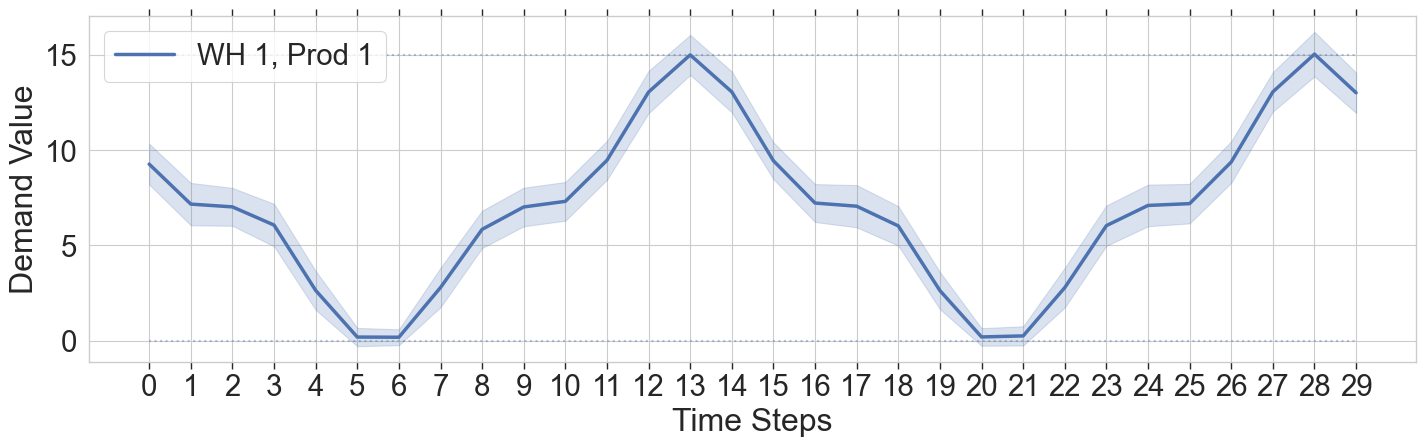

In [22]:
visualize_demand(num_episodes=num_episodes)

# Methods

## Simulator Methods

In [ ]:
import numpy as np

def _unwrap_rllib_obj(obj):
    if isinstance(obj, (tuple, list)) and len(obj) > 0:
        return obj[0]
    return obj

def _rllib_compute_action(obj, obs):
    """
    Robust action getter for Ray 2.x RLlib.

    Supports:
    - Algorithm.compute_single_action(obs, explore=False)
    - Policy.compute_single_action(obs, explore=False)
    - Fallback: compute_actions([obs], explore=False)
    Also handles accidental tuple/list inputs: (algo, policy)
    Returns: np.ndarray action (float32)
    """
    obj = _unwrap_rllib_obj(obj)

    if hasattr(obj, "compute_single_action"):
        try:
            out = obj.compute_single_action(obs, explore=False)
        except TypeError:
            out = obj.compute_single_action(obs)
        action = out[0] if isinstance(out, (tuple, list)) else out
        return np.asarray(action, dtype=np.float32) # Ensure float32 for Gym action space

    if hasattr(obj, "compute_actions"):
        try:
            actions, _, _ = obj.compute_actions([obs], explore=False)
        except TypeError:
            actions, _, _ = obj.compute_actions([obs])
        return np.asarray(actions[0], dtype=np.float32) # Ensure float32 for Gym action space

    raise TypeError(f"Unsupported RLlib object type: {type(obj)}")

def simulate_episode(env_config, policy_or_algo, seed=None):
    """One episode simulator, dynamically creating the environment."""
    if seed is not None:
        np.random.seed(seed)

    transitions = []

    # For RLlib policies, use SupplyChainGym wrapper
    if not isinstance(policy_or_algo, (CappedBaseStockPolicy, BaseStockPolicy)):
        env_gym = SupplyChainGym(config=env_config)
        obs, info = env_gym.reset(seed=seed)
        current_state_obj = env_gym.state # Get the internal State object from the gym env

        for t in range(env_gym.supplychain.T): # Use the internal supplychain env's T
            action_vec = _rllib_compute_action(policy_or_algo, obs)

            # Call step on the Gym wrapper
            obs, reward, terminated, truncated, info = env_gym.step(action_vec)
            done = terminated or truncated

            transitions.append({
                't': t,
                'state': current_state_obj.to_array().copy(),
                'action': action_vec.copy(),
                'reward': reward,
                'info': info,
            })
            if done:
                break
            current_state_obj = env_gym.state # Update internal state for next iteration

    # For heuristic policies, use SupplyChainEnvironment directly
    else:
        env_core = SupplyChainEnvironment(config=env_config)
        env_core.reset()
        state = env_core.initial_state()

        for t in range(env_core.T):
            action_obj = policy_or_algo.select_action(state)
            state, reward, done, info = env_core.step(state, action_obj)
            transitions.append({
                't': t, 'state': state.to_array().copy(),
                'action': action_obj, # Store the action object as is
                'reward': reward, 'info': info
            })
            if done: break

    return transitions

def simulate(env_config, policy_or_algo, num_episodes=1, seed=None):
    """Multi-episode simulation, creating environment instances."""
    base_seed = seed if seed is not None else 2021
    all_episodes_transitions = []

    for ep in range(num_episodes):
        current_seed = base_seed + ep
        episode_transitions = simulate_episode(env_config, policy_or_algo, seed=current_seed)
        all_episodes_transitions.append(episode_transitions)

    return all_episodes_transitions


# Visualize Transitions Methods

In [ ]:
def prepare_metric_plot(ylabel, n, plots_n=10 if env.product_types_num == 1 else 26, fontsize=12):
    """
    X-axis labels + ticks + spacing
    """
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel, fontsize=fontsize-2, fontweight='bold')
    plt.tick_params(axis='y', which='both',
                     left=True, right=True, labelleft=True,
                labelsize=fontsize-2)

    # X-axis: show timesteps 0,1,2,...,T-1
    plt.xticks(np.arange(env.T))
    plt.xlabel('Time Steps', fontsize=fontsize-2, labelpad=5)
    plt.tick_params(axis='x', which='both',
                   top=True, bottom=True, labelbottom=True,
                   labelsize=fontsize-2)

    # vertical spacing for labels
    plt.subplots_adjust(hspace=0.45)
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)

def fill_between_nonnegative(x, mean, std, **kwargs):
    mean = np.asarray(mean)
    std  = np.asarray(std)
    lower = np.maximum(mean - std, 0.0)
    upper = mean + std
    plt.fill_between(x, lower, upper, **kwargs)

def visualize_transitions(returns_trace, algorithm, local_dir=local_dir, plots_dir=plots_dir):
    if env.distr_warehouses_num <= 3 and env.product_types_num <= 2:
        num_episodes = len(returns_trace)
        T = env.T
        J = env.distr_warehouses_num
        I = env.product_types_num
        L = getattr(env, "shelf_life", 1)

        # Extract from DICT structure
        states_trace = [[ep[t]['state'] for t in range(len(ep))] for ep in returns_trace]
        actions_trace = [[ep[t]['action'] for t in range(len(ep))] for ep in returns_trace]
        rewards_trace = np.array([[ep[t]['reward'] for t in range(len(ep))]
                                 for ep in returns_trace], dtype=np.float32)
        infos_trace = [[ep[t]['info'] for t in range(len(ep))] for ep in returns_trace]

        lost_sales_units_trace = np.array([
            [np.sum(ep[t]['info'].get("lost_sales_units", 0)) for t in range(len(ep))]
            for ep in returns_trace], dtype=np.float32)

        total_waste_units_trace = np.array([
            [np.sum(ep[t]['info'].get("total_waste_units", 0)) for t in range(len(ep))]
            for ep in returns_trace], dtype=np.float32)

        has_age = I == 1 and 'factory_age_pre_ageing' in infos_trace[0][0]

        base_plots = 6 + 2*J + L + J*L + 2 + 1 + 1
        age_plots = (1 + J) * L if (I == 1 and has_age) else 0
        plots_n = base_plots + age_plots if I == 1 else 26

        plt.figure(figsize=(12, 4 * plots_n))
        plot_idx = 1

        # Factory Stocks
        prepare_metric_plot('Factory Stocks', plot_idx, plots_n=plots_n)
        plot_idx += 1
        tmp_mean, tmp_std = [], []
        for t in range(T):
            vals = [int(np.sum(states_trace[e][t][:L]))
                    for e in range(num_episodes)]
            tmp_mean.append(float(np.mean(vals)))
            tmp_std.append(float(np.std(vals)))
        plt.plot(range(T), tmp_mean, color='blue', alpha=0.5)
        # plt.fill_between(range(T), np.array(tmp_mean) - np.array(tmp_std),
        #                 np.array(tmp_mean) + np.array(tmp_std), color='blue', alpha=0.2)
        fill_between_nonnegative(range(T), tmp_mean, tmp_std, color='blue', alpha=0.2)

        # Warehouse stocks
        for j in range(J):
            prepare_metric_plot(f"Stocks,\nWH {j+1}", plot_idx, plots_n=plots_n)
            plot_idx += 1

            # Calculate warehouse j slice: starts at L (factory) + j*L
            wh_j_start = L + j * L
            wh_j_end = L + (j + 1) * L
            wh_j_slice = slice(wh_j_start, wh_j_end)

            tmp_mean, tmp_std = [], []
            for t in range(T):
                vals = [int(np.sum(states_trace[e][t][wh_j_slice])) for e in range(num_episodes)]
                tmp_mean.append(float(np.mean(vals)))
                tmp_std.append(float(np.std(vals)))

            plt.plot(range(T), tmp_mean, color='green', alpha=.5)
            # plt.fill_between(range(T),
            #                  np.array(tmp_mean) - np.array(tmp_std),
            #                  np.array(tmp_mean) + np.array(tmp_std),
            #                  color='green', alpha=.2)
            fill_between_nonnegative(range(T), tmp_mean, tmp_std, color='green', alpha=0.2)

            logger.debug(f"WH{j+1} stocks total (mean) is {tmp_mean} \n"
                         f"WH{j+1} stocks total (std) is {tmp_std}")

        prepare_metric_plot('Production Units', plot_idx, plots_n=plots_n)
        plot_idx += 1

        tmp_mean, tmp_std = [], []

        # --- helpers to decode PPO action ---
        def decode_ppo_prod_units(a_norm, cap_prod, I):
            """
            a_norm: raw PPO action vector in [-1,1], shape (2I + JI,)
            cap_prod: array shape (I,)
            returns: prod_i array shape (I,) in integer units
            """
            a_norm = np.asarray(a_norm, dtype=np.float32)
            a_prod = a_norm[:I]  # (I,)
            prod_f = 0.5 * (a_prod + 1.0) * cap_prod
            prod_f = np.clip(prod_f, 0.0, cap_prod)
            prod_i = np.floor(prod_f + 1e-6).astype(np.int32)
            return prod_i

        # Use capacities from env (same for all episodes if env fixed)
        cap_prod = env.storage_capacities[0].astype(np.float32)  # (I,)

        for t in range(T):
            if hasattr(actions_trace[0][t], 'production_level'):  # CBS/BS (Action object)
                vals = [int(np.sum(actions_trace[e][t].production_level)) for e in range(num_episodes)]
            else:
                # PPO: actions_trace[e][t] is raw normalized vector in [-1,1]
                vals = []
                for e in range(num_episodes):
                    prod_i = decode_ppo_prod_units(actions_trace[e][t], cap_prod, I)
                    vals.append(int(np.sum(prod_i)))

            tmp_mean.append(float(np.mean(vals)))
            tmp_std.append(float(np.std(vals)))

        plt.plot(range(T), tmp_mean, color='purple', alpha=0.7, linewidth=2.5)

        fill_between_nonnegative(range(T), tmp_mean, tmp_std, color='purple', alpha=0.2)

        # Shipment Units
        prepare_metric_plot('Shipment Units', plot_idx, plots_n=plots_n)
        plot_idx += 1
        tmp_mean, tmp_std = [], []
        for t in range(T):
            vals = [int(np.sum(infos_trace[e][t]['sales_units'])) for e in range(num_episodes)]
            tmp_mean.append(float(np.mean(vals)))
            tmp_std.append(float(np.std(vals)))
        plt.plot(range(T), tmp_mean, color='magenta', alpha=0.5)

        fill_between_nonnegative(range(T), tmp_mean, tmp_std, color='magenta', alpha=0.2)

        # Lost Sales
        prepare_metric_plot('Lost Sales', plot_idx, plots_n=plots_n)
        plot_idx += 1
        tmp_mean = lost_sales_units_trace.mean(axis=0)
        tmp_std = lost_sales_units_trace.std(axis=0)
        plt.plot(range(T), tmp_mean, color='red', alpha=0.5)

        fill_between_nonnegative(range(T), tmp_mean, tmp_std, color='red', alpha=0.2)

        # Waste
        prepare_metric_plot('Waste Units', plot_idx, plots_n=plots_n)
        plot_idx += 1
        tmp_mean = total_waste_units_trace.mean(axis=0)
        tmp_std = total_waste_units_trace.std(axis=0)
        plt.plot(range(T), tmp_mean, color='orange', alpha=0.5)

        fill_between_nonnegative(range(T), tmp_mean, tmp_std, color='orange', alpha=0.2)

        # Profits
        prepare_metric_plot('Profit', plot_idx, plots_n=plots_n)
        plot_idx += 1
        tmp_mean = rewards_trace.mean(axis=0)
        tmp_std = rewards_trace.std(axis=0)
        plt.plot(range(T), tmp_mean, color='blue', alpha=0.5)
        plt.fill_between(range(T), tmp_mean - tmp_std, tmp_mean + tmp_std,
                         color='blue', alpha=0.2)

        # Cumulative Profit
        prepare_metric_plot('Cumulative Profit', plot_idx, plots_n=plots_n)
        plot_idx += 1
        cum_profit = np.cumsum(rewards_trace, axis=1)
        tmp_mean = cum_profit.mean(axis=0)
        tmp_std = cum_profit.std(axis=0)
        plt.plot(range(T), tmp_mean, color='darkgreen', alpha=0.5)
        plt.fill_between(range(T), tmp_mean - tmp_std, tmp_mean + tmp_std,
                         color='darkgreen', alpha=0.2)

        # Final layout
        plt.subplots_adjust(hspace=0.45, top=0.92, bottom=0.08, left=0.12, right=0.96)
        plt.tight_layout()

        if not os.path.exists(f"{local_dir}/{plots_dir}/{algorithm}"):
            os.makedirs(f"{local_dir}/{plots_dir}/{algorithm}")
        plt.savefig(f"{local_dir}/{plots_dir}/{algorithm}/transitions_{algorithm}.pdf",
                    format='pdf', bbox_inches='tight', dpi=300)
        plt.show()

        # Debug printout
        logger.info(f"Type of states_trace[0][0]: {type(states_trace[0][0])}")
        logger.info(f"Shape: {states_trace[0][0].shape}")
        logger.info(f"State structure: Factory[0:{L}] | WH1[{L}:{2*L}] | WH2[{2*L}:{3*L}] | Demand[{3*L}:]")
        logger.info(f"Full state sample: {states_trace[0][0]}")


# Visualize Cumulative Profit Methods

In [ ]:
def calculate_cum_profit(returns_trace, print_reward=True):
    """
    Calculate the cumulative profit for each episode.

    Updated for current setup:
    - returns_trace is list of episodes (np.array of transitions dtype=object)
    - each transition is [state, action, reward]
    - robust extraction of reward regardless of array transpose behavior
    """
    rewards_trace = []
    for return_trace in returns_trace:
        # return_trace: shape (T, 3) dtype=object
        ep_rewards = [float(tr[2]) for tr in return_trace]
        rewards_trace.append(float(np.sum(ep_rewards)))

    if print_reward:
        print(f"reward: mean "
              f"{np.mean(rewards_trace)}, "
              f"std "
              f"{np.std(rewards_trace)}, "
              f"max "
              f"{np.max(rewards_trace)}, "
              f"min "
              f"{np.min(rewards_trace)}")

    return rewards_trace

def visualize_cum_profit(rewards_trace, algorithm, local_dir=local_dir, plots_dir=plots_dir):
    # labels / folder name
    if isinstance(algorithm, list):
        xticks = algorithm
        algo_name = "_vs_".join(algorithm)
        multi = True
    else:
        xticks = [algorithm]
        algo_name = algorithm
        multi = False

    plt.figure(figsize=(15, 5))
    plt.boxplot(rewards_trace)
    plt.ylabel('Cumulative Profit')
    plt.xticks(np.arange(1, len(xticks) + 1), xticks)
    plt.tight_layout()

    out_dir = f"{local_dir}/{plots_dir}/{algo_name}"
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(f"{out_dir}/cum_profit_{algo_name}.pdf", format="pdf", bbox_inches="tight")

    with open(f"{out_dir}/cum_profit_{algo_name}.txt", "w", encoding="utf-8") as f:
        if multi:
            for label, data in zip(xticks, rewards_trace):
                data = np.asarray(data, dtype=np.float32)
                f.write(
                    f"{label}: mean {data.mean():.3f}, std {data.std():.3f}, "
                    f"max {data.max():.3f}, min {data.min():.3f}\n"
                )
        else:
            data = np.asarray(rewards_trace, dtype=np.float32)
            f.write(
                f"reward: mean {data.mean():.3f}, std {data.std():.3f}, "
                f"max {data.max():.3f}, min {data.min():.3f}"
            )



# Heuristic Methods

## Capped Base-Stock Policy Class

In [ ]:
class CappedBaseStockPolicy:
    def __init__(self, env, S_wh=None, C_wh=None, S_factory=None, C_factory=None):
        self.env = env
        J, I = env.distr_warehouses_num, env.product_types_num

        if C_wh is None:
            C_wh = np.ceil(env.demand_mu[:,None] + env.demand_A[:,None]).astype(np.int32)
        if S_wh is None:
            S_wh = env.storage_capacities[1:1+J].astype(np.int32)
        self.S_wh = np.asarray(S_wh, dtype=np.int32).reshape(J, I)
        self.C_wh = np.asarray(C_wh, dtype=np.int32).reshape(J, I)

        if S_factory is None:
            S_factory = np.sum(self.S_wh, axis=0).astype(np.int32)
        if C_factory is None:
            C_factory = np.sum(self.C_wh, axis=0).astype(np.int32)
        self.S_factory = np.asarray(S_factory, dtype=np.int32)
        self.C_factory = np.asarray(C_factory, dtype=np.int32)

    def select_action(self, state):
        env = self.env
        J, I = env.distr_warehouses_num, env.product_types_num
        action = Action(I, J)

        # 1) Warehouse shipments (unchanged + age-aware cap)
        on_hand_wh = state.distr_warehouses_stocks_age.sum(axis=1).astype(np.int32)
        desired_ship = np.maximum(self.S_wh - on_hand_wh, 0)
        requested_ship = np.minimum(desired_ship, self.C_wh)

        # Age-aware free capacity
        wh_caps = env.storage_capacities[1:].astype(np.int32)
        free_cap_wh = np.maximum(wh_caps - on_hand_wh, 0)
        requested_ship = np.minimum(requested_ship, free_cap_wh)

        # 2) Factory availability cap
        on_hand_factory = state.factory_stocks_age.sum(axis=0).astype(np.int32)
        available_factory = on_hand_factory.copy()
        shipped = np.zeros((J, I), dtype=np.int32)
        for j in range(J):
            ship_j = np.minimum(requested_ship[j], available_factory)
            shipped[j] = ship_j
            available_factory -= ship_j
        action.shipped_stocks = shipped

        # 3) Factory production pipeline
        pipeline_next = (env.production_pipeline[0] if env.production_lead_time > 0
                        else np.zeros(I, dtype=np.int32)).astype(np.int32)
        inv_pos_factory = on_hand_factory + pipeline_next  # Only next arrival

        desired_prod = np.maximum(self.S_factory - inv_pos_factory, 0)
        produce = np.minimum(desired_prod, self.C_factory)

        # Age-aware factory free cap
        factory_cap = env.storage_capacities[0].astype(np.int32)
        free_cap_factory = np.maximum(factory_cap - on_hand_factory, 0)
        produce = np.minimum(produce, free_cap_factory)

        action.production_level = produce
        return action


## Base-Stock Policy Class

In [ ]:
class BaseStockPolicy:
    def __init__(self, env, S_wh=None, S_factory=None):
        self.env = env
        J, I = env.distr_warehouses_num, env.product_types_num

        if S_wh is None:
            mu = np.asarray(env.demand_mu, dtype=np.float32).reshape(J, 1)
            A = np.asarray(env.demand_A, dtype=np.float32).reshape(J, 1)
            S_wh = np.ceil(mu + A).astype(np.int32)
        self.S_wh = np.asarray(S_wh, dtype=np.int32)

        if S_factory is None:
            S_factory = np.sum(self.S_wh, axis=0).astype(np.int32)
        self.S_factory = np.asarray(S_factory, dtype=np.int32)

    def select_action(self, state):
        env = self.env
        J, I = env.distr_warehouses_num, env.product_types_num
        action = Action(I, J)

        # Age-aware warehouse on_hand
        on_hand_wh = state.distr_warehouses_stocks_age.sum(axis=1).astype(np.int32)
        wh_caps = env.storage_capacities[1:].astype(np.int32)
        desired_ship = np.maximum(self.S_wh - on_hand_wh, 0)
        free_cap_wh = np.maximum(wh_caps - on_hand_wh, 0)
        desired_ship = np.minimum(desired_ship, free_cap_wh)

        # Factory shipment cap
        on_hand_factory = state.factory_stocks_age.sum(axis=0).astype(np.int32)
        available_factory = on_hand_factory.copy()
        shipped = np.zeros((J, I), dtype=np.int32)
        for j in range(J):
            ship_j = np.minimum(desired_ship[j], available_factory)
            shipped[j] = ship_j
            available_factory -= ship_j
        action.shipped_stocks = shipped

        # production pipeline + free cap
        pipeline_next = (env.production_pipeline[0] if env.production_lead_time > 0
                        else np.zeros(I, dtype=np.int32)).astype(np.int32)
        inv_pos_factory = on_hand_factory + pipeline_next

        desired_prod = np.maximum(self.S_factory - inv_pos_factory, 0)
        factory_cap = env.storage_capacities[0].astype(np.int32)
        free_cap_factory = np.maximum(factory_cap - on_hand_factory, 0)
        produce = np.minimum(desired_prod, free_cap_factory)

        action.production_level = produce
        return action


# Global Parameters [Ax]

In [28]:
# total trials for Ax optimization
total_trials_Ax = 50
# number of episodes for each trial
num_episodes_Ax = [30,90,240]
# number of iterations for each number of episodes
iterations_Ax = 1

# Capped Base-Stock Policy Methods [Ax]


## Parameters Methods CBS [Ax]

In [29]:
def create_parameters_Ax_CBS(env):
    """
    Create Ax parameters for Capped Base-Stock policy.

    We keep variables minimal:
      - Tune per-warehouse base-stock S and cap C for each product.
      - Derive factory S_factory and C_factory as sums over warehouses (as in policy defaults).

    Parameter bounds:
      - 0 <= S_wh[j,i] <= warehouse capacity
      - 0 <= C_wh[j,i] <= warehouse capacity (cap is a per-period shipment cap)
    """
    J = env.distr_warehouses_num
    I = env.product_types_num

    wh_cap = env.storage_capacities[1:1+J].astype(int)  # (J, I)

    parameters = []

    for j in range(J):
        for i in range(I):
            cap_ji = int(wh_cap[j, i])
            # Base-stock target S
            parameters.append({
                "name": f"w{j+1}_S_{i+1}",
                "type": "range",
                "value_type": "int",
                "bounds": [0, cap_ji],
            })
            # Cap C (max shipped to this warehouse per period)
            parameters.append({
                "name": f"w{j+1}_C_{i+1}",
                "type": "range",
                "value_type": "int",
                "bounds": [0, cap_ji],
            })

    return parameters


def save_checkpoint_CBS(checkpoint, algorithm,
                        local_dir=local_dir, plots_dir=plots_dir):
    """
    Save Ax Capped Base-Stock (CBS) policy parameters.
    """
    f = open(f"{local_dir}/{plots_dir}/{algorithm}"
             f"/best_checkpoint_{algorithm}.txt",
             'w', encoding='utf-8')
    f.write(checkpoint)
    f.close()



## Optimize Methods CBS [Ax]

In [ ]:
def calculate_cum_profit(returns_trace):
    """
    Compute total episode reward across all timesteps.
    """
    return np.array([np.sum([t['reward'] for t in episode])
                     for episode in returns_trace], dtype=np.float32)

# Global episodes
num_episodes_current = 200

def opt_func_Ax_CBS(p, num_episodes=200):
    """
    FIXED: Local num_episodes param + logging + calculate_cum_profit.
    Returns (mean, sem) for Ax.
    """
    try:
        J = env.distr_warehouses_num
        I = env.product_types_num

        # Build S_wh, C_wh from Ax params (your logic perfect)
        S_wh = np.zeros((J, I), dtype=np.int32)
        C_wh = np.zeros((J, I), dtype=np.int32)
        for j in range(J):
            for i in range(I):
                S_wh[j, i] = int(p[f"w{j+1}_S_{i+1}"])
                C_wh[j, i] = int(p[f"w{j+1}_C_{i+1}"])

        # Derive factory (minimal vars - smart!)
        S_factory = np.sum(S_wh, axis=0).astype(np.int32)
        C_factory = np.sum(C_wh, axis=0).astype(np.int32)

        policy = CappedBaseStockPolicy(
            env, S_wh=S_wh, C_wh=C_wh,
            S_factory=S_factory, C_factory=C_factory
        )

        # Simulate + compute profit
        returns_trace = simulate(env_config, policy, num_episodes)
        cum_profit = calculate_cum_profit(returns_trace)
        mean_val = float(np.mean(cum_profit))
        sem = float(np.std(cum_profit) / np.sqrt(len(cum_profit))) if len(cum_profit) > 1 else 0.0

        # Progress logging
        logger.info(f"CBS trial: {num_episodes} eps, mean={mean_val:.1f}±{sem:.1f}")

        return mean_val, sem

    except Exception as e:
        logger.exception(f"opt_func_Ax_CBS failed: params={p}, error={e}")
        return -1e12, 0.0

def optimize_Ax_CBS(num_episodes_Ax, iterations_Ax, parameters_Ax,
                   total_trials_Ax, seed):
    """
    Pass num_episodes to opt_func + early convergence check.
    """
    best_mean_cum_profit_Ax = None
    prev_params = None

    for num_episodes in num_episodes_Ax:
        num_episodes_current = int(num_episodes)  # Keep global for compatibility

        for iteration in range(iterations_Ax):
            start_Ax = default_timer()

            # FIXED: Pass num_episodes to evaluation function
            parameters, values, experiment, model = optimize(
                parameters=parameters_Ax,
                evaluation_function=lambda p: opt_func_Ax_CBS(p, int(num_episodes)),
                objective_name='episode_reward_mean',
                minimize=False,
                total_trials=total_trials_Ax,
                random_seed=seed
            )

            # Early convergence check
            if iteration > 0 and parameters == prev_params:
                logger.info(f"Converged early at iteration {iteration}")
                break
            prev_params = parameters

            end_Ax = default_timer()
            time_Ax = int((end_Ax - start_Ax) // 60)

            # ---- Build + evaluate best policy ----
            J = env.distr_warehouses_num
            I = env.product_types_num

            S_wh = np.zeros((J, I), dtype=np.int32)
            C_wh = np.zeros((J, I), dtype=np.int32)
            for j in range(J):
                for i in range(I):
                    S_wh[j, i] = int(parameters[f"w{j+1}_S_{i+1}"])
                    C_wh[j, i] = int(parameters[f"w{j+1}_C_{i+1}"])

            S_factory = np.sum(S_wh, axis=0).astype(np.int32)
            C_factory = np.sum(C_wh, axis=0).astype(np.int32)

            policy_Ax = CappedBaseStockPolicy(
                env, S_wh=S_wh, C_wh=C_wh,
                S_factory=S_factory, C_factory=C_factory
            )

            returns_trace_Ax = simulate(env_config, policy_Ax, num_episodes)
            print(f"--num episodes: {num_episodes}, iteration: {iteration+1}")

            cum_profit_Ax = calculate_cum_profit(returns_trace_Ax)
            visualize_cum_profit(cum_profit_Ax, f"CBS_{num_episodes}_{iteration+1}")

            # Track best
            if (best_mean_cum_profit_Ax is None or
                np.mean(cum_profit_Ax) > best_mean_cum_profit_Ax):
                best_mean_cum_profit_Ax = np.mean(cum_profit_Ax)
                best_num_episodes = num_episodes
                best_iteration = iteration
                best_parameters = parameters
                best_values = values
                best_experiment = experiment
                best_model = model
                best_policy_Ax = policy_Ax
                best_returns_trace_Ax = returns_trace_Ax
                best_cum_profit_Ax = cum_profit_Ax

    logger.debug(f"Best CBS: mean={best_mean_cum_profit_Ax:.1f} "
                f"(ep={best_num_episodes}, iter={best_iteration})")

    return (best_mean_cum_profit_Ax, best_num_episodes, best_iteration,
            best_parameters, best_values, best_experiment, best_model,
            time_Ax, best_policy_Ax, best_returns_trace_Ax, best_cum_profit_Ax)


## Visualize Rewards Methods CBS [Ax]

In [31]:
def visualize_optimization_trace_Ax_CBS(experiment, verbose,
                                        local_dir=local_dir, plots_dir=plots_dir):
    """
    Plot the mean reward along the trials iterations for CBS.
    """
    try:
        best_objectives = np.array(
            [[trial.objective_mean
              for trial in experiment.trials.values()]]
        )

        best_objective_plot = optimization_trace_single_method_plotly(
            y=np.maximum.accumulate(best_objectives, axis=1),
            ylabel='Reward Mean',
            title='CBS Performance vs. Trials Iterations'
        )

        if verbose == 3:
            best_objective_plot.show()

        # create CBS dir
        if not os.path.exists(f"{local_dir}/{plots_dir}/CBS"):
            os.makedirs(f"{local_dir}/{plots_dir}/CBS")

        best_objective_plot.write_image(
            f"{local_dir}/{plots_dir}/CBS/optimization_trace.pdf"
        )

    except Exception as e:
        print(f"{e.__class__} occurred!")

def visualize_contour_Ax_CBS(model, parameters, verbose,
                             local_dir=local_dir, plots_dir=plots_dir):
    """
    Plot the contours for CBS, showing episode reward mean
    as a function of pairs of parameters.
    """
    try:
        # create contour dir
        if not os.path.exists(f"{local_dir}/{plots_dir}/CBS/contours"):
            os.makedirs(f"{local_dir}/{plots_dir}/CBS/contours")

        param_names = list(parameters)

        # generate contours pairwise
        for p in range(0, len(param_names) - 1, 2):
            contour = plot_contour_plotly(
                model=model,
                metric_name='episode_reward_mean',
                param_x=param_names[p],
                param_y=param_names[p + 1]
            )

            contour.write_image(
                f"{local_dir}/{plots_dir}/CBS/contours/"
                f"contour_{param_names[p]}_{param_names[p + 1]}.pdf"
            )

            if verbose == 3:
                contour.show()

        # interactive contour
        if verbose == 3:
            render(interact_contour(
                model=model,
                metric_name='episode_reward_mean'
            ))

    except Exception as e:
        print(f"{e.__class__} occurred!")


def move_dir_Ax_CBS(local_dir=local_dir, plots_dir=plots_dir):
    """
    Move dirs whose name starts with 'CBS_' (related to CBS optimizations)
    into the main CBS dir.
    """
    try:
        src_dir = f"{local_dir}/{plots_dir}/"
        dst_dir = f"{local_dir}/{plots_dir}/CBS"

        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)

        pattern = src_dir + "CBS_*"
        for file in glob.iglob(pattern, recursive=True):
            shutil.move(file, dst_dir)
            print('moved:', file)

    except Exception as e:
        print(f"{e.__class__} occurred!")


## CBS Policy Optimize [Ax]

In [32]:
parameters_Ax_CBS = create_parameters_Ax_CBS(env)
parameters_Ax_CBS


[{'name': 'w1_S_1', 'type': 'range', 'value_type': 'int', 'bounds': [0, 60]},
 {'name': 'w1_C_1', 'type': 'range', 'value_type': 'int', 'bounds': [0, 60]}]

[INFO 01-23 06:07:58] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 01-23 06:07:58] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 5 trials, BoTorch for subsequent trials]). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 01-23 06:07:58] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 01-23 06:07:58] ax.service.managed_loop: Running optimization trial 1...
[INFO 01-23 06:07:59] ax.service.managed_loop: Running optimization trial 2...
[INFO 01-23 06:07:59] ax.service.managed_loop: Running optimization trial 3...
[INFO 01-23 06:08:00] ax.service.managed_loop: Running optimization trial 4...
[INFO 01-23 06:08:00] ax.service.managed_loop: Running optimization trial 5...
[INFO 01-23 06:08:01] ax.service.managed_loop

--num episodes: 30, iteration: 1


[INFO 01-23 06:08:38] ax.service.managed_loop: Running optimization trial 2...
[INFO 01-23 06:08:40] ax.service.managed_loop: Running optimization trial 3...
[INFO 01-23 06:08:41] ax.service.managed_loop: Running optimization trial 4...
[INFO 01-23 06:08:43] ax.service.managed_loop: Running optimization trial 5...
[INFO 01-23 06:08:44] ax.service.managed_loop: Running optimization trial 6...
[INFO 01-23 06:08:46] ax.service.managed_loop: Running optimization trial 7...
[INFO 01-23 06:08:48] ax.service.managed_loop: Running optimization trial 8...
[INFO 01-23 06:08:49] ax.service.managed_loop: Running optimization trial 9...
[INFO 01-23 06:08:51] ax.service.managed_loop: Running optimization trial 10...
[INFO 01-23 06:08:53] ax.service.managed_loop: Running optimization trial 11...
[INFO 01-23 06:08:54] ax.service.managed_loop: Running optimization trial 12...
[INFO 01-23 06:08:56] ax.service.managed_loop: Running optimization trial 13...
[INFO 01-23 06:08:58] ax.service.managed_loop: R

--num episodes: 90, iteration: 1


[INFO 01-23 06:10:51] ax.service.managed_loop: Running optimization trial 2...
[INFO 01-23 06:10:57] ax.service.managed_loop: Running optimization trial 3...
[INFO 01-23 06:11:04] ax.service.managed_loop: Running optimization trial 4...
[INFO 01-23 06:11:11] ax.service.managed_loop: Running optimization trial 5...
[INFO 01-23 06:11:18] ax.service.managed_loop: Running optimization trial 6...
[INFO 01-23 06:11:26] ax.service.managed_loop: Running optimization trial 7...
[INFO 01-23 06:11:32] ax.service.managed_loop: Running optimization trial 8...
[INFO 01-23 06:11:40] ax.service.managed_loop: Running optimization trial 9...
[INFO 01-23 06:11:47] ax.service.managed_loop: Running optimization trial 10...
[INFO 01-23 06:11:54] ax.service.managed_loop: Running optimization trial 11...
[INFO 01-23 06:12:02] ax.service.managed_loop: Running optimization trial 12...
[INFO 01-23 06:12:08] ax.service.managed_loop: Running optimization trial 13...
[INFO 01-23 06:12:16] ax.service.managed_loop: R

--num episodes: 240, iteration: 1


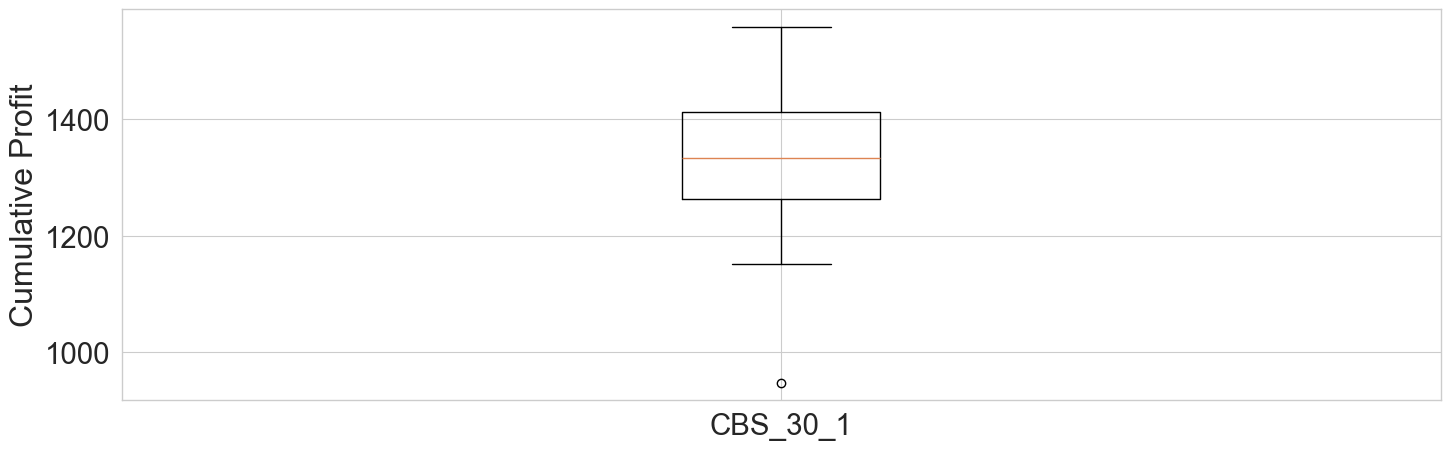

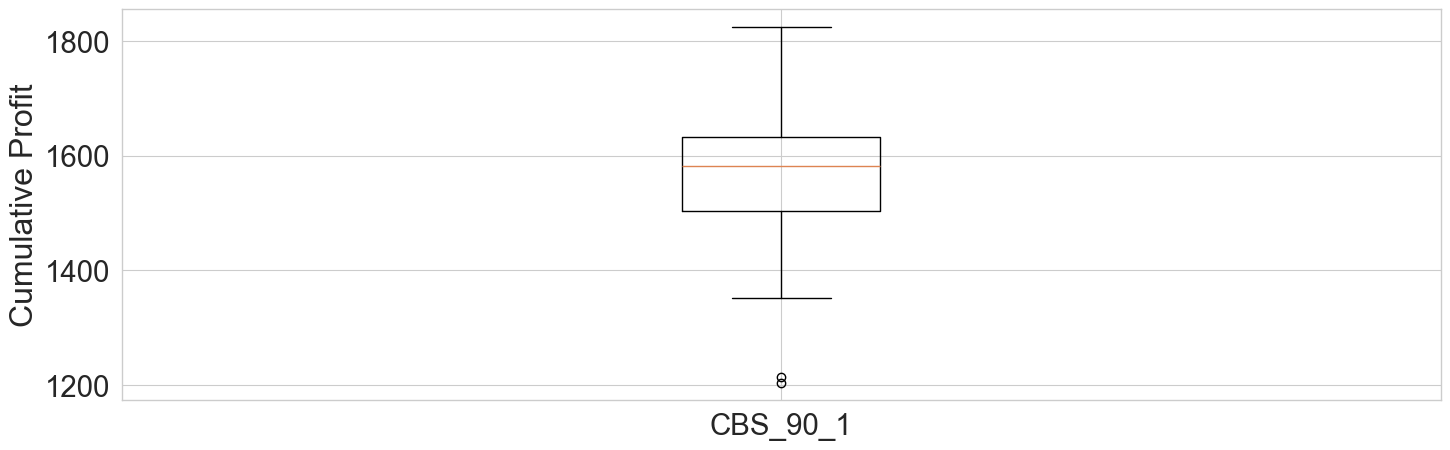

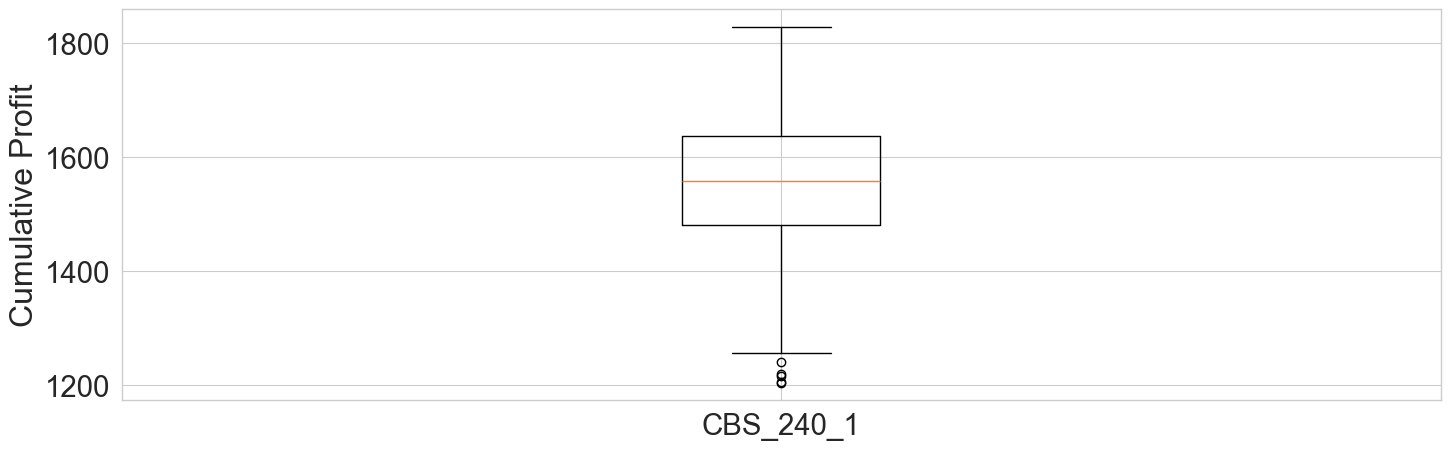

In [33]:
(best_mean_cum_profit_Ax_CBS, best_num_episodes_Ax_CBS, best_iteration_Ax_CBS,
 best_parameters_Ax_CBS, best_values_Ax_CBS, best_experiment_Ax_CBS, best_model_Ax_CBS,
 time_Ax_CBS, best_policy_Ax_CBS, best_returns_trace_Ax_CBS, best_cum_profit_Ax_CBS) = \
    optimize_Ax_CBS(num_episodes_Ax, iterations_Ax, parameters_Ax_CBS, total_trials_Ax, seed)


In [34]:
print(f"[CappedBaseStock Ax] best num episodes is {best_num_episodes_Ax_CBS} "
      f"at iteration {best_iteration_Ax_CBS+1} "
      f"\nmean cum profit: {best_mean_cum_profit_Ax_CBS}")
print("Best parameters (CBS):", best_parameters_Ax_CBS)


[CappedBaseStock Ax] best num episodes is 90 at iteration 1 
mean cum profit: 1565.727783203125
Best parameters (CBS): {'w1_S_1': 52, 'w1_C_1': 8}


In [35]:
visualize_optimization_trace_Ax_CBS(best_experiment_Ax_CBS, verbose)

In [36]:
visualize_contour_Ax_CBS(best_model_Ax_CBS, best_parameters_Ax_CBS, verbose)

In [37]:
# printing the Ax optimization time
print(f"CBS optimization time (in minutes) is {time_Ax_CBS}")

CBS optimization time (in minutes) is 5


In [38]:
# displaying and saving the Ax best parameters
display(best_parameters_Ax_CBS)
save_checkpoint_CBS(str(best_parameters_Ax_CBS), 'CBS')

{'w1_S_1': 52, 'w1_C_1': 8}

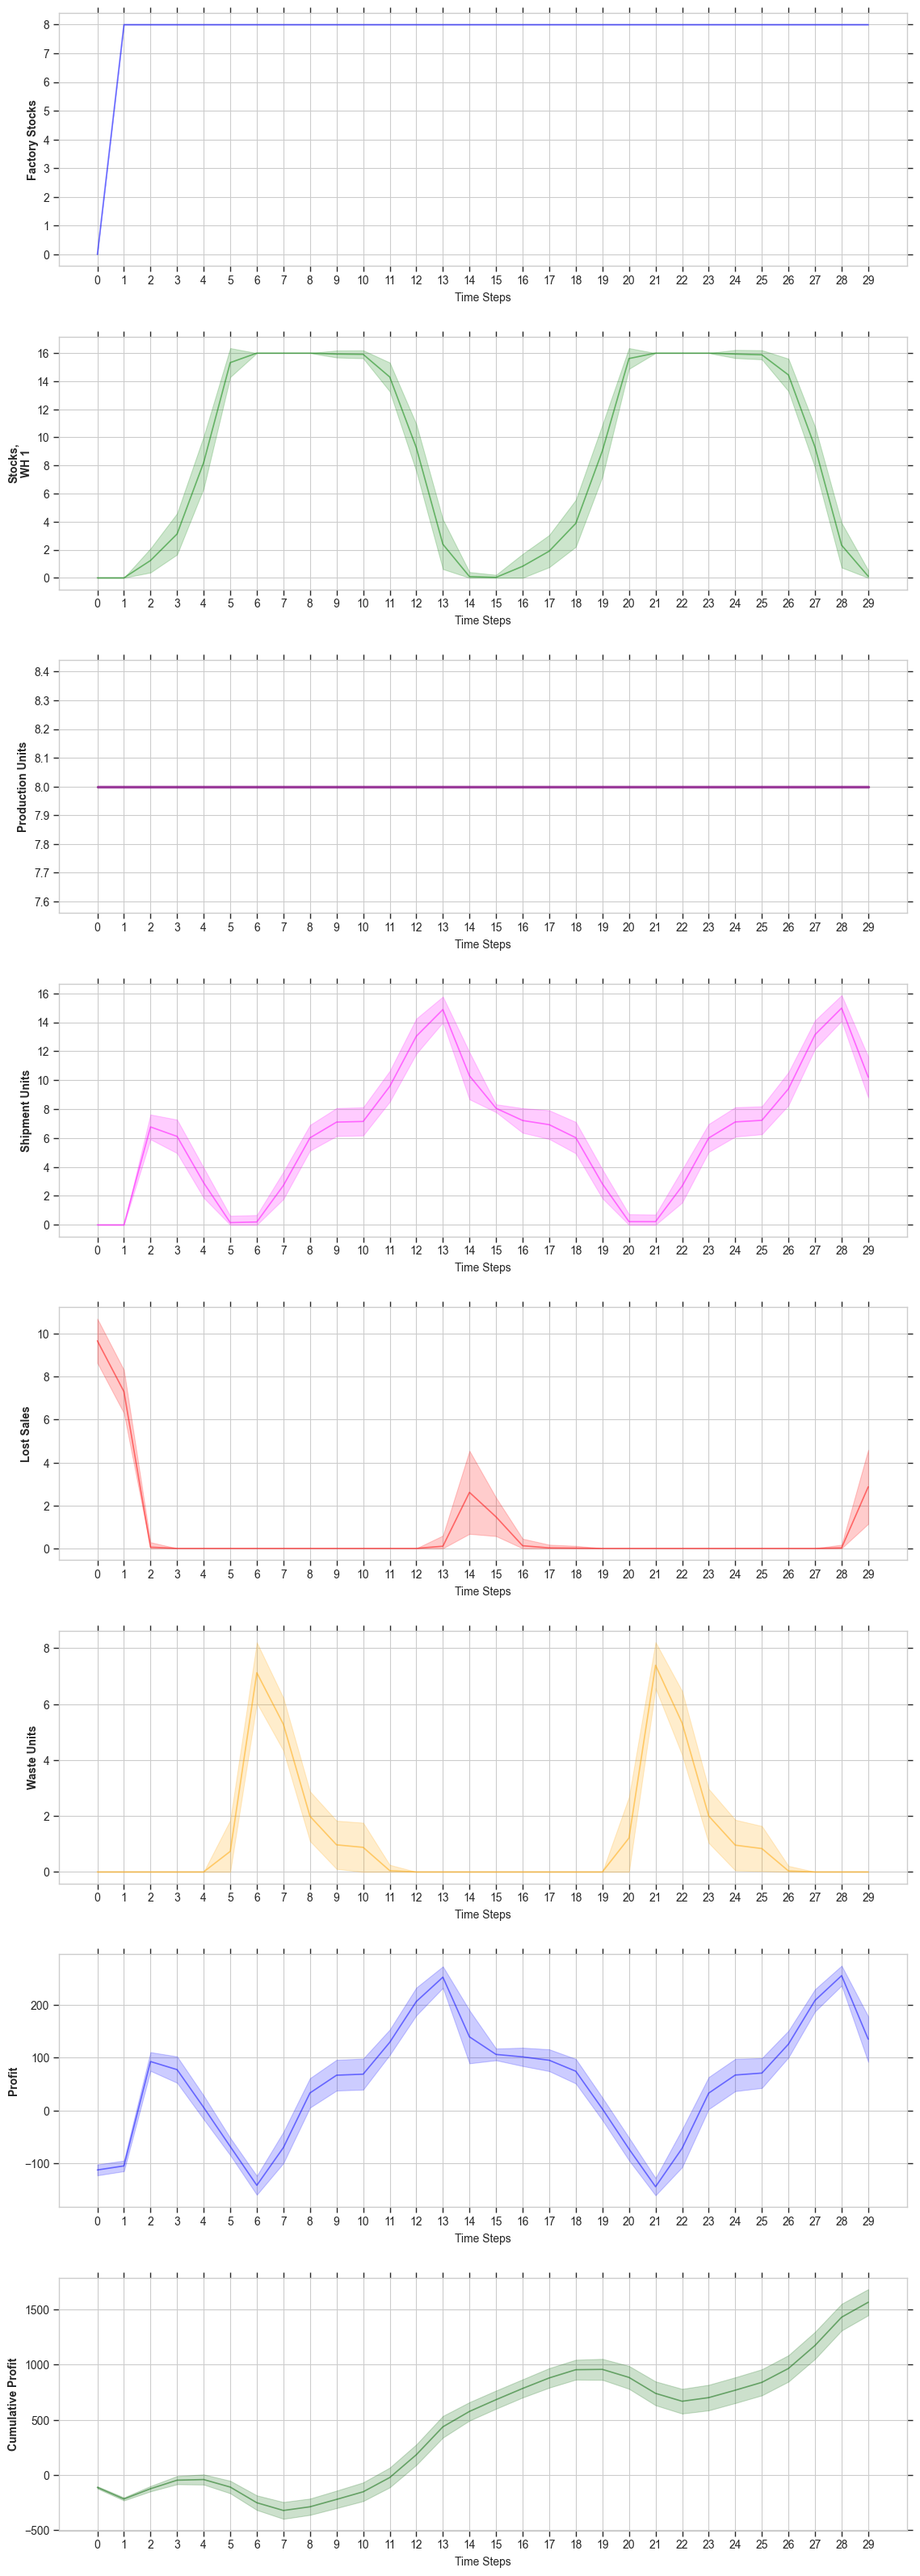

In [39]:
visualize_transitions(best_returns_trace_Ax_CBS, 'CBS')

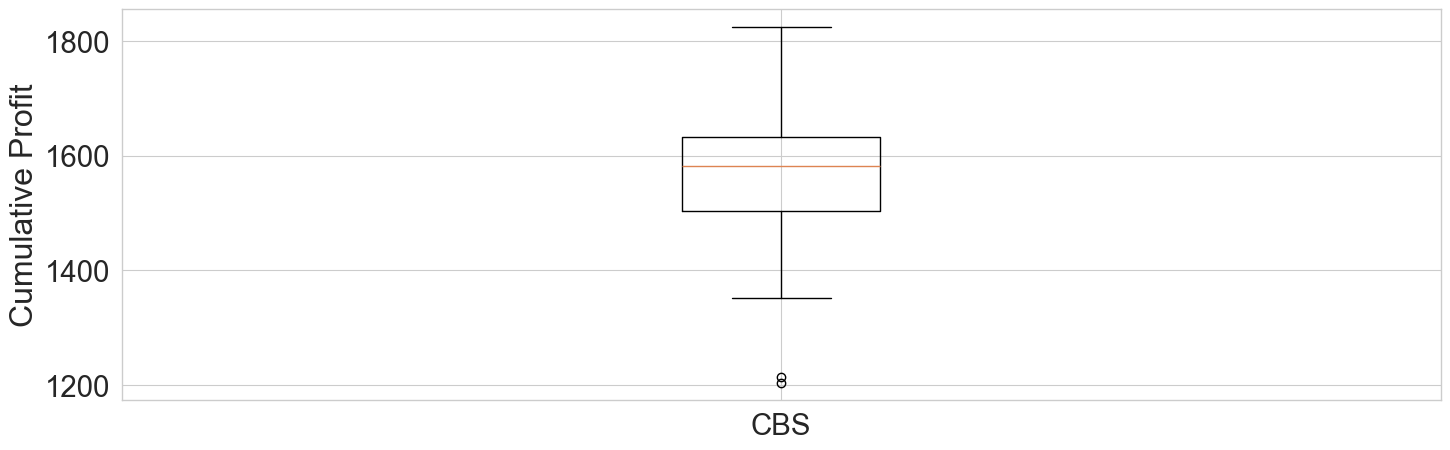

In [40]:
visualize_cum_profit(best_cum_profit_Ax_CBS, 'CBS')

In [41]:
# moving Ax optimization dirs in the main Ax dir
move_dir_Ax_CBS()

moved: 1W_ADIT_23-01-2026_06-07-57/plots\CBS_240_1
moved: 1W_ADIT_23-01-2026_06-07-57/plots\CBS_30_1
moved: 1W_ADIT_23-01-2026_06-07-57/plots\CBS_90_1


# Base-Stock Policy Methods [Ax]


## Parameters Methods BS [Ax]

In [42]:
def create_parameters_Ax_BS(env):
    """
    Create Ax parameters for Base-Stock policy.

    We keep variables minimal:
      - Tune per-warehouse base-stock S for each product.
      - Derive factory S_factory as sums over warehouses (as in policy defaults).

    Parameter bounds:
      - 0 <= S_wh[j,i] <= warehouse capacity
    """
    J = env.distr_warehouses_num
    I = env.product_types_num

    wh_cap = env.storage_capacities[1:1 + J].astype(int)  # (J, I)

    parameters = []

    for j in range(J):
        for i in range(I):
            cap_ji = int(wh_cap[j, i])

            # Base-stock target S
            parameters.append({
                "name": f"w{j+1}_S_{i+1}",
                "type": "range",
                "value_type": "int",
                "bounds": [0, cap_ji],
            })

    return parameters

def save_checkpoint_BS(checkpoint, algorithm,
                       local_dir=local_dir, plots_dir=plots_dir):
    """
    Save Ax Base-Stock (BS) policy parameters.
    """
    f = open(f"{local_dir}/{plots_dir}/{algorithm}"
             f"/best_checkpoint_{algorithm}.txt",
             'w', encoding='utf-8')
    f.write(checkpoint)
    f.close()


## Optimize Methods BS [Ax]

In [ ]:
def calculate_cum_profit(returns_trace):
    """Total episode reward."""
    return np.array([np.sum([t['reward'] for t in episode])
                     for episode in returns_trace], dtype=np.float32)

# Global (compatibility)
num_episodes_current = 200

def opt_func_Ax_BS(p, num_episodes=200): 
    """
    Local episodes + logging.
    """
    try:
        J, I = env.distr_warehouses_num, env.product_types_num

        # Build S_wh
        S_wh = np.zeros((J, I), dtype=np.int32)
        for j in range(J):
            for i in range(I):
                S_wh[j, i] = int(p[f"w{j+1}_S_{i+1}"])

        S_factory = np.sum(S_wh, axis=0).astype(np.int32)

        policy = BaseStockPolicy(env, S_wh=S_wh, S_factory=S_factory)

        returns_trace = simulate(env_config, policy, num_episodes)
        cum_profit = calculate_cum_profit(returns_trace)
        mean_val = float(np.mean(cum_profit))
        sem = float(np.std(cum_profit) / np.sqrt(len(cum_profit))) if len(cum_profit) > 1 else 0.0

        logger.info(f"BS trial: {num_episodes} eps, mean={mean_val:.1f}±{sem:.1f}")
        return mean_val, sem

    except Exception as e:
        logger.exception(f"BS failed: {e}")
        return -1e12, 0.0

def optimize_Ax_BS(num_episodes_Ax, iterations_Ax, parameters_Ax,
                  total_trials_Ax, seed):
    """
    Pass num_episodes + early convergence.
    """
    best_mean_cum_profit_Ax = None
    prev_params = None

    for num_episodes in num_episodes_Ax:
        num_episodes_current = int(num_episodes)  # Compatibility

        for iteration in range(iterations_Ax):
            start_Ax = default_timer()

            # Lambda passes num_episodes
            parameters, values, experiment, model = optimize(
                parameters=parameters_Ax,
                evaluation_function=lambda p: opt_func_Ax_BS(p, int(num_episodes)),
                objective_name='episode_reward_mean', minimize=False,
                total_trials=total_trials_Ax, random_seed=seed
            )

            # Early stop
            if iteration > 0 and parameters == prev_params:
                logger.info(f"BS converged early at iter {iteration}")
                break
            prev_params = parameters

            end_Ax = default_timer()
            time_Ax = int((end_Ax - start_Ax) // 60)

            # Rebuild best policy
            J, I = env.distr_warehouses_num, env.product_types_num
            S_wh = np.zeros((J, I), dtype=np.int32)
            for j in range(J):
                for i in range(I):
                    S_wh[j, i] = int(parameters[f"w{j+1}_S_{i+1}"])

            S_factory = np.sum(S_wh, axis=0).astype(np.int32)
            policy_Ax = BaseStockPolicy(env, S_wh=S_wh, S_factory=S_factory)

            returns_trace_Ax = simulate(env_config, policy_Ax, num_episodes)
            print(f"--num episodes: {num_episodes}, iteration: {iteration+1}")

            cum_profit_Ax = calculate_cum_profit(returns_trace_Ax)
            visualize_cum_profit(cum_profit_Ax, f"BS_{num_episodes}_{iteration+1}")

            # Best tracking
            if (best_mean_cum_profit_Ax is None or
                np.mean(cum_profit_Ax) > best_mean_cum_profit_Ax):
                best_mean_cum_profit_Ax = np.mean(cum_profit_Ax)
                best_num_episodes = num_episodes
                best_iteration = iteration
                best_parameters = parameters
                best_values = values
                best_experiment = experiment
                best_model = model
                best_policy_Ax = policy_Ax
                best_returns_trace_Ax = returns_trace_Ax
                best_cum_profit_Ax = cum_profit_Ax

    logger.debug(f"Best BS: {best_mean_cum_profit_Ax:.1f} (ep={best_num_episodes}, iter={best_iteration})")

    return (best_mean_cum_profit_Ax, best_num_episodes, best_iteration,
            best_parameters, best_values, best_experiment, best_model,
            time_Ax, best_policy_Ax, best_returns_trace_Ax, best_cum_profit_Ax)


## Visualize Rewards Methods BS [Ax]

In [44]:
def visualize_optimization_trace_Ax_BS(experiment, verbose,
                                       local_dir=local_dir, plots_dir=plots_dir):
    """
    Plot the mean reward along the trials iterations for BS.
    """
    try:
        best_objectives = np.array(
            [[trial.objective_mean
              for trial in experiment.trials.values()]]
        )

        best_objective_plot = optimization_trace_single_method_plotly(
            y=np.maximum.accumulate(best_objectives, axis=1),
            ylabel='Reward Mean',
            title='BS Performance vs. Trials Iterations'
        )

        if verbose == 3:
            best_objective_plot.show()

        # create BS dir
        if not os.path.exists(f"{local_dir}/{plots_dir}/BS"):
            os.makedirs(f"{local_dir}/{plots_dir}/BS")

        best_objective_plot.write_image(
            f"{local_dir}/{plots_dir}/BS/optimization_trace.pdf"
        )

    except Exception as e:
        print(f"{e.__class__} occurred!")

def visualize_contour_Ax_BS(model, parameters, verbose,
                            local_dir=local_dir, plots_dir=plots_dir):
    """
    Plot contour plots for BS (episode_reward_mean vs pairs of parameters).
    """
    try:
        if not os.path.exists(f"{local_dir}/{plots_dir}/BS/contours"):
            os.makedirs(f"{local_dir}/{plots_dir}/BS/contours")

        param_names = list(parameters)

        for p in range(0, len(param_names) - 1, 2):
            contour = plot_contour_plotly(
                model=model,
                metric_name='episode_reward_mean',
                param_x=param_names[p],
                param_y=param_names[p + 1]
            )

            contour.write_image(
                f"{local_dir}/{plots_dir}/BS/contours/"
                f"contour_{param_names[p]}_{param_names[p + 1]}.pdf"
            )

            if verbose == 3:
                contour.show()

        if verbose == 3:
            render(interact_contour(model=model,
                                    metric_name='episode_reward_mean'))

    except Exception as e:
        print(f"{e.__class__} occurred!")

def move_dir_Ax_BS(local_dir=local_dir, plots_dir=plots_dir):
    """
    Move dirs whose name starts with 'BS_' (related to all BS optimizations)
    into the main BS dir.
    """
    try:
        src_dir = f"{local_dir}/{plots_dir}/"
        dst_dir = f"{local_dir}/{plots_dir}/BS"

        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)

        pattern = src_dir + "BS_*"
        for file in glob.iglob(pattern, recursive=True):
            shutil.move(file, dst_dir)
            print('moved:', file)

    except Exception as e:
        print(f"{e.__class__} occurred!")


## BS Policy Optimize [Ax]

In [45]:
# Ax parameters
parameters_Ax_BS = create_parameters_Ax_BS(env)
parameters_Ax_BS

[{'name': 'w1_S_1', 'type': 'range', 'value_type': 'int', 'bounds': [0, 60]}]

[INFO 01-23 06:16:14] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 01-23 06:16:14] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 5 trials, BoTorch for subsequent trials]). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 01-23 06:16:14] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 01-23 06:16:14] ax.service.managed_loop: Running optimization trial 1...
[INFO 01-23 06:16:15] ax.service.managed_loop: Running optimization trial 2...
[INFO 01-23 06:16:16] ax.service.managed_loop: Running optimization trial 3...
[INFO 01-23 06:16:17] ax.service.managed_loop: Running optimization trial 4...
[INFO 01-23 06:16:18] ax.service.managed_loop: Running optimization trial 5...
[INFO 01-23 06:16:19] ax.service.managed_loop

--num episodes: 30, iteration: 1


[INFO 01-23 06:17:05] ax.service.managed_loop: Running optimization trial 2...
[INFO 01-23 06:17:08] ax.service.managed_loop: Running optimization trial 3...
[INFO 01-23 06:17:11] ax.service.managed_loop: Running optimization trial 4...
[INFO 01-23 06:17:12] ax.service.managed_loop: Running optimization trial 5...
[INFO 01-23 06:17:14] ax.service.managed_loop: Running optimization trial 6...
[INFO 01-23 06:17:18] ax.service.managed_loop: Running optimization trial 7...
[INFO 01-23 06:17:20] ax.service.managed_loop: Running optimization trial 8...
[INFO 01-23 06:17:22] ax.service.managed_loop: Running optimization trial 9...
[INFO 01-23 06:17:25] ax.service.managed_loop: Running optimization trial 10...
[INFO 01-23 06:17:27] ax.service.managed_loop: Running optimization trial 11...
[INFO 01-23 06:17:29] ax.service.managed_loop: Running optimization trial 12...
[INFO 01-23 06:17:31] ax.service.managed_loop: Running optimization trial 13...
[INFO 01-23 06:17:32] ax.service.managed_loop: R

--num episodes: 90, iteration: 1


[INFO 01-23 06:18:45] ax.service.managed_loop: Running optimization trial 2...
[INFO 01-23 06:18:50] ax.service.managed_loop: Running optimization trial 3...
[INFO 01-23 06:18:55] ax.service.managed_loop: Running optimization trial 4...
[INFO 01-23 06:18:59] ax.service.managed_loop: Running optimization trial 5...
[INFO 01-23 06:19:05] ax.service.managed_loop: Running optimization trial 6...
[INFO 01-23 06:19:10] ax.service.managed_loop: Running optimization trial 7...
[INFO 01-23 06:19:14] ax.service.managed_loop: Running optimization trial 8...
[INFO 01-23 06:19:20] ax.service.managed_loop: Running optimization trial 9...
[INFO 01-23 06:19:25] ax.service.managed_loop: Running optimization trial 10...
[INFO 01-23 06:19:31] ax.service.managed_loop: Running optimization trial 11...
[INFO 01-23 06:19:35] ax.service.managed_loop: Running optimization trial 12...
[INFO 01-23 06:19:42] ax.service.managed_loop: Running optimization trial 13...
[INFO 01-23 06:19:46] ax.service.managed_loop: R

--num episodes: 240, iteration: 1


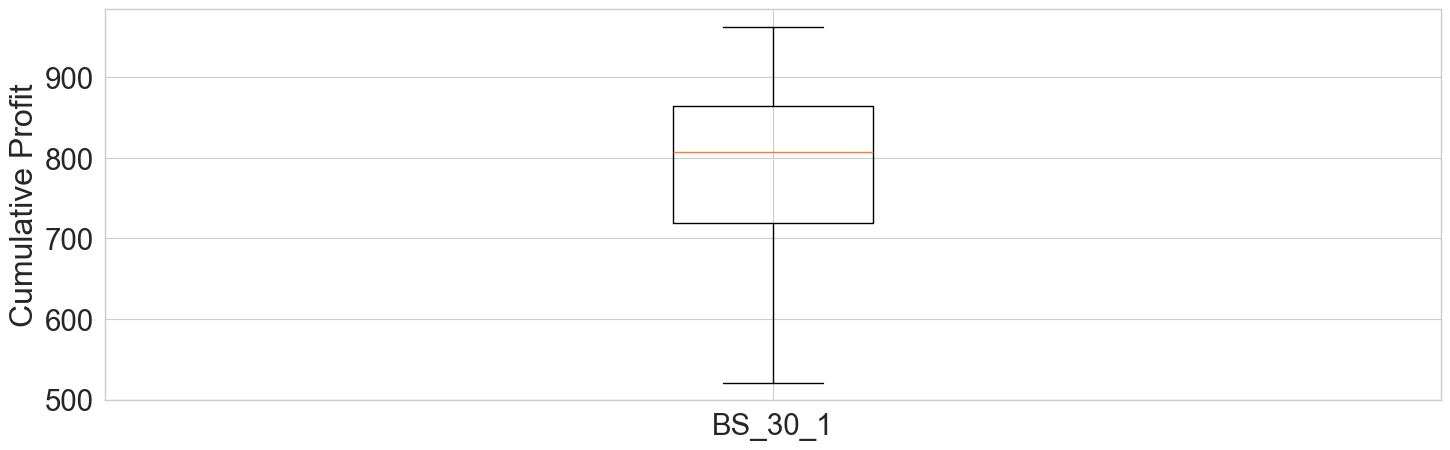

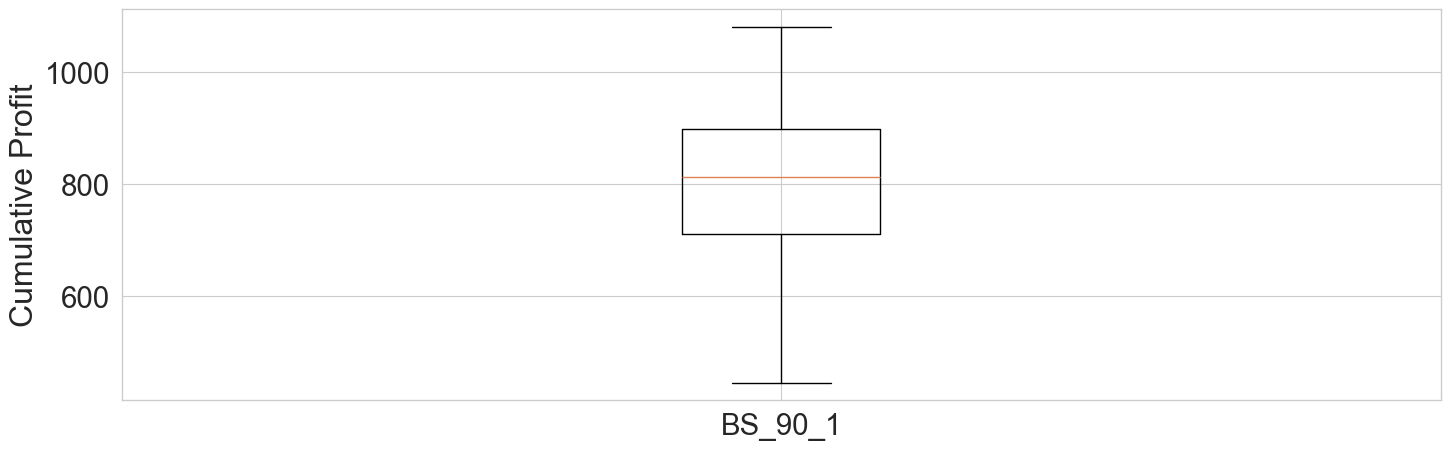

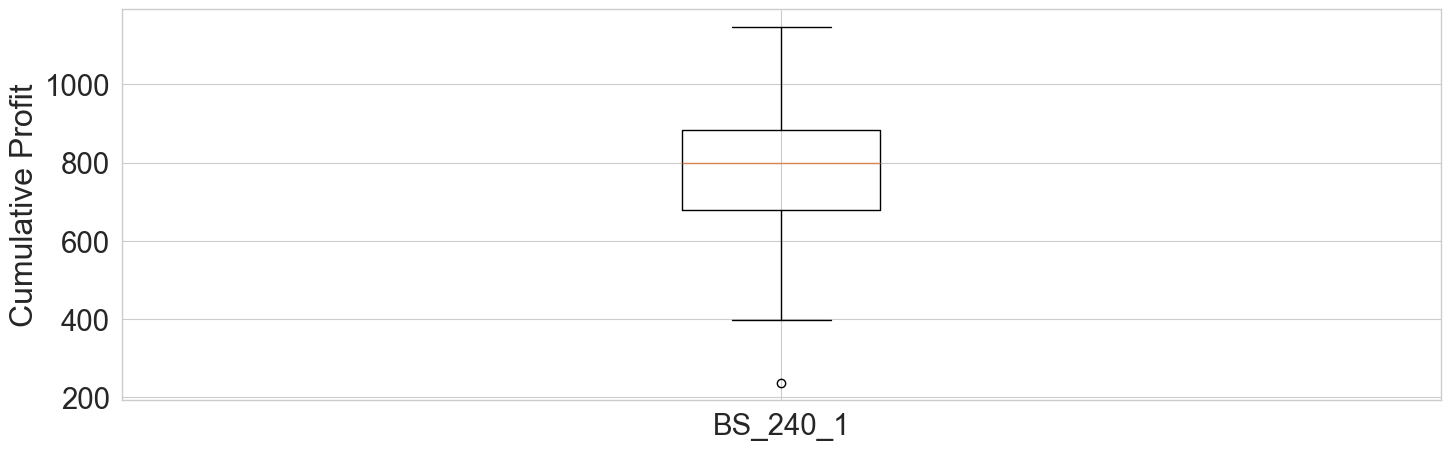

In [46]:
(best_mean_cum_profit_Ax_BS, best_num_episodes_Ax_BS, best_iteration_Ax_BS,
 best_parameters_Ax_BS, best_values_Ax_BS, best_experiment_Ax_BS, best_model_Ax_BS,
 time_Ax_BS, best_policy_Ax_BS, best_returns_trace_Ax_BS, best_cum_profit_Ax_BS) = \
    optimize_Ax_BS(num_episodes_Ax, iterations_Ax, parameters_Ax_BS, total_trials_Ax, seed)


In [47]:
print(f"[BaseStock Ax] best num episodes is {best_num_episodes_Ax_BS} "
      f"with related best mean cum profit is {best_mean_cum_profit_Ax_BS}")
display(best_parameters_Ax_BS)


[BaseStock Ax] best num episodes is 90 with related best mean cum profit is 796.70556640625


{'w1_S_1': 15}

In [48]:
visualize_optimization_trace_Ax_BS(best_experiment_Ax_BS, verbose)

In [49]:
visualize_contour_Ax_BS(best_model_Ax_BS, best_parameters_Ax_BS, verbose)

In [50]:
# printing the Ax optimization time
print(f"BS optimization time (in minutes) is {time_Ax_BS}")

BS optimization time (in minutes) is 4


In [51]:
# displaying and saving the Ax best parameters
display(best_parameters_Ax_BS)
save_checkpoint_BS(str(best_parameters_Ax_BS), 'BS')

{'w1_S_1': 15}

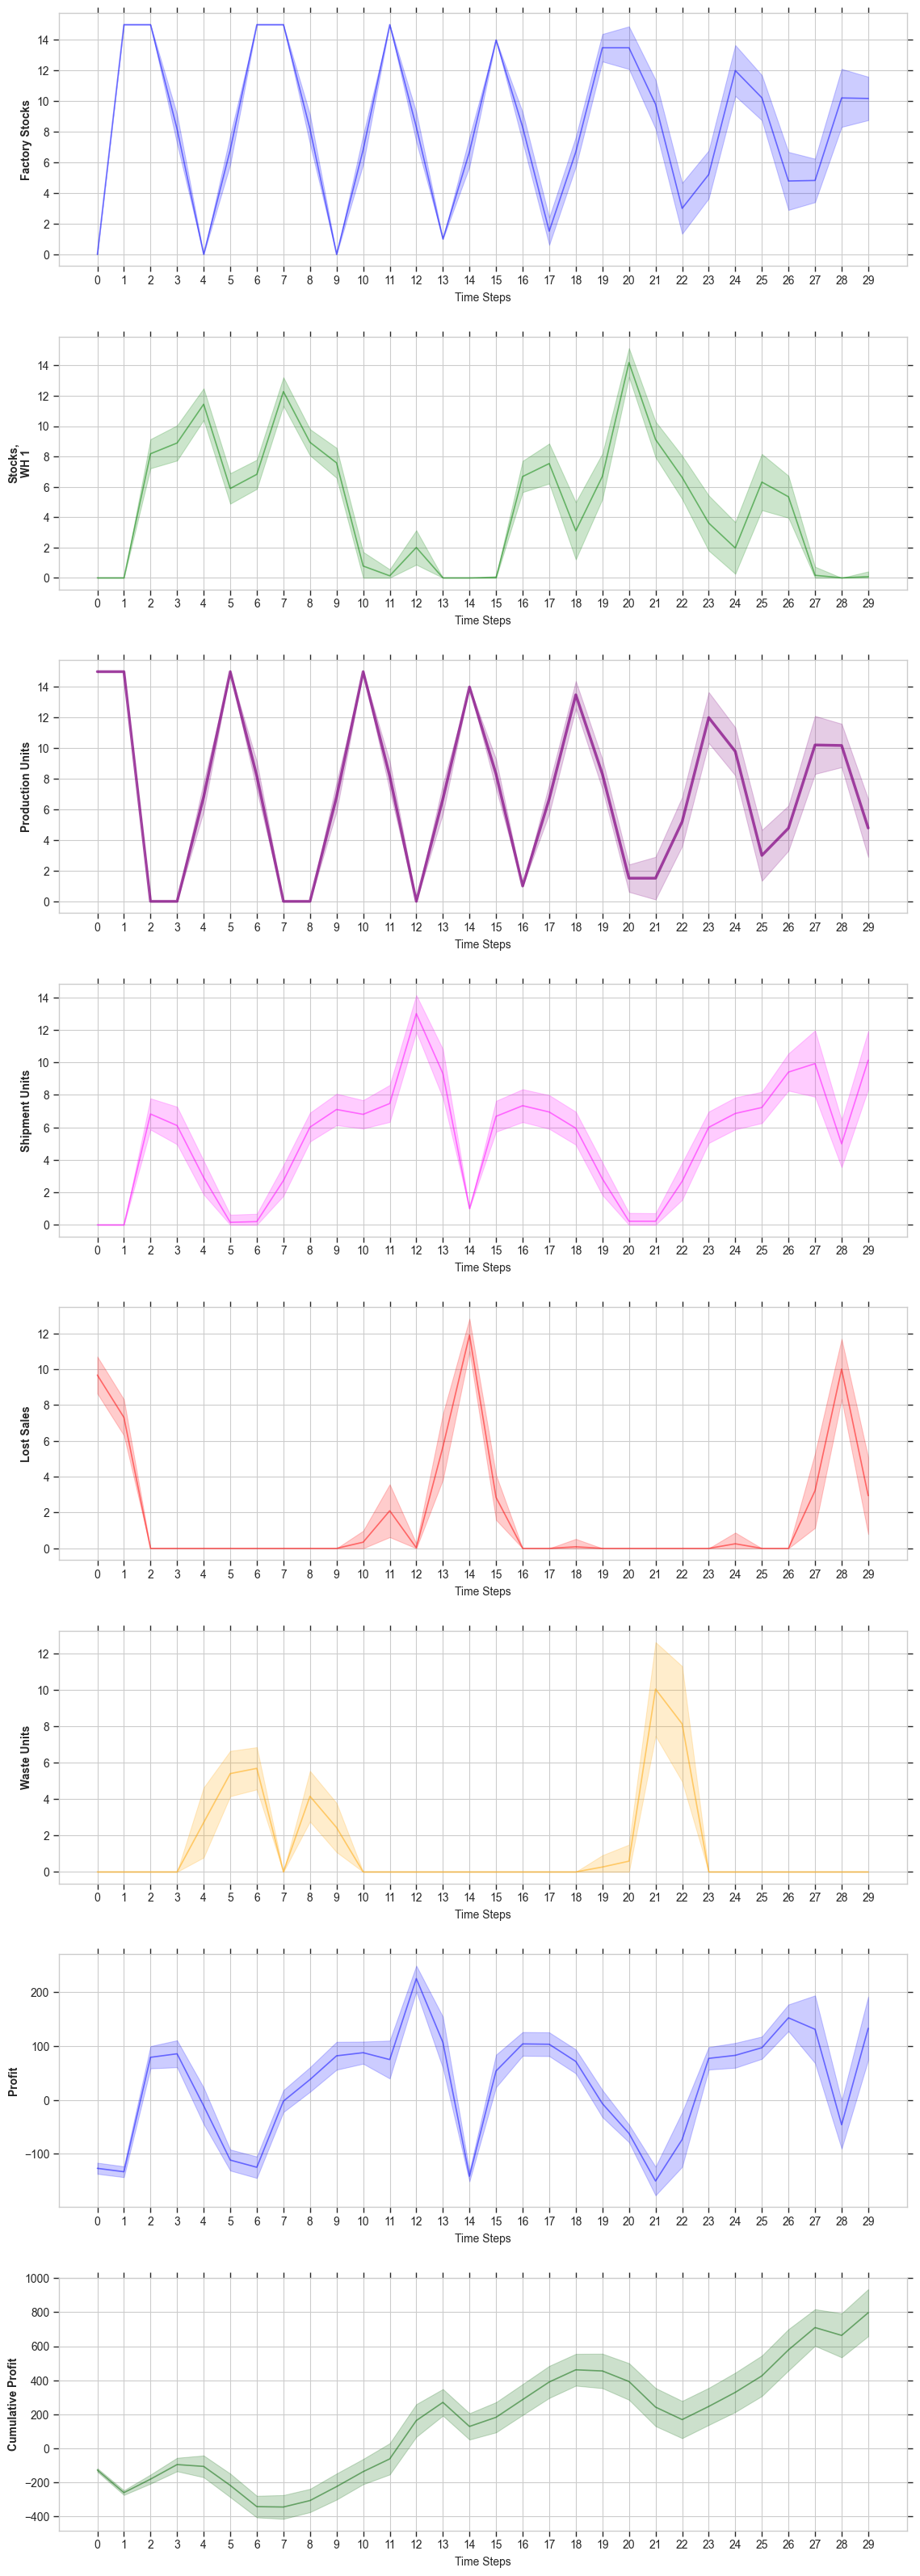

In [52]:
visualize_transitions(best_returns_trace_Ax_BS, 'BS')

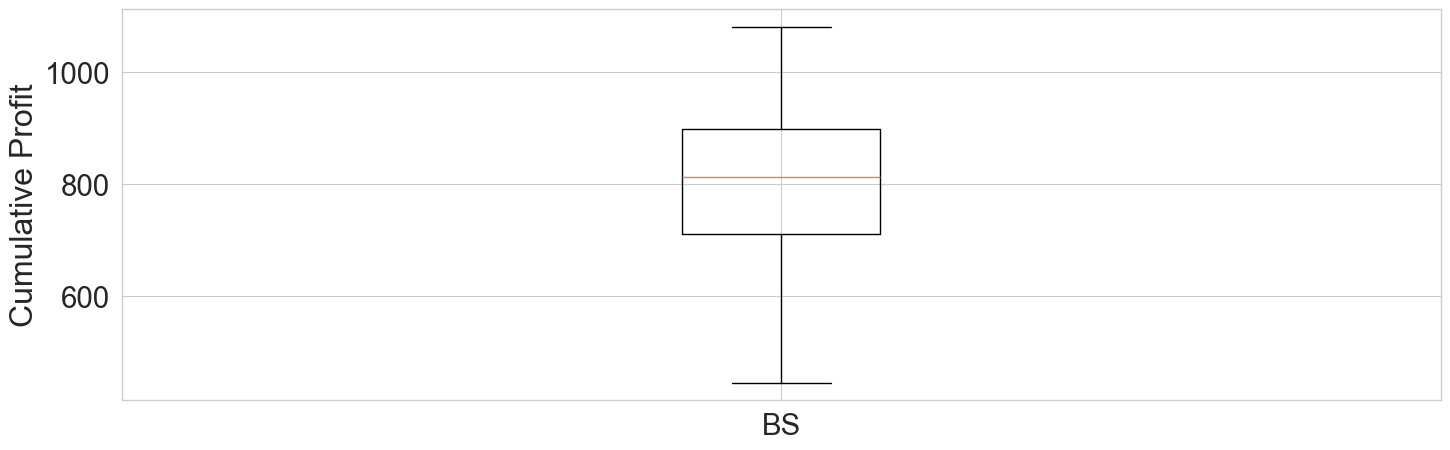

In [53]:
visualize_cum_profit(best_cum_profit_Ax_BS, 'BS')

In [54]:
# moving Ax optimization dirs in the main Ax dir
move_dir_Ax_BS()

moved: 1W_ADIT_23-01-2026_06-07-57/plots\BS_240_1
moved: 1W_ADIT_23-01-2026_06-07-57/plots\BS_30_1
moved: 1W_ADIT_23-01-2026_06-07-57/plots\BS_90_1


# Reinforcement Learning Config [Tune]

## Parameters [Tune]

In [ ]:
# Training
desired_iterations = 30
train_batch_size   = 12000  # from PPO config

num_timesteps_ray = desired_iterations * train_batch_size
grace_timesteps_ray = num_timesteps_ray // 10   # ASHA grace period (10%)


In [56]:
# dir for saving Ray results
ray_dir = 'ray_results'
# creating necessary dir
if not os.path.exists(f"{local_dir+'/'+ray_dir}"):
    os.makedirs(f"{local_dir+'/'+ray_dir}")

## Algorithms [Tune]

In [57]:
from ray.rllib.algorithms.ppo import PPOConfig

algorithms = {
    "PPO": PPOConfig
}


## PPO Config [Tune]

In [ ]:
NUM_CPUS = 22

config = (
    PPOConfig()
    .framework("torch")
    .debugging(seed=2021, log_level="WARN")

    .environment(
        env=SupplyChainGym,
        env_config=env_config,
        normalize_actions=True, # action is scaled for easier learning, set True.
        clip_actions=True,
    )

    .env_runners(
        num_env_runners=18,
        num_envs_per_env_runner=1,
        rollout_fragment_length=30,
        batch_mode="complete_episodes",
        sample_timeout_s=120.0,
    )

    .training(
        gamma=0.99,
        lr=7e-5,                 # for stability
        use_gae=True,
        lambda_=0.95,
        use_critic=True,
        clip_param=0.2,
        vf_clip_param=1000.0,    # rewards are in the thousands (profit)
        vf_loss_coeff=0.5,
        entropy_coeff=0.003,     # less random
        kl_coeff=0.0,
        kl_target=0.02,
        train_batch_size=12000,
        sgd_minibatch_size=512,  # divisible by train_batch_size
        num_sgd_iter=10,
        shuffle_sequences=True,
        grad_clip=0.5,
        model={
            "fcnet_hiddens": [256, 256],
            "fcnet_activation": "tanh",
            "vf_share_layers": False,
        },
    )

    .evaluation(
        evaluation_interval=10,
        evaluation_duration=20,
        evaluation_duration_unit="episodes",
        evaluation_num_env_runners=0,       # run eval on driver
        evaluation_parallel_to_training=False,
    )

    .resources(num_gpus=0)
)


# Reinforcement Learning Methods [Tune]

## Train Agents Methods [Tune]

In [59]:
import os
import ray
import numpy as np

from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import ASHAScheduler
from ray.tune import TuneConfig
from ray.air import RunConfig
from ray.air.config import CheckpointConfig


def train(algorithm, config, verbose,
          num_timesteps_ray=num_timesteps_ray,
          grace_timesteps_ray=grace_timesteps_ray,
          local_dir=local_dir, ray_dir=ray_dir):
    """
    Train an RLlib Agent (Ray 2.x Tune API) with a PAPER-FAITHFUL training budget:
      - early stop + cap based on env interaction (timesteps_total), not iterations.
    Returns: (trial_df, best_result_df, best_config, best_checkpoint_path)
    """
    ray.shutdown()
    ray.init(log_to_driver=False)

    storage_path = os.path.join(os.getcwd(), local_dir, ray_dir)

    # Ray 2.x RLlib reports episode metrics under "env_runners/..."
    metric = "env_runners/episode_reward_mean"

    # ASHA: compare trials fairly by the SAME amount of env interaction
    scheduler = ASHAScheduler(
        time_attr="timesteps_total",
        max_t=num_timesteps_ray,
        grace_period=grace_timesteps_ray,
        reduction_factor=5,
    )

    tuner = Tuner(
        trainable=algorithm,
        param_space=config,
        tune_config=TuneConfig(
            metric=metric,
            mode="max",
            scheduler=scheduler,
        ),
        run_config=RunConfig(
            storage_path=storage_path,
            verbose=verbose,
            stop={"timesteps_total": num_timesteps_ray},
            checkpoint_config=CheckpointConfig(
                checkpoint_frequency=10,
                num_to_keep=1,
                checkpoint_score_attribute=metric,
                checkpoint_score_order="max",
            ),
        ),
    )

    results = tuner.fit()

    # Best trial result
    best = results.get_best_result(metric=metric, mode="max")
    best_config = best.config

    best_checkpoint_path = None

    if best.checkpoint is not None:
        best_checkpoint_path = best.checkpoint.to_directory()
    print(f"\ncheckpoint saved at {best_checkpoint_path}")

    trial_df = results.get_dataframe()
    try:
        import pandas as pd
        best_result_df = pd.DataFrame([best.metrics])
    except Exception:
        best_result_df = best.metrics

    ray.shutdown()
    return trial_df, best_result_df, best_config, best_checkpoint_path


In [60]:
def save_checkpoint_PPO(checkpoint, algorithm,
                        local_dir=local_dir, plots_dir=plots_dir):
    """
    Save PPO policy parameters.
    """
    f = open(f"{local_dir}/{plots_dir}/{algorithm}"
             f"/best_checkpoint_{algorithm}.txt",
             'w', encoding='utf-8')
    f.write(checkpoint)
    f.close()

## Policy Methods [Tune]

In [ ]:
import ray
from ray.rllib.algorithms.algorithm import Algorithm


def load_policy(algorithm, config, checkpoint_path, start_ray=True):
    """
    Ray 2.x-compatible loader.

    Parameters
    ----------
    checkpoint_path : str
        Directory path returned by `best.checkpoint.to_directory()`.
    start_ray : bool
        If True, calls ray.init() (safe if not already initialized).

    Returns
    -------
    algo : Algorithm
    policy : Any 
    """
    if start_ray:
        if ray.is_initialized():
            ray.shutdown()
        ray.init(log_to_driver=False)

    # Restore
    algo = Algorithm.from_checkpoint(checkpoint_path)

    # Try to fetch policy
    try:
        policy = algo.get_policy()
    except Exception:
        policy = None

    logger.debug(
        f"\n-- load_policy (Ray 2.x) --"
        f"\nalgorithm is {algorithm}"
        f"\nconfig is {config}"
        f"\ncheckpoint_path is {checkpoint_path}"
        f"\nalgo is {algo}"
        f"\npolicy is {policy}"
    )

    return algo, policy

def close_ray():
    if ray.is_initialized():
        ray.shutdown()

def fix_best_checkpoint(checkpoint_path):
    logger.debug(f"\n-- fix_best_checkpoint (Ray 2.x) --"
                 f"\ncheckpoint_path is {checkpoint_path}")

    return checkpoint_path


## Visualize Rewards Methods [Tune]

In [ ]:
import matplotlib.ticker as ticker


def apply_style_plot(ax, x_max):
    """Style x-axis for training iterations."""
    labels = [str(0), str(x_max // 2), str(x_max)]
    ax.xaxis.set_major_locator(ticker.LinearLocator(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Training Iterations")
    ax.ticklabel_format(axis="y", style="plain", useOffset=False)


def _as_list_of_dfs(results):
    """
    Accept:
    - dict[name -> df]   (Ray 1.x style)
    - pd.DataFrame       (Ray 2.x ResultGrid.get_dataframe())
    - list[df]
    Return: list[df]
    """
    try:
        import pandas as pd
    except Exception:
        pd = None

    if isinstance(results, dict):
        return list(results.values())
    if pd is not None and isinstance(results, pd.DataFrame):
        return [results]
    if isinstance(results, list):
        return results
    return [results]


def visualize_rewards(results, best_result, algorithm, legend=None,
                      local_dir=local_dir, plots_dir=plots_dir):
    """
    Visualize min/mean/max rewards over training iterations (Ray 2.x).

    Ray 2.x RLlib reports these columns:
      - env_runners/episode_reward_min
      - env_runners/episode_reward_mean
      - env_runners/episode_reward_max
    """
    legend = legend or []
    out_dir = f"{local_dir}/{plots_dir}/{algorithm}"
    os.makedirs(out_dir, exist_ok=True)

    # Determine x-axis max
    try:
        x_max = int(best_result["training_iteration"].iloc[0])
    except Exception:
        x_max = int(best_result.get("training_iteration", 0))

    dfs = _as_list_of_dfs(results)

    def _plot_metric(col, ylabel, filename):
        fig, ax = plt.subplots(figsize=(15, 5))
        apply_style_plot(ax, x_max)
        ax.set_ylabel(ylabel)

        for df in dfs:
            if col in df.columns:
                df[col].plot(ax=ax)

        if legend:
            ax.legend(
                legend,
                bbox_to_anchor=(1.04, 0.5),
                borderaxespad=0,
                frameon=False,
                loc="center left",
                fancybox=True,
                shadow=True,
            )

        plt.tight_layout()
        plt.savefig(f"{out_dir}/{filename}_{algorithm}.pdf",
                    format="pdf", bbox_inches="tight")
        plt.close(fig)

    _plot_metric("env_runners/episode_reward_min", "Min Reward", "episode_reward_min")
    _plot_metric("env_runners/episode_reward_mean", "Mean Reward", "episode_reward_mean")
    _plot_metric("env_runners/episode_reward_max", "Max Reward", "episode_reward_max")

# Reinforcement Learning Train Agents [Tune]

## PPO Agent [Tune]

In [63]:
# Train PPO
(results,
 best_result_PPO,
 best_config_PPO,
 checkpoint_PPO) = train(
    algorithm="PPO",
    config=config.to_dict(),
    verbose=verbose
)


2026-01-23 06:23:41,444	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_cpus_per_worker` has been deprecated. Use `AlgorithmConfig.num_cpus_per_env_runner` instead. This will raise an error in the future!
2026-01-23 06:23:41,445	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_gpus_per_worker` has been deprecated. Use `AlgorithmConfig.num_gpus_per_env_runner` instead. This will raise an error in the future!
2026-01-23 06:23:41,445	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_learner_workers` has been deprecated. Use `AlgorithmConfig.num_learners` instead. This will raise an error in the future!
2026-01-23 06:23:41,446	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_cpus_per_learner_worker` has been deprecated. Use `AlgorithmConfig.num_cpus_per_learner` instead. This will raise an error in the future!
2026-01-23 06:23:41,447	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_gpus


checkpoint saved at C:\Users\ADITYA~1\AppData\Local\Temp\checkpoint_tmp_9cafea7144f64cdba27e7448761fa77d


In [64]:
def result_df_as_image(result_df, algorithm,
                       local_dir=local_dir, plots_dir=plots_dir):
    """
    Visualize the (DataFrame) RLib Agent's result as an image.
    """
    # creating necessary subdir and saving plot
    if not os.path.exists(f"{local_dir}/{plots_dir}/{algorithm}"):
        os.makedirs(f"{local_dir}/{plots_dir}/{algorithm}")
    dfi.export(result_df.iloc[:, np.r_[:3, 9]],
               f"{local_dir}/{plots_dir}/{algorithm}"
               f"/best_result_{algorithm}.png",
               table_conversion='matplotlib')

In [65]:
# saving and showing the best result of the PPO agent
result_df_as_image(best_result_PPO, 'PPO')
best_result_PPO

evaluation custom_metrics  \
0  {'env_runners': {'episode_reward_max': 1725.5,...             {}   

  episode_media                                               info  \
0            {}  {'learner': {'default_policy': {'learner_stats...   

                                         env_runners  num_healthy_workers  \
0  {'episode_reward_max': 2333.0, 'episode_reward...                   18   

   num_in_flight_async_sample_reqs  num_remote_worker_restarts  \
0                                0                           0   

   num_agent_steps_sampled  num_agent_steps_trained  ...  time_this_iter_s  \
0                   360180                   360180  ...          7.997661   

   time_total_s    pid  hostname    node_ip  \
0    229.164583  25704    ADITYA  127.0.0.1   

                                              config  time_since_restore  \
0  {'extra_python_environs_for_driver': {}, 'extr...          229.164583   

   iterations_since_restore  \
0                        29   

                                                perf  experiment_tag  
0  {'cpu_util_percent': 42.19166666666667, 'ram_u...               0  

[1 rows x 38 columns]

In [66]:
best_result_PPO_metrics = best_result_PPO.iloc[0].to_dict()
best_result_PPO_metrics

{'evaluation': {'env_runners': {'episode_reward_max': 1725.5,
   'episode_reward_min': -162.5,
   'episode_reward_mean': 1106.725,
   'episode_len_mean': 30.0,
   'episode_media': {},
   'episodes_timesteps_total': 600,
   'policy_reward_min': {},
   'policy_reward_max': {},
   'policy_reward_mean': {},
   'custom_metrics': {},
   'hist_stats': {'episode_reward': [-162.5,
     1670.5,
     1494.0,
     1004.5,
     1691.5,
     157.0,
     771.0,
     1633.5,
     69.5,
     628.0,
     907.0,
     908.5,
     1447.5,
     1135.5,
     1596.0,
     1187.0,
     1725.5,
     1270.0,
     1446.0,
     1554.5],
    'episode_lengths': [30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30,
     30]},
   'sampler_perf': {'mean_raw_obs_processing_ms': 0.30020770184900436,
    'mean_inference_ms': 0.9672115684845963,
    'mean_action_processing_ms': 0.17156430227770392,
    'mean_env

In [67]:
visualize_rewards(results, best_result_PPO, 'PPO')

C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\1438647556.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\1438647556.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\1438647556.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



In [68]:
def calculate_training_time(result_df):
    """
    Calculate RLlib training time (minutes).

    Works with:
    - pd.DataFrame (best_result_df built as 1-row DF)
    - dict-like metrics
    """
    try:
        return int(float(result_df["time_total_s"].iloc[0]) // 60)
    except Exception:
        return int(float(result_df.get("time_total_s", 0.0)) // 60)

In [69]:
# calculating and printing the PPO training time
time_PPO = calculate_training_time(best_result_PPO)
print(f"total training time PPO (in minutes) is {time_PPO}")

total training time PPO (in minutes) is 3


In [70]:
# (fixing and) saving the PPO best checkpoint
best_checkpoint_PPO = fix_best_checkpoint(checkpoint_PPO)
save_checkpoint_PPO(best_checkpoint_PPO, 'PPO')

In [71]:
# loading the best PPO agent (Ray 2.x)
algo_PPO, policy_PPO = load_policy(
    algorithms['PPO'],
    best_config_PPO,
    best_checkpoint_PPO,
    start_ray=True
)


2026-01-23 06:28:07,051	INFO worker.py:1771 -- Started a local Ray instance.
2026-01-23 06:28:10,110	WARNING deprecation.py:50 -- DeprecationWarning: `_enable_new_api_stack` has been deprecated. Use `AlgorithmConfig._enable_new_api_stack` instead. This will raise an error in the future!
2026-01-23 06:28:10,113	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_cpus_per_worker` has been deprecated. Use `AlgorithmConfig.num_cpus_per_env_runner` instead. This will raise an error in the future!
2026-01-23 06:28:10,114	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_gpus_per_worker` has been deprecated. Use `AlgorithmConfig.num_gpus_per_env_runner` instead. This will raise an error in the future!
2026-01-23 06:28:10,115	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_learner_workers` has been deprecated. Use `AlgorithmConfig.num_learners` instead. This will raise an error in the future!
2026-01-23 06:28:10,115	WARNING deprecatio

In [72]:
# evaluating the best PPO agent
returns_trace_PPO = simulate(
    env_config=env_config, # Changed from env_core=SupplyChainEnvironment(config=env_config) to pass env_config
    policy_or_algo=algo_PPO,
    num_episodes=num_episodes,
)


# shutdown Ray after evaluation to free resources.
close_ray()


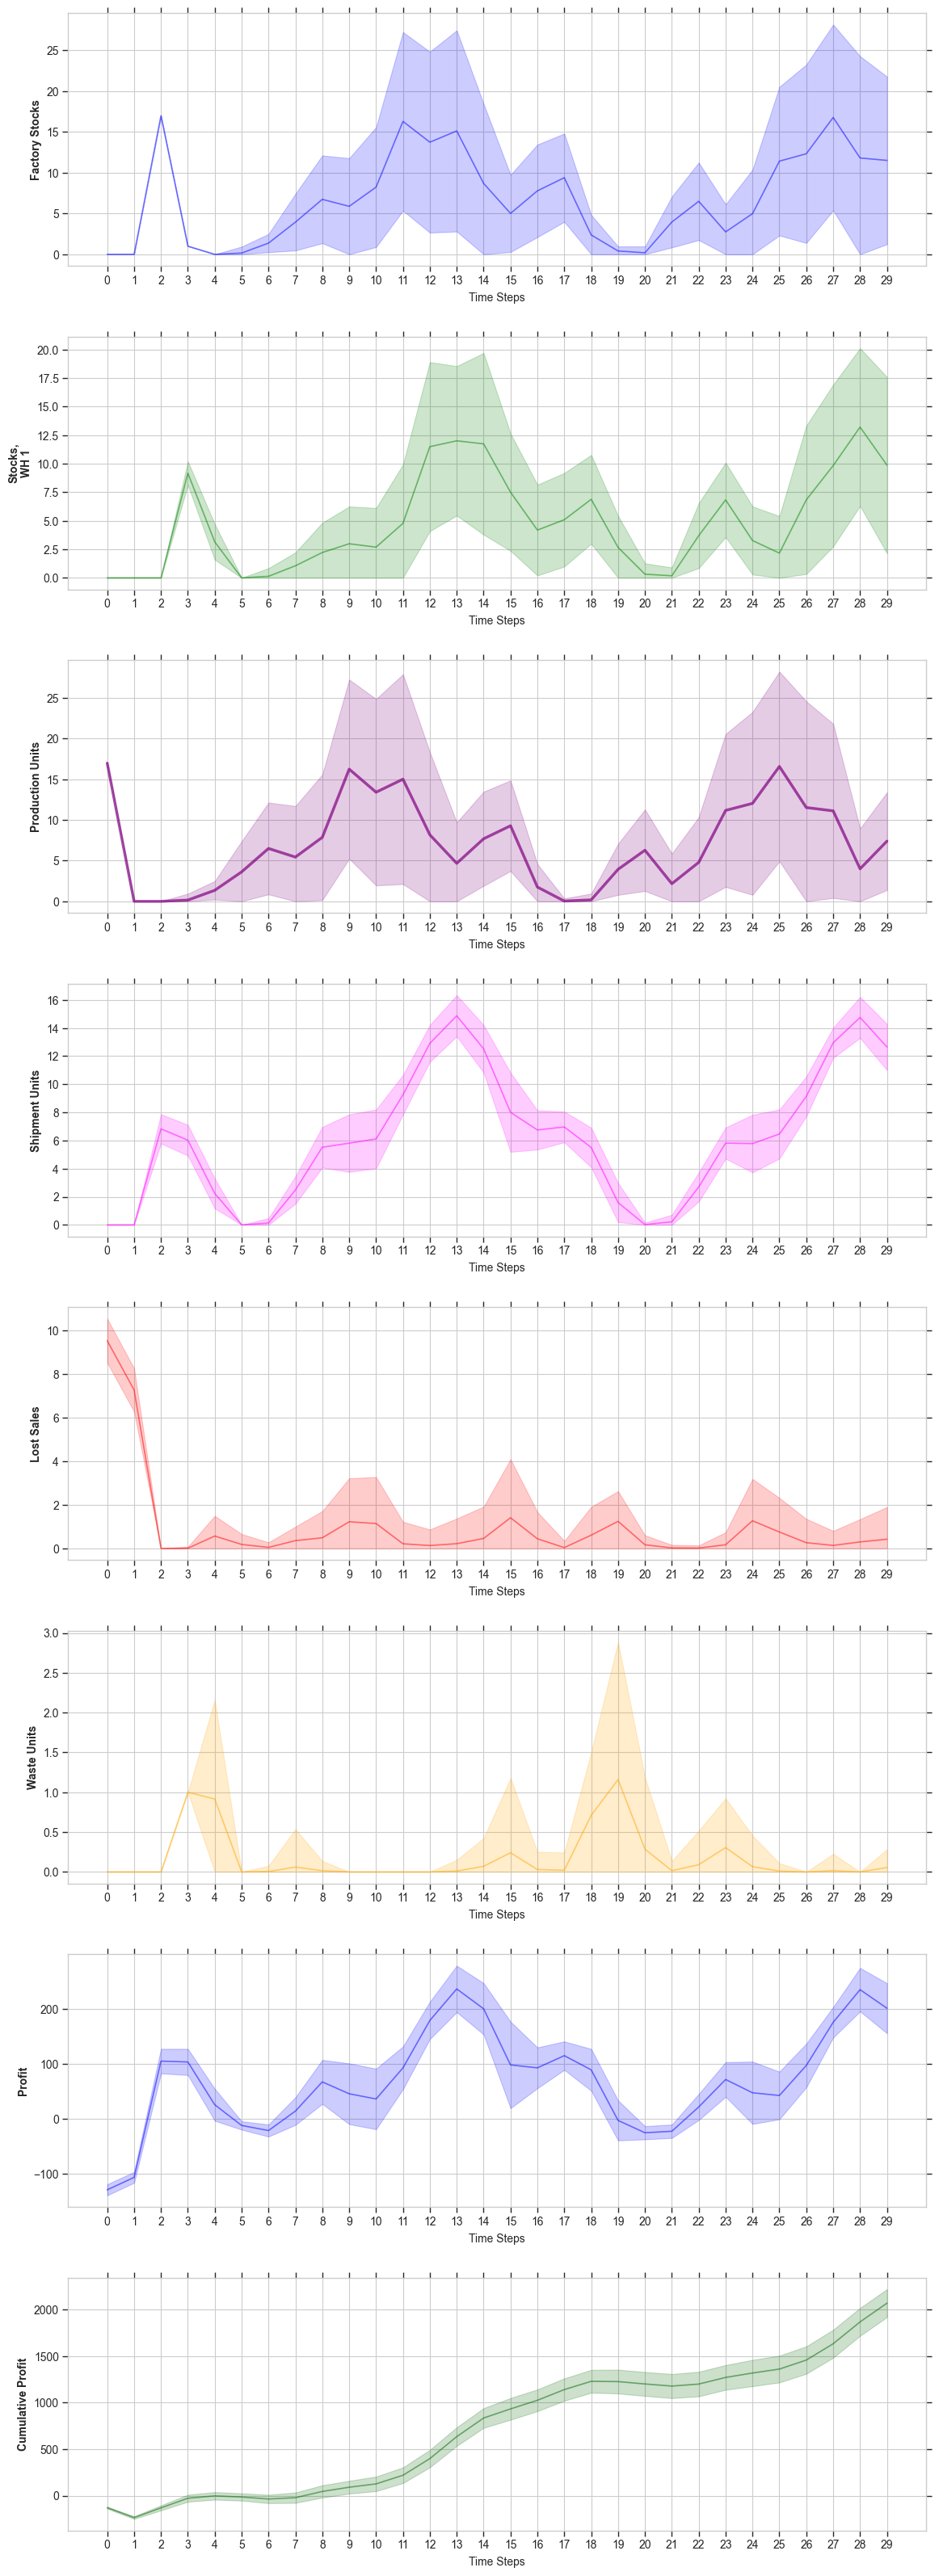

In [74]:
visualize_transitions(returns_trace_PPO, 'PPO')

In [75]:
# cumulative profit of the best PPO agent's policy
cum_profit_PPO = calculate_cum_profit(returns_trace_PPO)

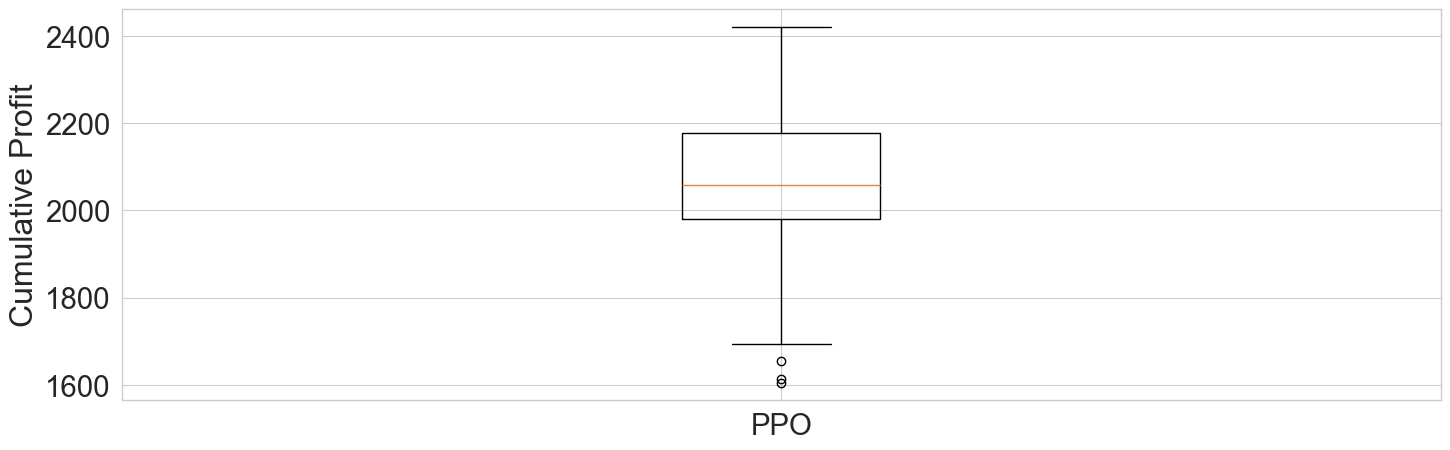

In [76]:
visualize_cum_profit(cum_profit_PPO, 'PPO')

# Final Results

## Cumulative Profit

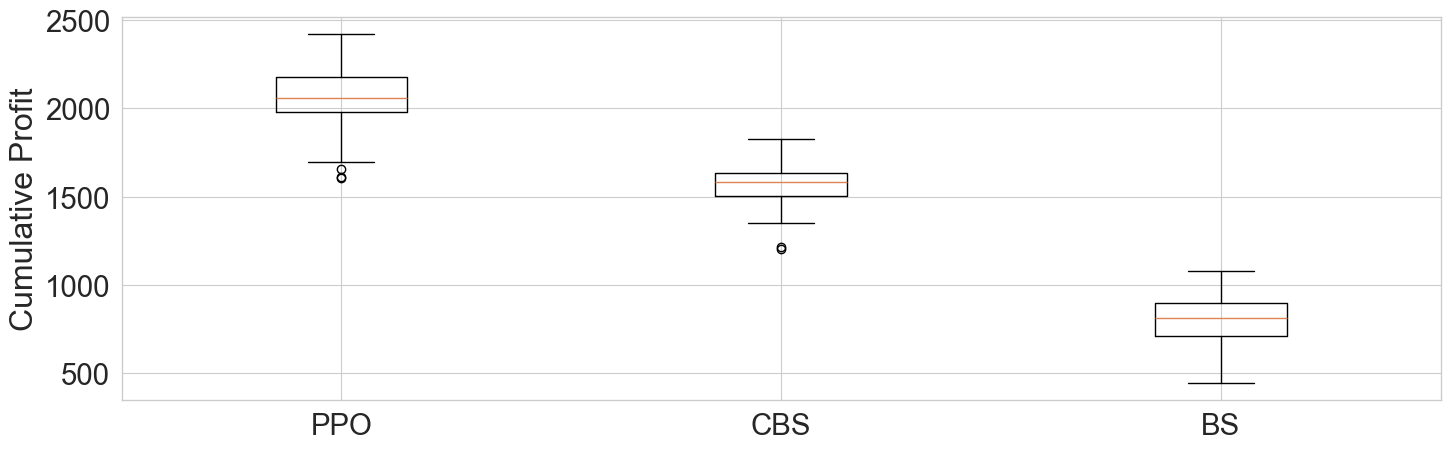

In [77]:
visualize_cum_profit([cum_profit_PPO, best_cum_profit_Ax_CBS,best_cum_profit_Ax_BS], ["PPO", "CBS","BS"])


In [78]:
# training time of all policies
times_total = {'Algorithm':
               ['PPO',
                f"CBS_{best_num_episodes_Ax_CBS}_{best_iteration_Ax_CBS+1}",
               f"BS_{best_num_episodes_Ax_BS}_{best_iteration_Ax_BS+1}"],
               'Training Time \n(in minutes)':
               [time_PPO,
                time_Ax_CBS,
                time_Ax_BS]}
# creating pandas DataFrame
times_total_df = pd.DataFrame(data=times_total)
times_total_df.set_index('Algorithm', inplace=True)
# saving pandas DataFrame as an image
dfi.export(times_total_df,
           f"{local_dir}/{plots_dir}"
           f"/times_total_df.png",
           table_conversion='matplotlib')
# printing training time of all policies
print(tabulate(times_total_df, headers='keys', tablefmt='grid'))

+-------------+------------------+
| Algorithm   |   Training Time  |
|             |     (in minutes) |
+=============+==================+
| PPO         |                3 |
+-------------+------------------+
| CBS_90_1    |                5 |
+-------------+------------------+
| BS_90_1     |                4 |
+-------------+------------------+


In [79]:
# checking if PPO best checkpoint is defined
try:
    best_checkpoint_PPO
except Exception as e:
    print(f"{e.__class__} occurred!")
    best_checkpoint_PPO = None

In [80]:
# TensorBoard dir for Ray results (the first best checkpoint not None)
tb_dir = next(checkpoint for checkpoint in [best_checkpoint_PPO]
              if checkpoint is not None).rsplit('/', 4)[0]
tb_dir

'C:\\Users\\ADITYA~1\\AppData\\Local\\Temp\\checkpoint_tmp_9cafea7144f64cdba27e7448761fa77d'

## Stock Breakdown 1

In [81]:
def visualize_stock_breakdown(returns_trace, algorithm, local_dir=local_dir, plots_dir=plots_dir):
    """
    Line chart of total stocks + bar charts of age breakdown (0,1,2) per facility.
    """
    if env.distr_warehouses_num <= 3 and env.product_types_num <= 2:
        num_episodes = len(returns_trace)
        T = env.T
        J = env.distr_warehouses_num
        I = env.product_types_num
        L = env.shelf_life

        # Extract traces
        infos_trace = [[ep[t]['info'] for t in range(len(ep))] for ep in returns_trace]

        # Calculate total stocks per timestep
        factory_total = np.array([
            [np.sum(infos_trace[e][t]['factory_age_pre_ageing']) for t in range(T)]
            for e in range(num_episodes)], dtype=np.float32)

        wh_total = [np.array([
            [np.sum(infos_trace[e][t]['wh_age_pre_ageing'][j]) for t in range(T)]
            for e in range(num_episodes)], dtype=np.float32) for j in range(J)]

        # Calculate age breakdown
        factory_by_age = [np.array([
            [np.sum(infos_trace[e][t]['factory_age_pre_ageing'][age]) for t in range(T)]
            for e in range(num_episodes)], dtype=np.float32) for age in range(L)]

        wh_by_age = [[np.array([
            [np.sum(infos_trace[e][t]['wh_age_pre_ageing'][j][age]) for t in range(T)]
            for e in range(num_episodes)], dtype=np.float32) for age in range(L)] for j in range(J)]

        # Create figure
        plt.figure(figsize=(16, 10))

        # 1. Line chart: Total stocks over time
        plt.subplot(2, 2, 1)
        plt.plot(range(T), factory_total.mean(axis=0), 'o-', label='Factory', linewidth=2)
        for j in range(J):
            plt.plot(range(T), wh_total[j].mean(axis=0), 's-', label=f'WH {j+1}', linewidth=2)
        plt.xlabel('Timestep')
        plt.ylabel('Total Stock')
        plt.title('Total Stock Over Time (Mean ± Std)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 2. Bar chart: Factory age breakdown (average across time and episodes)
        plt.subplot(2, 2, 2)
        factory_age_mean = [factory_by_age[age].mean() for age in range(L)]
        colors = ['#ff9999', '#ffcc99', '#99ccff']
        plt.bar(range(L), factory_age_mean, color=colors)
        plt.xlabel('Age Bucket')
        plt.ylabel('Average Stock')
        plt.title('Factory: Age Breakdown (Avg)')
        plt.xticks(range(L), [f'Age {age}' for age in range(L)])
        for i, v in enumerate(factory_age_mean):
            plt.text(i, v, f'{v:.1f}', ha='center', va='bottom')

        # 3. Bar chart: Warehouse age breakdown
        plt.subplot(2, 2, 3)
        x = np.arange(J)
        width = 0.25
        for age in range(L):
            wh_age_mean = [wh_by_age[j][age].mean() for j in range(J)]
            plt.bar(x + age*width, wh_age_mean, width, label=f'Age {age}', color=colors[age])
        plt.xlabel('Warehouse')
        plt.ylabel('Average Stock')
        plt.title('Warehouses: Age Breakdown (Avg)')
        plt.xticks(x + width, [f'WH {j+1}' for j in range(J)])
        plt.legend()

        # 4. Stacked bar: All facilities comparison
        plt.subplot(2, 2, 4)
        facilities = ['Factory'] + [f'WH {j+1}' for j in range(J)]
        age_data = [[factory_by_age[age].mean() for age in range(L)]]
        for j in range(J):
            age_data.append([wh_by_age[j][age].mean() for age in range(L)])

        bottom = np.zeros(J + 1)
        for age in range(L):
            values = [age_data[i][age] for i in range(J + 1)]
            plt.bar(range(J + 1), values, bottom=bottom, label=f'Age {age}', color=colors[age])
            bottom += values

        plt.xlabel('Facility')
        plt.ylabel('Stock (Stacked)')
        plt.title('Total Stock by Facility (Stacked by Age)')
        plt.xticks(range(J + 1), facilities)
        plt.legend()

        plt.tight_layout()

        if not os.path.exists(f"{local_dir}/{plots_dir}/{algorithm}"):
            os.makedirs(f"{local_dir}/{plots_dir}/{algorithm}")
        plt.savefig(f"{local_dir}/{plots_dir}/{algorithm}/stock_breakdown_{algorithm}.pdf",
                    format='pdf', bbox_inches='tight', dpi=300)
        plt.show()


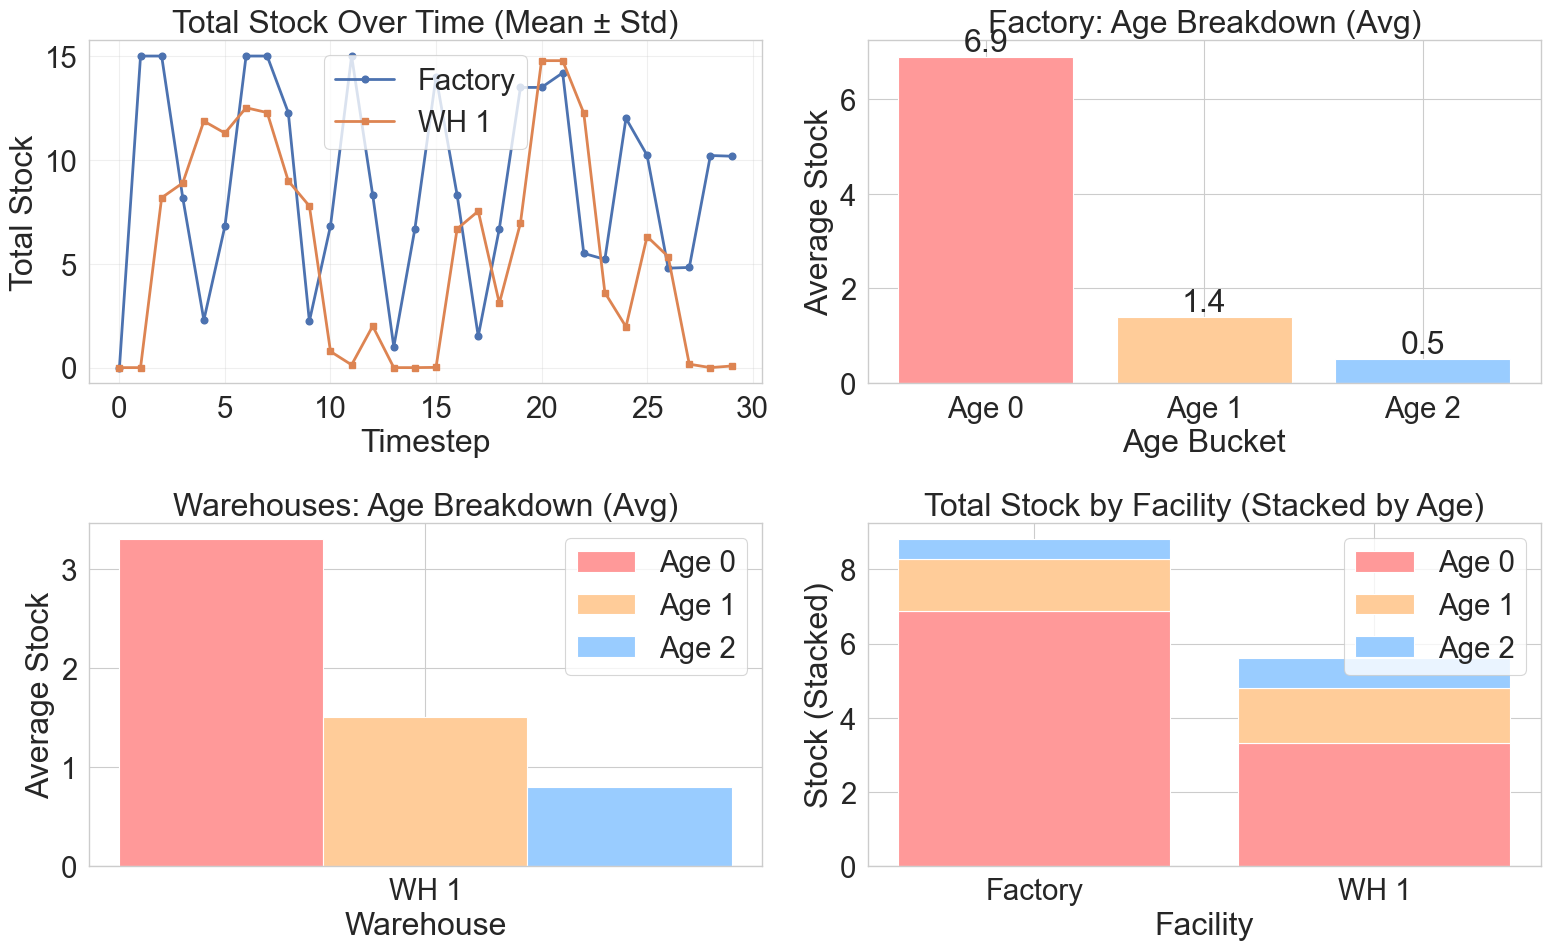

In [82]:
visualize_stock_breakdown(best_returns_trace_Ax_BS, 'BS')

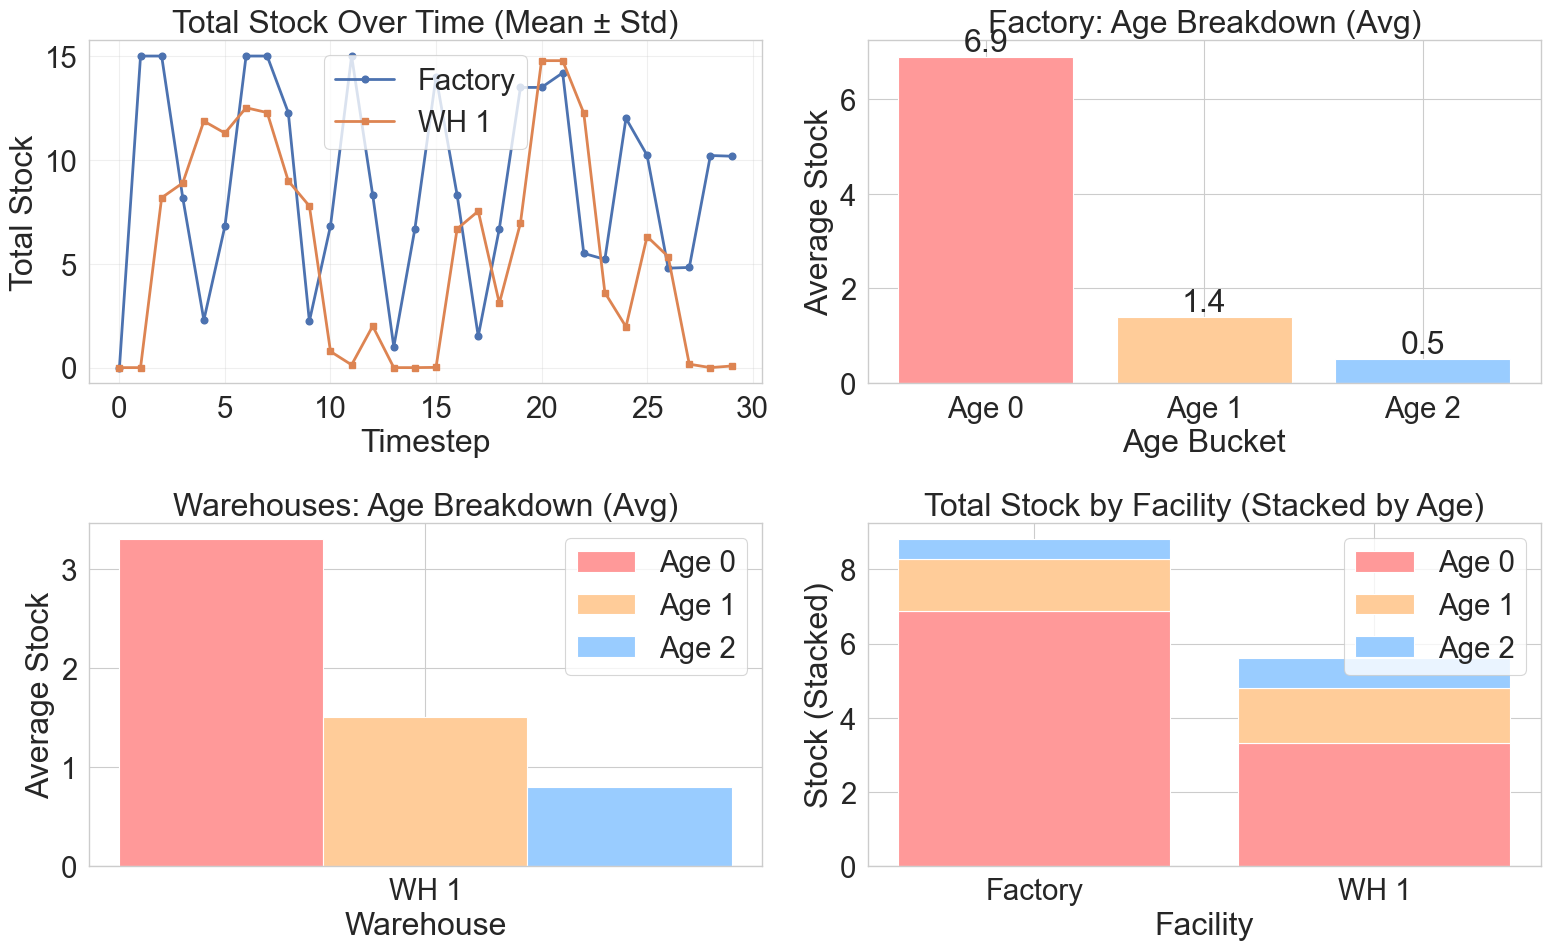

In [83]:
visualize_stock_breakdown(best_returns_trace_Ax_BS, 'CBS')

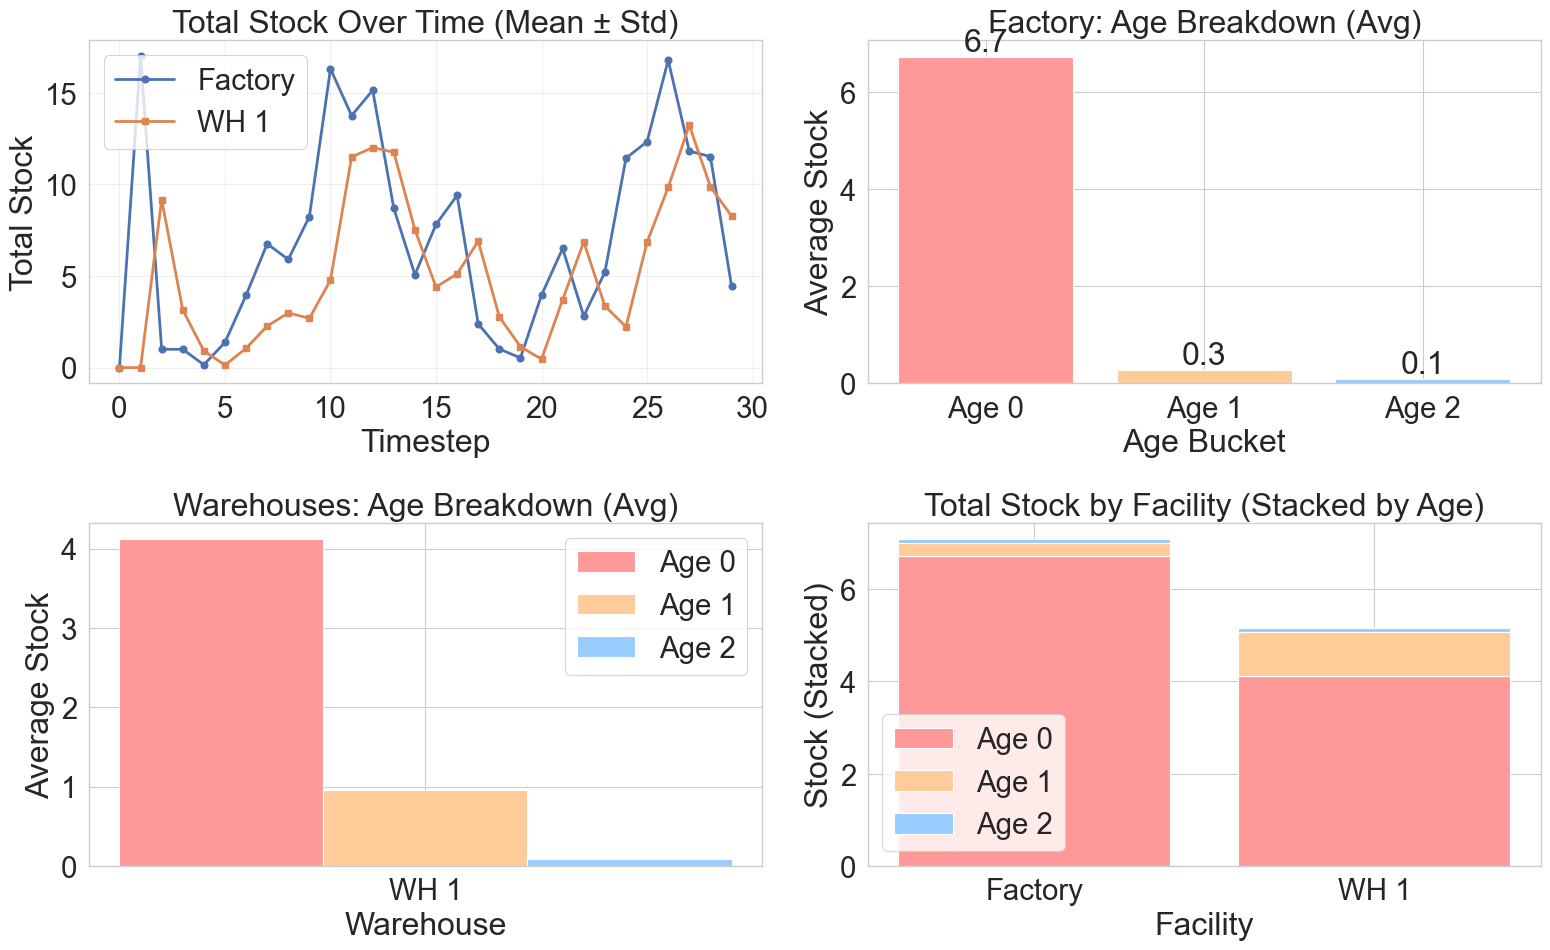

In [84]:
visualize_stock_breakdown(returns_trace_PPO, 'PPO')

## Stock Breakdown 2

In [99]:
def visualize_stock_breakdown_2(returns_trace, algorithm, local_dir=local_dir, plots_dir=plots_dir):
    """
    Fixed: Factory + each Warehouse.
    Stacked bars (age 0,1,2) + line (total) on SAME y-axis.
    All timesteps shown.
    """
    if env.distr_warehouses_num <= 3 and env.product_types_num <= 2:
        num_episodes = len(returns_trace)
        T = env.T
        J = env.distr_warehouses_num
        I = env.product_types_num
        L = env.shelf_life

        # Extract traces
        infos_trace = [[ep[t]['info'] for t in range(len(ep))] for ep in returns_trace]

        # ===== FACTORY - FIXED =====
        factory_total = np.array([
            [np.sum(infos_trace[e][t]['factory_age_pre_ageing']) for t in range(T)]
            for e in range(num_episodes)], dtype=np.float32)

        factory_by_age = [np.array([
            [float(infos_trace[e][t]['factory_age_pre_ageing'][age]) for t in range(T)]
            for e in range(num_episodes)], dtype=np.float32) for age in range(L)]

        # ===== WAREHOUSES - FIXED =====
        wh_total = [np.array([
            [np.sum(infos_trace[e][t]['wh_age_pre_ageing'][j]) for t in range(T)]
            for e in range(num_episodes)], dtype=np.float32) for j in range(J)]

        # FIXED: Convert to float for each warehouse
        wh_by_age = [[np.array([
            [float(infos_trace[e][t]['wh_age_pre_ageing'][j][age]) for t in range(T)]
            for e in range(num_episodes)], dtype=np.float32) for age in range(L)] for j in range(J)]

        # Create figure
        num_charts = 1 + J
        fig, axes = plt.subplots(num_charts, 1, figsize=(16, 5*num_charts))
        if num_charts == 1:
            axes = [axes]

        colors = ['#ff9999', '#ffcc99', '#99ccff']

        # ===== FACTORY CHART =====
        ax = axes[0]

        factory_mean = factory_total.mean(axis=0)
        age_0_mean = factory_by_age[0].mean(axis=0)
        age_1_mean = factory_by_age[1].mean(axis=0)
        age_2_mean = factory_by_age[2].mean(axis=0)

        # Bars - stacked
        ax.bar(range(T), age_0_mean, label='Age 0 (Newest)', color=colors[0], width=0.8, alpha=0.6)
        ax.bar(range(T), age_1_mean, bottom=age_0_mean, label='Age 1', color=colors[1], width=0.8, alpha=0.6)
        ax.bar(range(T), age_2_mean, bottom=age_0_mean + age_1_mean, label='Age 2 (Oldest)',
                color=colors[2], width=0.8, alpha=0.6)

        # Line - SAME AXIS
        ax.plot(range(T), factory_mean, 'o-', linewidth=2.5, markersize=7,
               label='Total Stock', color='darkblue', zorder=5)

        ax.set_ylabel('Stock (Units)', fontsize=11, fontweight='bold')
        ax.set_title('FACTORY: Stock Composition by Age + Total', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_xticks(range(T))  # ALL timesteps
        ax.legend(loc='upper left', frameon=True, fontsize=10)

        # ===== WAREHOUSE CHARTS =====
        for j in range(J):
            ax = axes[1 + j]

            wh_mean = wh_total[j].mean(axis=0)
            age_0_mean = wh_by_age[j][0].mean(axis=0)
            age_1_mean = wh_by_age[j][1].mean(axis=0)
            age_2_mean = wh_by_age[j][2].mean(axis=0)

            # Bars - stacked
            ax.bar(range(T), age_0_mean, label='Age 0 (Newest)', color=colors[0], width=0.8, alpha=0.6)
            ax.bar(range(T), age_1_mean, bottom=age_0_mean, label='Age 1', color=colors[1], width=0.8, alpha=0.6)
            ax.bar(range(T), age_2_mean, bottom=age_0_mean + age_1_mean, label='Age 2 (Oldest)',
                    color=colors[2], width=0.8, alpha=0.6)

            # Line - SAME AXIS
            ax.plot(range(T), wh_mean, 's-', linewidth=2.5, markersize=7,
                   label='Total Stock', color='darkblue', zorder=5)

            ax.set_ylabel('Stock (Units)', fontsize=11, fontweight='bold')
            ax.set_title(f'WAREHOUSE {j+1}: Stock Composition by Age + Total', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_xticks(range(T))  # ALL timesteps
            ax.legend(loc='upper left', frameon=True, fontsize=10)

        # Final label
        axes[-1].set_xlabel('Timestep', fontsize=12, fontweight='bold')

        fig.tight_layout()

        if not os.path.exists(f"{local_dir}/{plots_dir}/{algorithm}"):
            os.makedirs(f"{local_dir}/{plots_dir}/{algorithm}")
        plt.savefig(f"{local_dir}/{plots_dir}/{algorithm}/stock_breakdown_{algorithm}.pdf",
                    format='pdf', bbox_inches='tight', dpi=300)
        plt.show()


C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\3554766765.py:23: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\3554766765.py:33: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



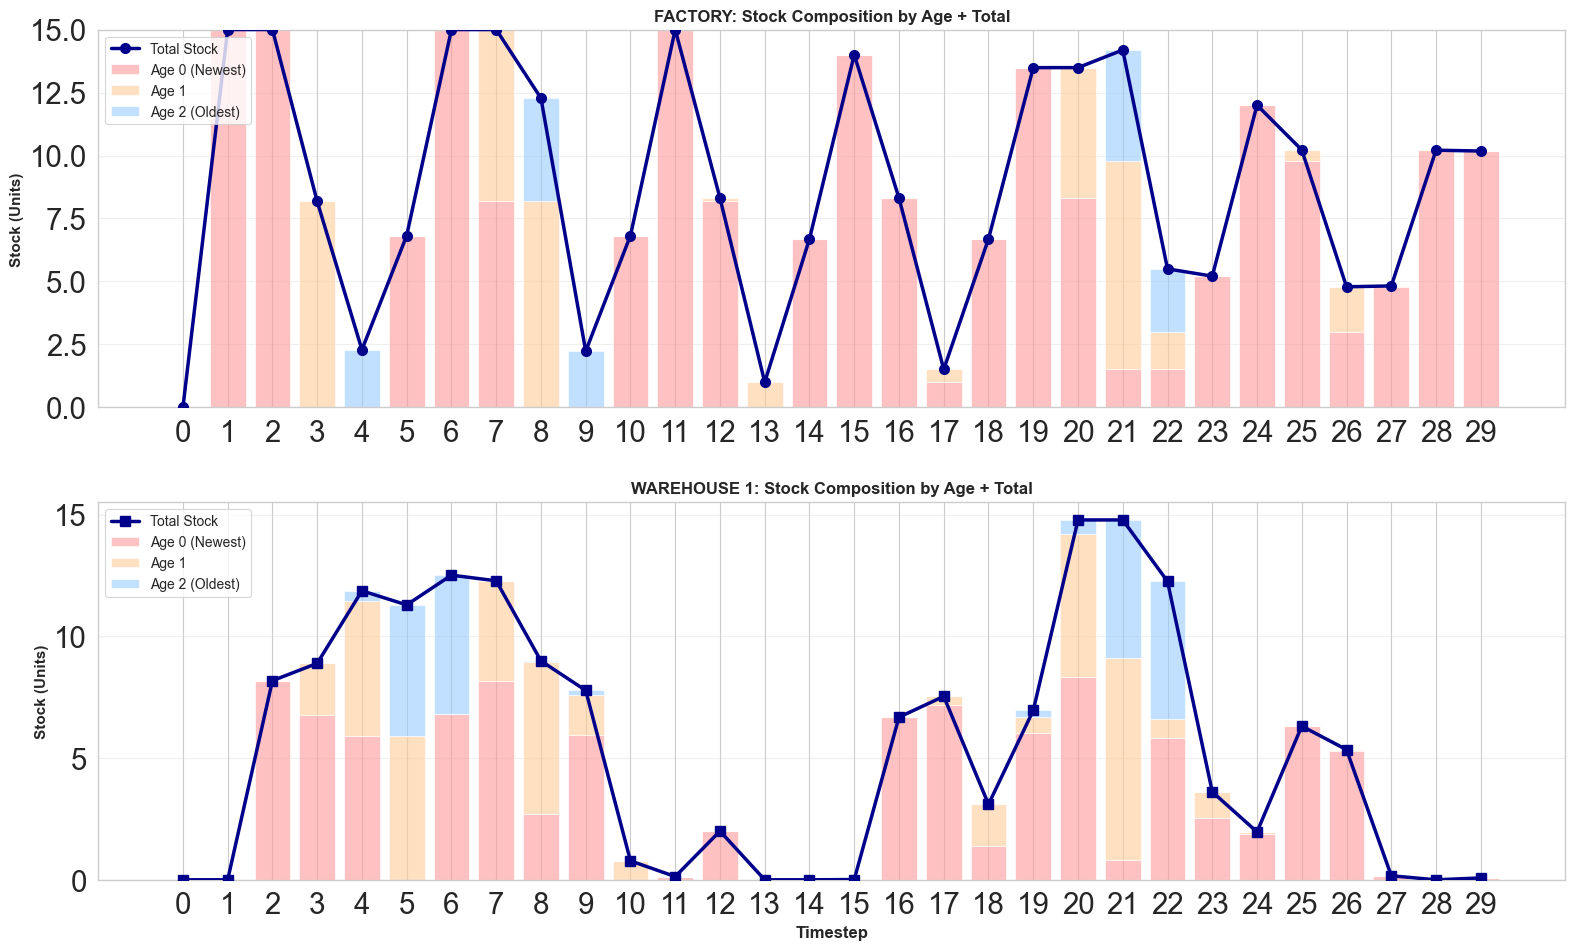

In [100]:
visualize_stock_breakdown_2(best_returns_trace_Ax_BS, 'BS')

C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\3554766765.py:23: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\3554766765.py:33: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



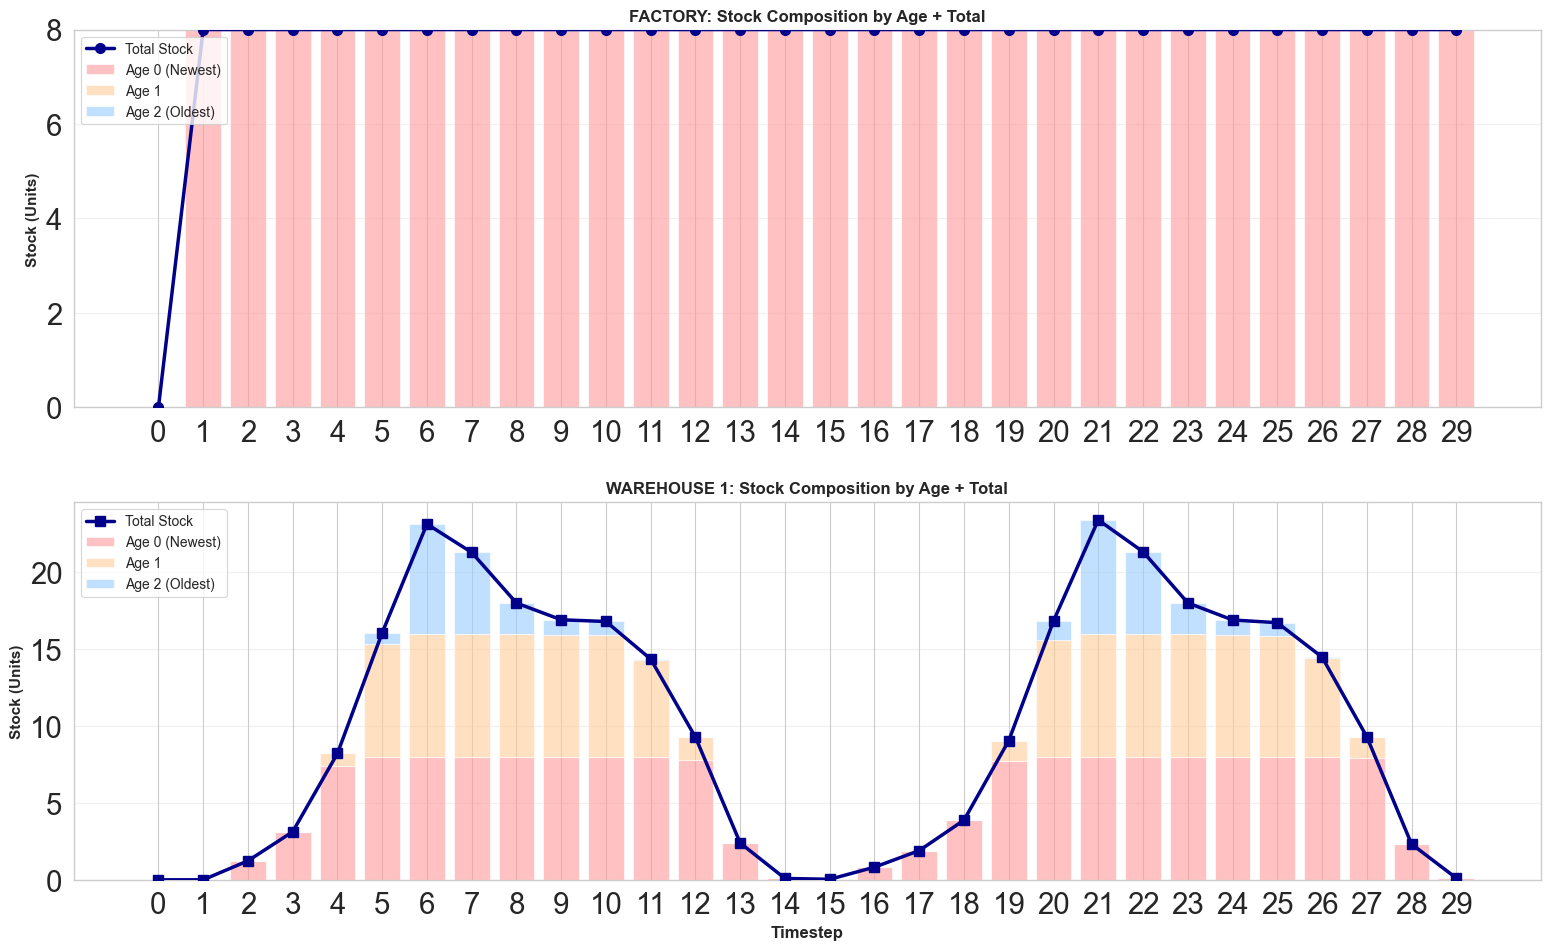

In [101]:
visualize_stock_breakdown_2(best_returns_trace_Ax_CBS, 'CBS')

C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\3554766765.py:23: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\3554766765.py:33: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



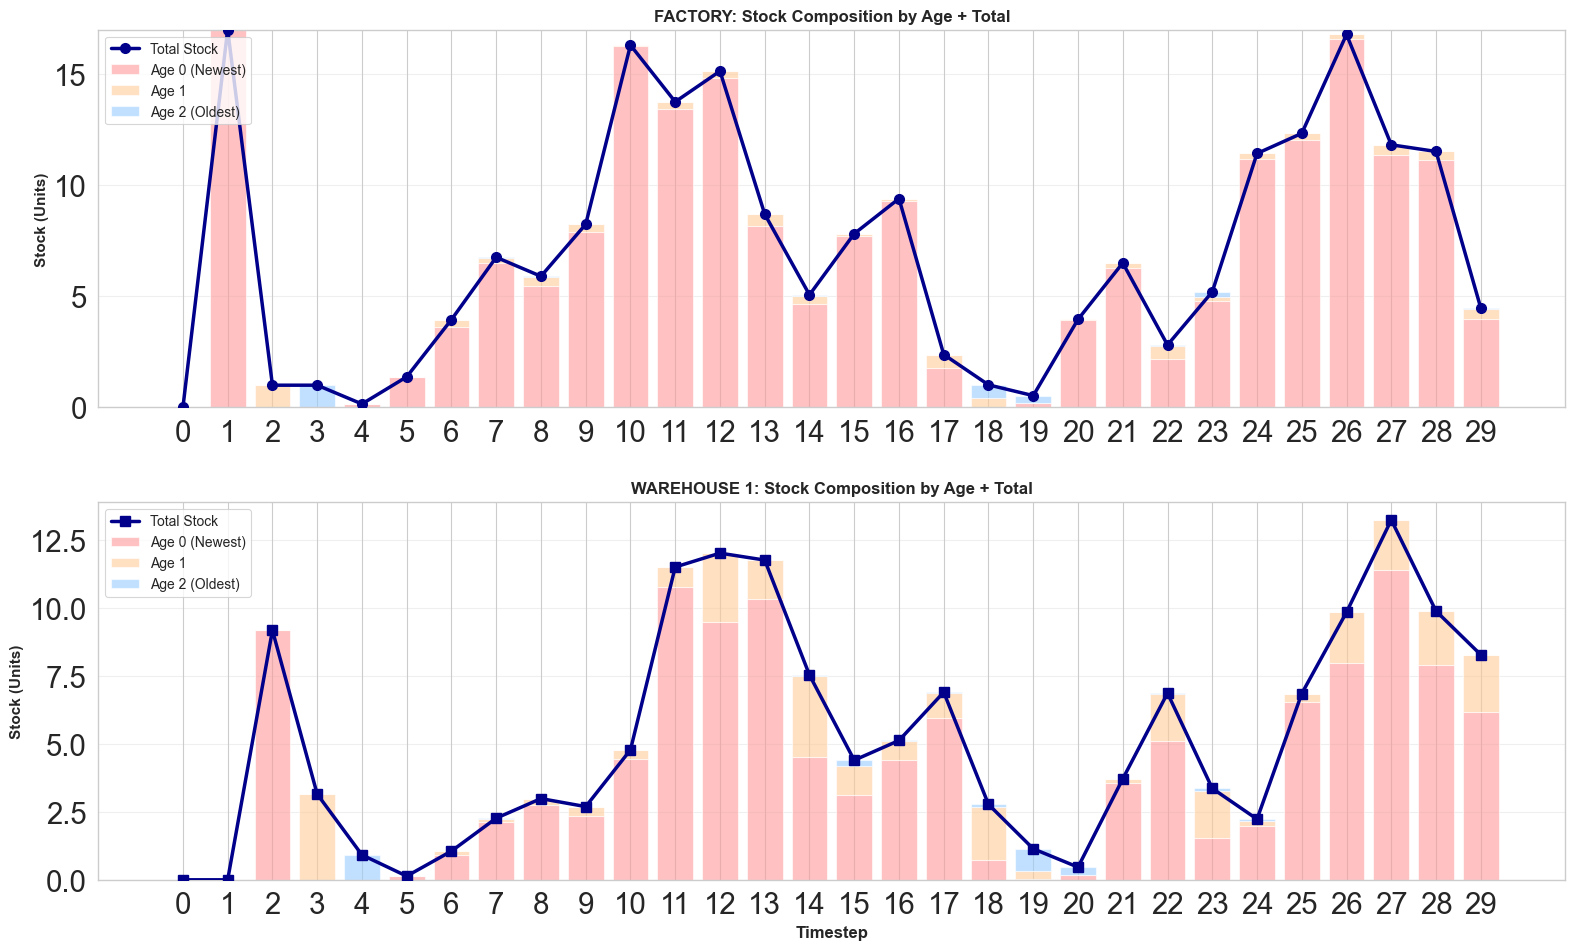

In [103]:
visualize_stock_breakdown_2(returns_trace_PPO, 'PPO')

## Summary Metrics

In [ ]:
def summarise_returns_trace(returns_trace):
    summary = {
        'lost_sales_units': [],
        'waste_units': [],
        'total_revenues': [],
        'total_production_costs': [],
        'total_transportation_costs': [],
        'total_storage_costs': [],
        'total_penalty_costs': [],
        'total_waste_costs': [],
        'cumulative_reward': [],
        'total_demand': [],      # NEW: total demand per episode
        'service_level': [],     # NEW: fraction of demand satisfied
    }
    for episode in returns_trace:
        lost_sales = 0
        waste = 0
        revenue = 0
        prod_cost = 0
        trans_cost = 0
        storage_cost = 0
        penalty_cost = 0
        waste_cost = 0
        cum_reward = 0
        total_demand = 0
        total_sales = 0
        for step in episode:
            info = step['info']
            demand = np.sum(info['demands'])        # sum over warehouses/products
            sales  = np.sum(info['sales_units'])
            lost_sales_step = np.sum(info['lost_sales_units'])
            lost_sales += lost_sales_step
            waste      += np.sum(info['total_waste_units'])
            revenue    += info['total_revenues']
            prod_cost  += info['total_production_costs']
            trans_cost += info['total_transportation_costs']
            storage_cost += info['total_storage_costs']
            penalty_cost += info['total_penalty_costs']
            waste_cost += info['total_waste_costs']
            cum_reward += step['reward']
            total_demand += demand
            total_sales  += sales
        summary['lost_sales_units'].append(lost_sales)
        summary['waste_units'].append(waste)
        summary['total_revenues'].append(revenue)
        summary['total_production_costs'].append(prod_cost)
        summary['total_transportation_costs'].append(trans_cost)
        summary['total_storage_costs'].append(storage_cost)
        summary['total_penalty_costs'].append(penalty_cost)
        summary['total_waste_costs'].append(waste_cost)
        summary['cumulative_reward'].append(cum_reward)
        summary['total_demand'].append(total_demand)
        # compute service level as sales ÷ demand (avoid divide-by-zero)
        level = (total_sales / total_demand) if total_demand > 0 else np.nan
        summary['service_level'].append(level)
    return summary


In [ ]:
def aggregate_summary_stats(summary_dict):
    """
    Compute mean, std, min, max for each metric in the episode-level summary.
    """
    rows = []

    for metric, values in summary_dict.items():
        arr = np.asarray(values, dtype=np.float64)

        rows.append({
            "Metric": metric,
            "Mean": np.nanmean(arr),
            "Std":  np.nanstd(arr, ddof=1),   # sample std (recommended)
            "Min":  np.nanmin(arr),
            "Max":  np.nanmax(arr),
        })

    return pd.DataFrame(rows).set_index("Metric")


In [ ]:
# After evaluation
summary_ppo = summarise_returns_trace(returns_trace_PPO)
summary_bs  = summarise_returns_trace(best_returns_trace_Ax_BS)
summary_cbs = summarise_returns_trace(best_returns_trace_Ax_CBS)

summary_df = pd.DataFrame({
    'Policy': ['PPO', 'BS', 'CBS'],
    'Mean Reward': [np.mean(summary_ppo['cumulative_reward']),
                        np.mean(summary_bs['cumulative_reward']),
                        np.mean(summary_cbs['cumulative_reward'])],
    'Mean demand (units)': [np.mean(summary_ppo['total_demand']),
                            np.mean(summary_bs['total_demand']),
                            np.mean(summary_cbs['total_demand'])],
    'Mean lost sales (units)': [np.mean(summary_ppo['lost_sales_units']),
                            np.mean(summary_bs['lost_sales_units']),
                            np.mean(summary_cbs['lost_sales_units'])],
    'Mean service level': [np.mean(summary_ppo['service_level']),
                           np.mean(summary_bs['service_level']),
                           np.mean(summary_cbs['service_level'])],
    'Mean waste (units)': [np.mean(summary_ppo['waste_units']),
                           np.mean(summary_bs['waste_units']),
                           np.mean(summary_cbs['waste_units'])],
})

summary_df

Policy  Mean Reward  Mean demand (units)  Mean lost sales (units)  \
0    PPO  2068.410000              212.975                29.010000   
1     BS   796.705556              213.400                56.411111   
2    CBS  1565.727778              213.400                24.266667   

   Mean service level  Mean waste (units)  
0            0.863950            5.075000  
1            0.735716           39.422222  
2            0.886480           34.755556

In [ ]:
def add_ci95(df, N):
    df = df.copy()
    df["CI_95"] = 1.96 * df["Std"] / np.sqrt(N)
    return df

In [ ]:
episode_summary = summarise_returns_trace(returns_trace_PPO)
summary_table = aggregate_summary_stats(episode_summary)
summary_table = add_ci95(summary_table, N=len(returns_trace_PPO))
summary_table


Mean         Std          Min          Max  \
Metric                                                                         
lost_sales_units              29.01000    6.620351    15.000000    51.000000   
waste_units                    5.07500    2.988987     1.000000    17.000000   
total_revenues              3679.30000  137.988092  3280.000000  4040.000000   
total_production_costs       418.25000   17.860360   364.000000   456.000000   
total_transportation_costs   194.91500    9.923718   168.000000   216.000000   
total_storage_costs          656.87500   65.128183   463.500000   819.000000   
total_penalty_costs          290.10000   66.203508   150.000000   510.000000   
total_waste_costs             50.75000   29.889873    10.000000   170.000000   
cumulative_reward           2068.41000  150.587190  1605.000000  2420.500000   
total_demand                 212.97500    5.056900   201.000000   225.000000   
service_level                  0.86395    0.030154     0.766055     0.926471   

                                CI_95  
Metric                                 
lost_sales_units             0.917534  
waste_units                  0.414253  
total_revenues              19.124174  
total_production_costs       2.475320  
total_transportation_costs   1.375357  
total_storage_costs          9.026306  
total_penalty_costs          9.175338  
total_waste_costs            4.142525  
cumulative_reward           20.870320  
total_demand                 0.700851  
service_level                0.004179

In [ ]:
episode_summary = summarise_returns_trace(best_returns_trace_Ax_BS)
summary_table = aggregate_summary_stats(episode_summary)
summary_table = add_ci95(summary_table, N=len(best_returns_trace_Ax_BS))
summary_table


Mean         Std          Min          Max  \
Metric                                                                          
lost_sales_units              56.411111    3.885711    49.000000    74.000000   
waste_units                   39.422222    2.832309    33.000000    45.000000   
total_revenues              3139.777778   92.965836  2920.000000  3320.000000   
total_production_costs       422.911111    2.955264   414.000000   430.000000   
total_transportation_costs   180.977778    3.943357   171.000000   189.000000   
total_storage_costs          780.850000   17.527579   735.000000   825.000000   
total_penalty_costs          564.111111   38.857112   490.000000   740.000000   
total_waste_costs            394.222222   28.323087   330.000000   450.000000   
cumulative_reward            796.705556  139.049803   444.500000  1080.500000   
total_demand                 213.400000    5.107386   202.000000   225.000000   
service_level                  0.735716    0.015937     0.671111     0.766355   

                                CI_95  
Metric                                 
lost_sales_units             0.802796  
waste_units                  0.585161  
total_revenues              19.206941  
total_production_costs       0.610564  
total_transportation_costs   0.814706  
total_storage_costs          3.621235  
total_penalty_costs          8.027963  
total_waste_costs            5.851610  
cumulative_reward           28.727987  
total_demand                 1.055197  
service_level                0.003293

In [ ]:
episode_summary = summarise_returns_trace(best_returns_trace_Ax_CBS)
summary_table = aggregate_summary_stats(episode_summary)
summary_table = add_ci95(summary_table, N=len(best_returns_trace_Ax_CBS))
summary_table


Mean         Std          Min          Max  \
Metric                                                                          
lost_sales_units              24.266667    3.249200    17.000000    37.000000   
waste_units                   34.755556    3.545249    27.000000    46.000000   
total_revenues              3782.666667   71.340299  3560.000000  3940.000000   
total_production_costs       480.000000    0.000000   480.000000   480.000000   
total_transportation_costs   224.000000    0.000000   224.000000   224.000000   
total_storage_costs          922.716667   17.508593   873.500000   968.000000   
total_penalty_costs          242.666667   32.492004   170.000000   370.000000   
total_waste_costs            347.555556   35.452488   270.000000   460.000000   
cumulative_reward           1565.727778  119.200076  1204.500000  1824.000000   
total_demand                 213.400000    5.107386   202.000000   225.000000   
service_level                  0.886480    0.013326     0.835556     0.917073   

                                CI_95  
Metric                                 
lost_sales_units             0.671292  
waste_units                  0.732456  
total_revenues              14.739058  
total_production_costs       0.000000  
total_transportation_costs   0.000000  
total_storage_costs          3.617313  
total_penalty_costs          6.712918  
total_waste_costs            7.324560  
cumulative_reward           24.626991  
total_demand                 1.055197  
service_level                0.002753

## Transition Overlay

In [ ]:
def prepare_metric_plot(ylabel, n, plots_n=10, fontsize=12):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel, fontsize=fontsize-2, fontweight='bold')
    plt.tick_params(axis='y', which='both',
                    left=True, right=True, labelleft=True,
                    labelsize=fontsize-2)

    plt.xticks(np.arange(env.T))
    plt.xlabel('Time Steps', fontsize=fontsize-2, labelpad=5)
    plt.tick_params(axis='x', which='both',
                    top=True, bottom=True, labelbottom=True,
                    labelsize=fontsize-2)

    plt.subplots_adjust(hspace=0.45)
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)


def fill_between_nonnegative(x, mean, std, **kwargs):
    mean = np.asarray(mean, dtype=np.float64)
    std  = np.asarray(std, dtype=np.float64)
    lower = np.maximum(mean - std, 0.0)
    upper = mean + std
    plt.fill_between(x, lower, upper, **kwargs)


def visualize_transitions_overlay(
    traces_by_algo,
    local_dir=local_dir,
    plots_dir=plots_dir,
    filename="transitions_overlay.pdf"
):
    """
    traces_by_algo: dict like {"PPO": returns_trace_ppo, "BS": returns_trace_bs, "CBS": returns_trace_cbs}
    """

    if env.distr_warehouses_num > 3 or env.product_types_num > 2:
        return

    # ================= STYLE MAP =================
    style = {
        "PPO": {"color": "purple", "alpha_line": 0.9, "alpha_fill": 0.12,
                "lw": 2.2, "ls": "-",  "z": 3},
        "BS":  {"color": "blue",   "alpha_line": 0.8, "alpha_fill": 0.05,
                "lw": 2.0, "ls": "-",  "z": 2},
        "CBS": {"color": "green",  "alpha_line": 1.0, "alpha_fill": 0.05,
                "lw": 2.6, "ls": "--", "z": 4},
    }

    # ==================================================
    any_trace = next(iter(traces_by_algo.values()))
    T = env.T
    J = env.distr_warehouses_num
    I = env.product_types_num
    L = getattr(env, "shelf_life", 1)

    sample_ep0 = any_trace[0][0]
    has_age = (I == 1) and ('factory_age_pre_ageing' in sample_ep0.get('info', {}))

    base_plots = 6 + 2*J + L + J*L + 2 + 1 + 1
    age_plots  = (1 + J) * L if (I == 1 and has_age) else 0
    plots_n = base_plots + age_plots if I == 1 else 26

    plt.figure(figsize=(12, 4 * plots_n))
    plot_idx = 1
    x = np.arange(T)

    # ================= HELPERS =================
    def extract_common_arrays(returns_trace):
        N = len(returns_trace)
        states = [[ep[t]['state']  for t in range(len(ep))] for ep in returns_trace]
        actions = [[ep[t]['action'] for t in range(len(ep))] for ep in returns_trace]
        rewards = np.array([[ep[t]['reward'] for t in range(len(ep))]
                            for ep in returns_trace], dtype=np.float32)
        infos = [[ep[t]['info'] for t in range(len(ep))] for ep in returns_trace]

        lost_sales = np.array([
            [np.sum(ep[t]['info'].get("lost_sales_units", 0)) for t in range(len(ep))]
            for ep in returns_trace], dtype=np.float32)

        waste = np.array([
            [np.sum(ep[t]['info'].get("total_waste_units", 0)) for t in range(len(ep))]
            for ep in returns_trace], dtype=np.float32)

        return N, states, actions, rewards, infos, lost_sales, waste

    def decode_ppo_prod_units(a_norm, cap_prod, I):
        a_norm = np.asarray(a_norm, dtype=np.float32)
        a_prod = a_norm[:I]
        prod_f = 0.5 * (a_prod + 1.0) * cap_prod
        prod_f = np.clip(prod_f, 0.0, cap_prod)
        return np.floor(prod_f + 1e-6).astype(np.int32)

    cap_prod = env.storage_capacities[0].astype(np.float32)

    extracted = {algo: extract_common_arrays(rt)
                 for algo, rt in traces_by_algo.items()}

    # ================= FACTORY STOCK =================
    prepare_metric_plot('Factory Stocks', plot_idx, plots_n); plot_idx += 1
    for algo, (N, states, actions, rewards, infos, lost, waste) in extracted.items():
        mean, std = [], []
        for t in range(T):
            vals = [int(np.sum(states[e][t][:L])) for e in range(N)]
            mean.append(np.mean(vals))
            std.append(np.std(vals))
        st = style[algo]
        plt.plot(x, mean, label=algo,
                 color=st["color"], linewidth=st["lw"],
                 linestyle=st["ls"], alpha=st["alpha_line"],
                 zorder=st["z"])
        if algo == "PPO":
            fill_between_nonnegative(x, mean, std,
                                     color=st["color"],
                                     alpha=st["alpha_fill"],
                                     zorder=st["z"]-1)
    plt.legend(
    loc="upper left",
    fontsize=9,
    ncol=3,              # horizontal (PPO | BS | CBS)
    frameon=False,
    handlelength=2.5,
    columnspacing=1.2
    )


    # ================= WAREHOUSE STOCK =================
    for j in range(J):
        prepare_metric_plot(f"Stocks,\nWH {j+1}", plot_idx, plots_n); plot_idx += 1
        sl = slice(L + j*L, L + (j+1)*L)
        for algo, (N, states, actions, rewards, infos, lost, waste) in extracted.items():
            mean, std = [], []
            for t in range(T):
                vals = [int(np.sum(states[e][t][sl])) for e in range(N)]
                mean.append(np.mean(vals))
                std.append(np.std(vals))
            st = style[algo]
            plt.plot(x, mean, label=algo,
                     color=st["color"], linewidth=st["lw"],
                     linestyle=st["ls"], alpha=st["alpha_line"],
                     zorder=st["z"])
            if algo == "PPO":
                fill_between_nonnegative(x, mean, std,
                                         color=st["color"],
                                         alpha=st["alpha_fill"],
                                         zorder=st["z"]-1)
        plt.legend(
    loc="upper left",
    fontsize=9,
    ncol=3,              # horizontal (PPO | BS | CBS)
    frameon=False,
    handlelength=2.5,
    columnspacing=1.2
    )


    # ================= PRODUCTION =================
    prepare_metric_plot('Production Units', plot_idx, plots_n); plot_idx += 1
    for algo, (N, states, actions, rewards, infos, lost, waste) in extracted.items():
        mean, std = [], []
        for t in range(T):
            if algo in ["BS", "CBS"]:
                vals = [int(np.sum(actions[e][t].production_level)) for e in range(N)]
            else:
                vals = [int(np.sum(decode_ppo_prod_units(actions[e][t], cap_prod, I)))
                        for e in range(N)]
            mean.append(np.mean(vals))
            std.append(np.std(vals))
        st = style[algo]
        plt.plot(x, mean, label=algo,
                 color=st["color"], linewidth=st["lw"],
                 linestyle=st["ls"], alpha=st["alpha_line"],
                 zorder=st["z"])
        if algo == "PPO":
            fill_between_nonnegative(x, mean, std,
                                     color=st["color"],
                                     alpha=st["alpha_fill"],
                                     zorder=st["z"]-1)
    plt.legend(
    loc="upper left",
    fontsize=9,
    ncol=3,              # horizontal (PPO | BS | CBS)
    frameon=False,
    handlelength=2.5,
    columnspacing=1.2
    )


    # ================= SHIPMENT =================
    prepare_metric_plot('Shipment Units', plot_idx, plots_n); plot_idx += 1
    for algo, (N, states, actions, rewards, infos, lost, waste) in extracted.items():
        mean, std = [], []
        for t in range(T):
            vals = [int(np.sum(infos[e][t]['sales_units'])) for e in range(N)]
            mean.append(np.mean(vals))
            std.append(np.std(vals))
        st = style[algo]
        plt.plot(x, mean, label=algo,
                 color=st["color"], linewidth=st["lw"],
                 linestyle=st["ls"], alpha=st["alpha_line"],
                 zorder=st["z"])
        if algo == "PPO":
            fill_between_nonnegative(x, mean, std,
                                     color=st["color"],
                                     alpha=st["alpha_fill"],
                                     zorder=st["z"]-1)
    plt.legend(
    loc="upper left",
    fontsize=9,
    ncol=3,              # horizontal (PPO | BS | CBS)
    frameon=False,
    handlelength=2.5,
    columnspacing=1.2
    )


    # ================= LOST SALES =================
    prepare_metric_plot('Lost Sales', plot_idx, plots_n); plot_idx += 1
    for algo, (N, states, actions, rewards, infos, lost, waste) in extracted.items():
        mean = lost.mean(axis=0)
        std  = lost.std(axis=0)
        st = style[algo]
        plt.plot(x, mean, label=algo,
                 color=st["color"], linewidth=st["lw"],
                 linestyle=st["ls"], alpha=st["alpha_line"],
                 zorder=st["z"])
        if algo == "PPO":
            fill_between_nonnegative(x, mean, std,
                                     color=st["color"],
                                     alpha=st["alpha_fill"],
                                     zorder=st["z"]-1)
    plt.legend(
    loc="upper left",
    fontsize=9,
    ncol=3,              # horizontal (PPO | BS | CBS)
    frameon=False,
    handlelength=2.5,
    columnspacing=1.2
    )


    # ================= WASTE =================
    prepare_metric_plot('Waste Units', plot_idx, plots_n); plot_idx += 1
    for algo, (N, states, actions, rewards, infos, lost, waste) in extracted.items():
        mean = waste.mean(axis=0)
        std  = waste.std(axis=0)
        st = style[algo]
        plt.plot(x, mean, label=algo,
                 color=st["color"], linewidth=st["lw"],
                 linestyle=st["ls"], alpha=st["alpha_line"],
                 zorder=st["z"])
        if algo == "PPO":
            fill_between_nonnegative(x, mean, std,
                                     color=st["color"],
                                     alpha=st["alpha_fill"],
                                     zorder=st["z"]-1)
    plt.legend(
    loc="upper left",
    fontsize=9,
    ncol=3,              # horizontal (PPO | BS | CBS)
    frameon=False,
    handlelength=2.5,
    columnspacing=1.2
    )


    # ================= PROFIT =================
    prepare_metric_plot('Profit', plot_idx, plots_n); plot_idx += 1
    for algo, (N, states, actions, rewards, infos, lost, waste) in extracted.items():
        mean = rewards.mean(axis=0)
        std  = rewards.std(axis=0)
        st = style[algo]
        plt.plot(x, mean, label=algo,
                 color=st["color"], linewidth=st["lw"],
                 linestyle=st["ls"], alpha=st["alpha_line"],
                 zorder=st["z"])
        plt.fill_between(x, mean-std, mean+std,
                         color=st["color"], alpha=0.08, zorder=st["z"]-1)
    plt.legend(
    loc="upper left",
    fontsize=9,
    ncol=3,              # horizontal (PPO | BS | CBS)
    frameon=False,
    handlelength=2.5,
    columnspacing=1.2
    )


    # ================= CUMULATIVE PROFIT =================
    prepare_metric_plot('Cumulative Profit', plot_idx, plots_n); plot_idx += 1
    for algo, (N, states, actions, rewards, infos, lost, waste) in extracted.items():
        cum = np.cumsum(rewards, axis=1)
        mean = cum.mean(axis=0)
        std  = cum.std(axis=0)
        st = style[algo]
        plt.plot(x, mean, label=algo,
                 color=st["color"], linewidth=st["lw"],
                 linestyle=st["ls"], alpha=st["alpha_line"],
                 zorder=st["z"])
        plt.fill_between(x, mean-std, mean+std,
                         color=st["color"], alpha=0.08, zorder=st["z"]-1)
    plt.legend(
    loc="upper left",
    fontsize=9,
    ncol=3,              # horizontal (PPO | BS | CBS)
    frameon=False,
    handlelength=2.5,
    columnspacing=1.2
    )


    # ================= SAVE =================
    plt.tight_layout()
    os.makedirs(f"{local_dir}/{plots_dir}", exist_ok=True)
    out = f"{local_dir}/{plots_dir}/{filename}"
    plt.savefig(out, bbox_inches="tight", dpi=300)
    plt.show()

    return out


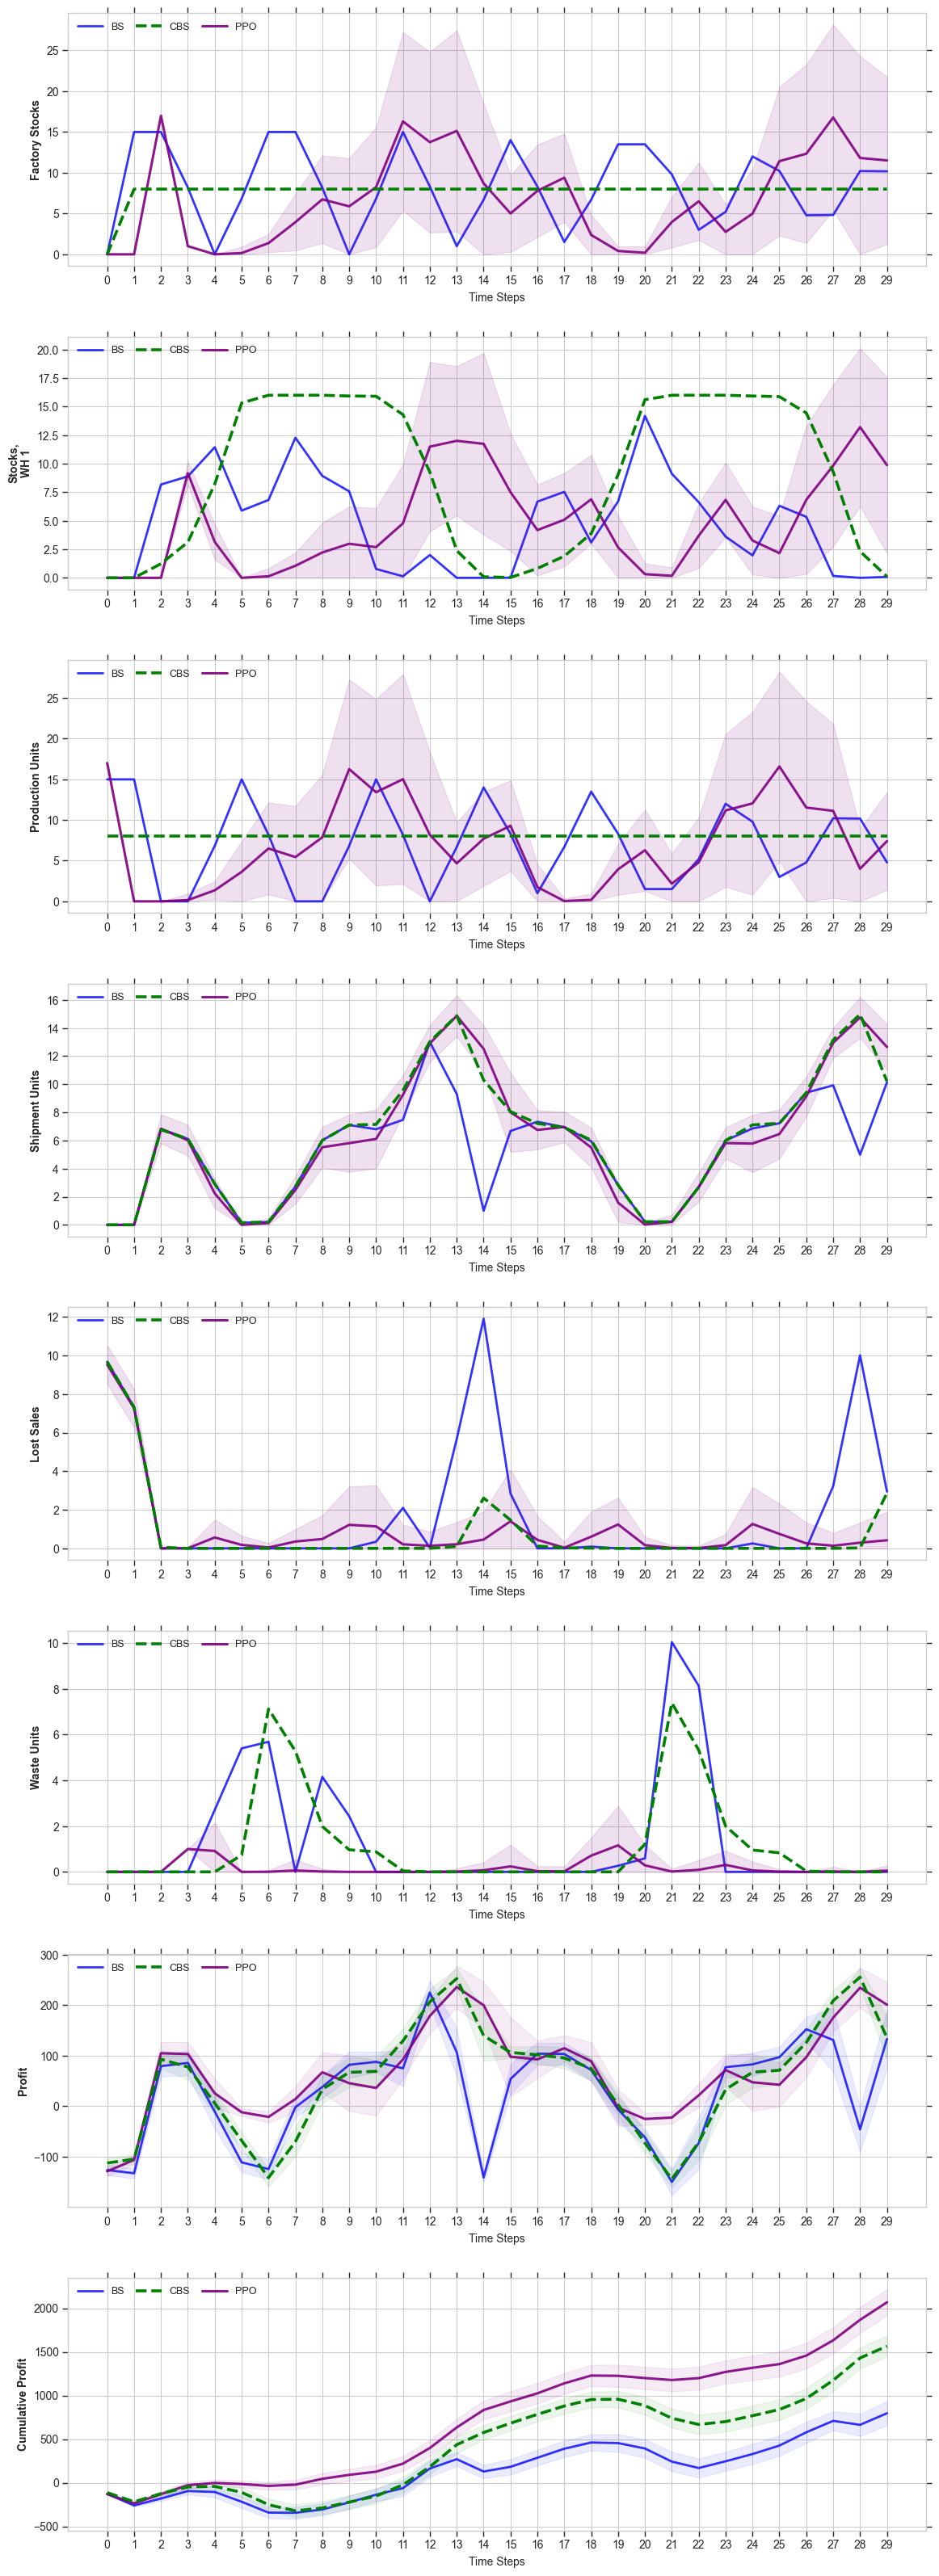

Saved: 1W_ADIT_23-01-2026_06-07-57/plots/transitions_overlay_1W.pdf


In [98]:
out = visualize_transitions_overlay({
    "BS":  best_returns_trace_Ax_BS,
    "CBS": best_returns_trace_Ax_CBS,
    "PPO": returns_trace_PPO
}, filename="transitions_overlay_1W.pdf")
print("Saved:", out)

## Clustered Stock Composition

In [ ]:
def visualize_clustered_stock_age_composition(
    traces_by_method,
    local_dir=local_dir,
    plots_dir=plots_dir,
    out_name="clustered_stock_age_composition",
    agg="mean_over_time",          # "mean_over_time" | "timestep"
    timestep=0,                    # used only if agg=="timestep"
):
    """
    traces_by_method: dict {"BS": returns_trace_bs, "CBS": returns_trace_cbs, "PPO": returns_trace_ppo}
    agg:
      - "mean_over_time": average stock over timesteps (0..T_eff-1), then average over episodes
      - "timestep": take a single timestep snapshot (episode-mean at that timestep)
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    # ---- env params ----
    T = int(env.T)
    J = int(env.distr_warehouses_num)
    I = int(env.product_types_num)
    L = int(getattr(env, "shelf_life", 1))
    if I != 1:
        raise ValueError("This plot assumes I==1 (single product) for age buckets.")

    methods = list(traces_by_method.keys())
    if len(methods) == 0:
        raise ValueError("traces_by_method is empty.")

    facilities = ["Factory"] + [f"WH {j+1}" for j in range(J)]
    n_fac = len(facilities)

    age_colors = ['#ff9999', '#ffcc99', '#99ccff', '#c2f0c2', '#d9b3ff']

    # ---------- helper: compute episode-mean age vectors per facility ----------
    def compute_facility_age_means_one_method(returns_trace):
        num_episodes = len(returns_trace)
        if num_episodes == 0:
            raise ValueError("One method has empty returns_trace.")

        states_trace = [[ep[t]["state"] for t in range(len(ep))] for ep in returns_trace]
        infos_trace  = [[ep[t]["info"]  for t in range(len(ep))] for ep in returns_trace]

        T_eff = min(T, min(len(ep) for ep in returns_trace))
        if agg == "timestep":
            if not (0 <= timestep < T_eff):
                raise ValueError(f"timestep must be in [0, {T_eff-1}] but got {timestep}")

        def factory_slice():
            return slice(0, L)

        def wh_slice(j):
            start = L + j * L
            end = L + (j + 1) * L
            return slice(start, end)

        def factory_age_at(e, t, age):
            if t == 0:
                return float(states_trace[e][t][factory_slice()][age])
            return float(infos_trace[e][t - 1]["factory_age_pre_ageing"][age])

        def wh_age_at(e, t, j, age):
            if t == 0:
                return float(states_trace[e][t][wh_slice(j)][age])
            return float(infos_trace[e][t - 1]["wh_age_pre_ageing"][j][age])

        # facility_age_means[facility_idx, age] = mean stock for that age (episode-mean + time aggregation)
        facility_age_means = np.zeros((n_fac, L), dtype=np.float32)

        # FACTORY
        # per-episode time series by age: shape (E, T_eff)
        factory_age_series = np.array(
            [[[factory_age_at(e, t, age) for t in range(T_eff)] for e in range(num_episodes)]
             for age in range(L)],
            dtype=np.float32
        )  # (L, E, T_eff)

        # WHs
        wh_age_series = []
        for j in range(J):
            series_j = np.array(
                [[[wh_age_at(e, t, j, age) for t in range(T_eff)] for e in range(num_episodes)]
                 for age in range(L)],
                dtype=np.float32
            )  # (L, E, T_eff)
            wh_age_series.append(series_j)

        def reduce_series(series_L_E_T):  # (L, E, T_eff) -> (L,)
            if agg == "mean_over_time":
                # mean over time, then mean over episodes
                return series_L_E_T.mean(axis=2).mean(axis=1)  # (L,)
            elif agg == "timestep":
                return series_L_E_T[:, :, timestep].mean(axis=1)  # (L,)
            else:
                raise ValueError("agg must be 'mean_over_time' or 'timestep'")

        facility_age_means[0, :] = reduce_series(factory_age_series)
        for j in range(J):
            facility_age_means[1 + j, :] = reduce_series(wh_age_series[j])

        return facility_age_means  # (n_fac, L)

    # ---------- compute values for all methods ----------
    # vals[method_idx, facility_idx, age]
    vals = np.zeros((len(methods), n_fac, L), dtype=np.float32)
    for m_idx, m in enumerate(methods):
        vals[m_idx] = compute_facility_age_means_one_method(traces_by_method[m])

    # ---------- plotting (clustered + stacked) ----------
    fig, ax = plt.subplots(figsize=(18, 6))

    n_methods = len(methods)
    cluster_width = 0.8
    bar_w = cluster_width / max(n_methods, 1)

    x_fac = np.arange(n_fac)
    offsets = (np.arange(n_methods) - (n_methods - 1) / 2.0) * bar_w

    xticks, xticklabels = [], []
    for f_idx, fac in enumerate(facilities):
        for m in methods:
            xticks.append(x_fac[f_idx] + offsets[methods.index(m)])
            xticklabels.append(f"{fac}\n{m}")

    # draw bars
    for m_idx, m in enumerate(methods):
        xpos = x_fac + offsets[m_idx]
        bottoms = np.zeros(n_fac, dtype=np.float32)

        for age in range(L):
            heights = vals[m_idx, :, age]

            bars = ax.bar(
                xpos,
                heights,
                width=bar_w * 0.95,
                bottom=bottoms,
                color=age_colors[age % len(age_colors)],
                alpha=0.7,
                label=f"Age {age}" if m_idx == 0 else None,
            )

            # ---- AGE LABELS (inside stacks) ----
            for i in range(n_fac):
                if heights[i] > 0.15:  # threshold to avoid clutter
                    ax.text(
                        xpos[i],
                        bottoms[i] + heights[i] / 2,
                        f"{heights[i]:.1f}",
                        ha="center",
                        va="center",
                        fontsize=8,
                        color="black",
                    )

            bottoms += heights

        # ---- TOTAL LABEL (top of bar) ----
        for i in range(n_fac):
            if bottoms[i] > 0:
                ax.text(
                    xpos[i],
                    bottoms[i] + 0.05,
                    f"{bottoms[i]:.1f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    fontweight="bold",
                )

    # axes & styling
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=11)
    ax.set_ylabel("Stock Qty", fontsize=12, fontweight="bold")

    title_suffix = "(Mean over time)" if agg == "mean_over_time" else f"(Timestep {timestep})"
    ax.set_title(
        f"Stock Age Composition by Facility {title_suffix}",
        fontsize=14,
        fontweight="bold",
    )

    ax.grid(True, axis="y", alpha=0.3)
    ax.legend(loc="upper right", frameon=True, fontsize=11)

    fig.tight_layout()

    # save
    outdir = f"{local_dir}/{plots_dir}"
    os.makedirs(outdir, exist_ok=True)
    plt.savefig(f"{outdir}/{out_name}.pdf", format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\3731435644.py:72: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\Aditya Dwihutama\AppData\Local\Temp\ipykernel_23076\3731435644.py:77: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



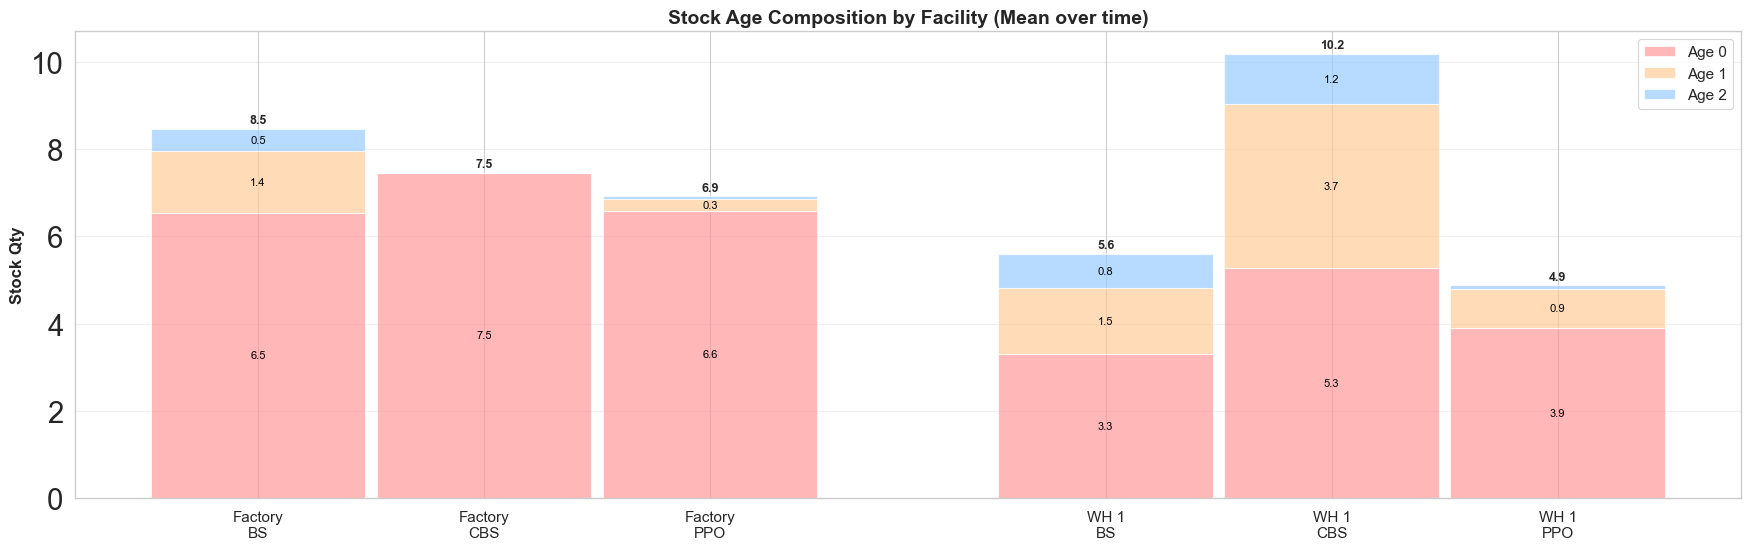

In [105]:
traces_by_method = {"BS": best_returns_trace_Ax_BS, "CBS": best_returns_trace_Ax_CBS, "PPO": returns_trace_PPO}
visualize_clustered_stock_age_composition(traces_by_method, agg="mean_over_time")